In [4]:
#Current goal: Save all the pairs of (pre,post) here for LIC and run the codes
import os
high_income = ['hawaii', 'la_palma', 'marhsall', 'noto']
pre_event_dir = r"C:\Users\sweta\Downloads\pre-event\pre-event_wo_ukraine_myanmar_mexico"
post_event_dir = r"C:\Users\sweta\Downloads\post-event\post-event"

all_pre_files = os.listdir(pre_event_dir)
filtered_pre_files = [f for f in all_pre_files if any(country.lower() in f.lower() for country in high_income)]
expected_post_files = [f.replace('_pre_disaster', '_post_disaster') for f in filtered_pre_files]
all_post_files = os.listdir(post_event_dir)
existing_post_files = [f for f in expected_post_files if f in all_post_files]

pairs = []
for pre_file, post_file in zip(filtered_pre_files, expected_post_files):
    if post_file in all_post_files:
        pairs.append((os.path.join(pre_event_dir, pre_file), os.path.join(post_event_dir, post_file)))
#----Output---
print(f"Number of filtered pre-event files matching LIC: {len(filtered_pre_files)}")
print(f"Number of expected post-event files generated: {len(expected_post_files)}")
print(f"Number of existing post-event files found: {len(existing_post_files)}")
print(f"Number of matched pre/post pairs: {len(pairs)}")

if len(filtered_pre_files) == len(existing_post_files) == len(pairs):
    print("Perfect 1:1 correspondence found between pre and post event files.")
else:
    print("Mismatch detected between pre and post event files.")

Number of filtered pre-event files matching LIC: 1077
Number of expected post-event files generated: 1077
Number of existing post-event files found: 1077
Number of matched pre/post pairs: 1077
Perfect 1:1 correspondence found between pre and post event files.


In [6]:
#just need for sanity
#all imports
import os
import random
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.utils import spectral_norm

#----
#Configuration
#----
class Config:
    seed = 42
    img_size = 256
    batch_size = 16
    epochs = 10  # 10-epoch training
    lr = 2e-4
    betas = (0.5, 0.999)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Base loss weights (dynamically adjusted)
    lambda_cls = 1
    lambda_mask = 10
    lambda_gp = 10
    lambda_cycle = 10
    
    # Paths - updated for your local Windows system
    data_root = r"C:\Users\sweta\.cache\kagglehub\datasets\qianlanzz\xbd-dataset\versions\1\xbd"
    save_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\saved_models"
    samples_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\samples"
    plots_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\plots"
    
    disaster_types = [
        'volcano', 'fire', 'tornado', 'tsunami',
        'flooding', 'earthquake', 'hurricane'
    ]

config = Config()

# Create directories if they don't exist
os.makedirs(config.save_dir, exist_ok=True)
os.makedirs(config.samples_dir, exist_ok=True)
os.makedirs(config.plots_dir, exist_ok=True)

# -------------------------
# Dataset Implementation
# -------------------------
class XBDDataset(Dataset):
    def __init__(self, split_names=("train", "tier1", "tier3")):
        self.pairs = []
        for split in split_names:
            split_path = os.path.join(config.data_root, split)
            images_dir = os.path.join(split_path, "images")
            labels_dir = os.path.join(split_path, "labels")
            
            pre_images = glob.glob(os.path.join(images_dir, "*_pre_disaster.png"))
            for pre_path in pre_images:
                base = os.path.basename(pre_path).replace("_pre_disaster.png", "")
                post_path = os.path.join(images_dir, f"{base}_post_disaster.png")
                label_path = os.path.join(labels_dir, f"{base}_post_disaster.json")
                
                if os.path.exists(post_path):
                    self.pairs.append({
                        "pre": pre_path,
                        "post": post_path,
                        "label": label_path if os.path.exists(label_path) else None
                    })

        self.transform = transforms.Compose([
            transforms.Resize(config.img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.pairs)

    def parse_disaster(self, label_path):
        try:
            with open(label_path) as f:
                data = json.load(f)
            disaster = data['metadata']['disaster_type']
            return torch.tensor(config.disaster_types.index(disaster), dtype=torch.long)
        except:
            return torch.tensor(0, dtype=torch.long)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        pre_img = self.transform(Image.open(pair["pre"]).convert('RGB'))
        post_img = self.transform(Image.open(pair["post"]).convert('RGB'))
        disaster_label = self.parse_disaster(pair["label"])
        
        with torch.no_grad():
            diff = torch.abs(post_img - pre_img).mean(dim=0, keepdim=True)
            mask = (diff > 0.1).float()
        
        return {
            'pre': pre_img,
            'post': post_img,
            'disaster': disaster_label,
            'mask': mask
        }

# -------------------------
# Generator Network
# -------------------------
class DisasterGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            spectral_norm(nn.Conv2d(4, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        # Decoders
        self.dec_img = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
        
        self.dec_mask = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def add_disaster_channel(self, x, disaster):
        batch_size, _, h, w = x.size()
        disaster_map = disaster.view(-1, 1, 1, 1).expand(-1, -1, h, w).float() / len(config.disaster_types)
        return torch.cat([x, disaster_map], dim=1)

    def forward(self, x, disaster):
        x = self.add_disaster_channel(x, disaster)
        
        # Encoding
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        
        # Decoding
        img = self.dec_img(e4)
        mask = self.dec_mask(e4)
        return img, mask

# -------------------------
# Discriminator Network
# -------------------------
class DisasterDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.src = spectral_norm(nn.Conv2d(512, 1, 4, 1, 1))
        self.cls = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            spectral_norm(nn.Conv2d(512, len(config.disaster_types), 1)),
            nn.Flatten()
        )

    def forward(self, x):
        features = self.main(x)
        return self.src(features), self.cls(features)

import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Initialize generator model
G = DisasterGenerator().to(config.device)

# Load trained weights
G.load_state_dict(torch.load(r"C:\Users\sweta\anaconda_projects\non-trivial\saved_models\G_final.pth", map_location=config.device))

# Set to evaluation mode
G.eval()

print("Loaded Generator Model")

from torchvision import transforms as T

transform_rgb = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])


Loaded Generator Model


C:\Users\sweta\AppData\Local\Temp\ipykernel_89560\1320358088.py:228: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(r"C:\Users\sweta\anaconda_pro


=== Pair 1/1077 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: Unde

KeyboardInterrupt: 

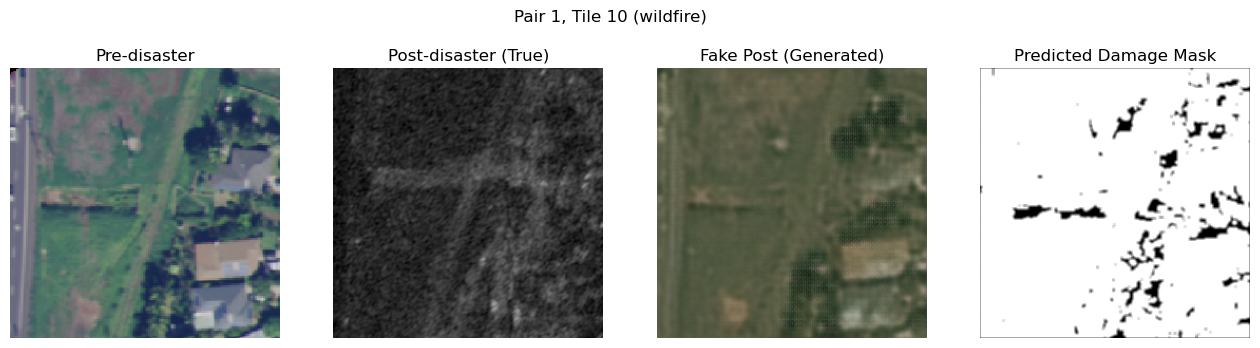

In [7]:
import torch
from torchvision import transforms as T
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import os
import json

# Model setup
device = config.device
G.eval()

disaster_types = ['earthquake', 'flood', 'hurricane', 'wildfire', 'tsunami', 'volcano']

# Disaster label inference
def infer_disaster_type(filename):
    for d in disaster_types:
        if d in filename.lower():
            return d
    return None

transform_rgb = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

transform_gray = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

def tensor_to_pil(tensor):
    """
    Convert a normalized tensor (C,H,W) with values in [-1,1] to a PIL RGB image.
    """
    tensor = tensor.squeeze(0).cpu()  # Remove batch dim, move to CPU
    tensor = (tensor * 0.5) + 0.5     # Denormalize from [-1,1] to [0,1]
    tensor = torch.clamp(tensor, 0, 1)
    np_img = tensor.permute(1, 2, 0).numpy() * 255
    np_img = np_img.astype(np.uint8)
    return Image.fromarray(np_img)


# SAR mask function
def SAR_damage_mask(pre_optical_img, post_sar_img, threshold=0.1):
    def optical_to_sar_like(img):
        img = img.convert('L')
        img = ImageOps.autocontrast(img, cutoff=2)
        return img

    pre_sar_like = optical_to_sar_like(pre_optical_img)
    post_sar = post_sar_img.convert('L')

    pre_tensor = transform_gray(pre_sar_like).to(device)
    post_tensor = transform_gray(post_sar).to(device)

    with torch.no_grad():
        diff = torch.abs(post_tensor - pre_tensor).unsqueeze(0)
        diff = F.avg_pool2d(diff, kernel_size=3, stride=1, padding=1)
        img_std = diff.std()
        adaptive_threshold = threshold + (0.1 * img_std)
        mask = (diff > adaptive_threshold).float()
        mask = F.max_pool2d(mask, kernel_size=3, stride=1, padding=1)
        mask = F.avg_pool2d(mask, kernel_size=3, stride=1, padding=1)

    return mask.squeeze(0)

# Metric calculation
def compute_mask_metrics(pred_mask, true_mask):
    pred = pred_mask.flatten().cpu().numpy().astype(int)
    true = true_mask.flatten().cpu().numpy().astype(int)
    return {
        'IoU': jaccard_score(true, pred),
        'Dice': f1_score(true, pred),
        'F1': f1_score(true, pred),
        'Precision': precision_score(true, pred),
        'Recall': recall_score(true, pred)
    }

# 95% Confidence Interval function
def compute_ci(arr):
    mean = np.mean(arr)
    std_err = np.std(arr) / np.sqrt(len(arr))
    return (mean - 1.96 * std_err, mean + 1.96 * std_err)

# Get all pre-post pairs
high_income = ['hawaii', 'la_palma', 'marhsall', 'noto']
pre_event_dir = r"C:\Users\sweta\Downloads\pre-event\pre-event_wo_ukraine_myanmar_mexico"
post_event_dir = r"C:\Users\sweta\Downloads\post-event\post-event"
all_pre_files = os.listdir(pre_event_dir)
filtered_pre_files = [f for f in all_pre_files if any(country.lower() in f.lower() for country in high_income)]
expected_post_files = [f.replace('_pre_disaster', '_post_disaster') for f in filtered_pre_files]
all_post_files = os.listdir(post_event_dir)
pairs = [
    (os.path.join(pre_event_dir, pre), os.path.join(post_event_dir, post))
    for pre, post in zip(filtered_pre_files, expected_post_files)
    if post in all_post_files
]

# Output directories setup
output_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\evaluation_bias\hic_results"
os.makedirs(output_dir, exist_ok=True)

disaster_output_dirs = {}
for d in disaster_types:
    dir_path = os.path.join(output_dir, d)
    os.makedirs(dir_path, exist_ok=True)
    disaster_output_dirs[d] = dir_path

# Evaluation loop
all_pair_metrics = []
disaster_type_metrics = {d: [] for d in disaster_types}

for pair_idx, (pre_path, post_path) in enumerate(pairs):
    print(f"\n=== Pair {pair_idx+1}/{len(pairs)} ===")
    pre_img_full = Image.open(pre_path).convert('RGB')
    post_img_full = Image.open(post_path).convert('RGB')

    tile_size = 256
    width, height = pre_img_full.size
    tiles = []

    for top in range(0, height, tile_size):
        for left in range(0, width, tile_size):
            box = (left, top, left + tile_size, top + tile_size)
            if box[2] <= width and box[3] <= height:
                pre_tile = pre_img_full.crop(box)
                post_tile = post_img_full.crop(box)
                tiles.append((pre_tile, post_tile))

    tile_metrics = []

    for idx, (pre_img, post_img) in enumerate(tiles):
        input_tensor = transform_rgb(pre_img).unsqueeze(0).to(device)
        post_resized = post_img.resize((256, 256))

        inferred_type = infer_disaster_type(pre_path)
        if inferred_type is None:
            print(f"Unknown disaster type for file: {pre_path}")
            continue

        disaster_idx = disaster_types.index(inferred_type)
        disaster_label = torch.tensor([[disaster_idx]], device=device)

        with torch.no_grad():
            fake_post, pred_mask = G(input_tensor, disaster_label)
        actual_mask = SAR_damage_mask(pre_img, post_resized, threshold=0.2)
        fake_post_img = tensor_to_pil(fake_post)
        pred_mask = SAR_damage_mask(pre_img, fake_post_img, threshold=0.2)
        metrics = compute_mask_metrics(pred_mask[0], actual_mask[0])
        tile_metrics.append(metrics)

        # Save visualization every 10th tile
        if idx % 10 == 0:
            vis_dir = os.path.join(disaster_output_dirs[inferred_type], "visualizations")
            os.makedirs(vis_dir, exist_ok=True)

            fig, axs = plt.subplots(1, 4, figsize=(16, 4))

            axs[0].imshow(pre_img)
            axs[0].set_title("Pre-disaster")
            axs[0].axis('off')

            axs[1].imshow(post_img)
            axs[1].set_title("Post-disaster (True)")
            axs[1].axis('off')

            axs[2].imshow(fake_post_img)
            axs[2].set_title("Fake Post (Generated)")
            axs[2].axis('off')

            axs[3].imshow(pred_mask[0].cpu(), cmap='gray')
            axs[3].set_title("Predicted Damage Mask")
            axs[3].axis('off')

            plt.suptitle(f"Pair {pair_idx+1}, Tile {idx} ({inferred_type})")
            save_path = os.path.join(vis_dir, f"pair{pair_idx+1}_tile{idx}.png")
            plt.savefig(save_path)
            plt.close(fig)

    mean_metrics = {
        'IoU': np.mean([m['IoU'] for m in tile_metrics]),
        'Dice': np.mean([m['Dice'] for m in tile_metrics]),
        'F1': np.mean([m['F1'] for m in tile_metrics]),
        'Precision': np.mean([m['Precision'] for m in tile_metrics]),
        'Recall': np.mean([m['Recall'] for m in tile_metrics]),
    }
    all_pair_metrics.append({
        'pair': (os.path.basename(pre_path), os.path.basename(post_path)),
        'metrics': mean_metrics
    })
    disaster_type_metrics[inferred_type].append(mean_metrics)

    print("Mean metrics for this pair:")
    for k, v in mean_metrics.items():
        print(f"  {k}: {v:.3f}")

# Overall stats
print("\n=== Overall Summary Across All Pairs ===")
all_iou = [m['metrics']['IoU'] for m in all_pair_metrics]
all_dice = [m['metrics']['Dice'] for m in all_pair_metrics]
all_f1 = [m['metrics']['F1'] for m in all_pair_metrics]
all_prec = [m['metrics']['Precision'] for m in all_pair_metrics]
all_rec = [m['metrics']['Recall'] for m in all_pair_metrics]

print(f"Average IoU: {np.mean(all_iou):.3f}")
print(f"Median IoU: {np.median(all_iou):.3f}")
print(f"Average Dice: {np.mean(all_dice):.3f}")
print(f"Median Dice: {np.median(all_dice):.3f}")
print(f"Average F1: {np.mean(all_f1):.3f}")
print(f"Median F1: {np.median(all_f1):.3f}")
print(f"Average Precision: {np.mean(all_prec):.3f}")
print(f"Median Precision: {np.median(all_prec):.3f}")
print(f"Average Recall: {np.mean(all_rec):.3f}")
print(f"Median Recall: {np.median(all_rec):.3f}")

# Save global results
with open(os.path.join(output_dir, "per_pair_metrics.json"), "w") as f:
    json.dump(all_pair_metrics, f, indent=2)

summary_stats = {
    'Average IoU': float(np.mean(all_iou)),
    'Median IoU': float(np.median(all_iou)),
    '95% CI IoU': list(compute_ci(all_iou)),

    'Average Dice': float(np.mean(all_dice)),
    'Median Dice': float(np.median(all_dice)),
    '95% CI Dice': list(compute_ci(all_dice)),

    'Average F1': float(np.mean(all_f1)),
    'Median F1': float(np.median(all_f1)),
    '95% CI F1': list(compute_ci(all_f1)),

    'Average Precision': float(np.mean(all_prec)),
    'Median Precision': float(np.median(all_prec)),
    '95% CI Precision': list(compute_ci(all_prec)),

    'Average Recall': float(np.mean(all_rec)),
    'Median Recall': float(np.median(all_rec)),
    '95% CI Recall': list(compute_ci(all_rec)),
}

with open(os.path.join(output_dir, "summary_stats.json"), "w") as f:
    json.dump(summary_stats, f, indent=2)

# Save results per disaster type
for d in disaster_types:
    metrics_list = disaster_type_metrics[d]
    if not metrics_list:
        continue  # skip if no data for this disaster

    iou_vals = [m['IoU'] for m in metrics_list]
    dice_vals = [m['Dice'] for m in metrics_list]
    f1_vals = [m['F1'] for m in metrics_list]
    prec_vals = [m['Precision'] for m in metrics_list]
    rec_vals = [m['Recall'] for m in metrics_list]

    summary = {
        'Average IoU': float(np.mean(iou_vals)),
        'Median IoU': float(np.median(iou_vals)),
        '95% CI IoU': list(compute_ci(iou_vals)),

        'Average Dice': float(np.mean(dice_vals)),
        'Median Dice': float(np.median(dice_vals)),
        '95% CI Dice': list(compute_ci(dice_vals)),

        'Average F1': float(np.mean(f1_vals)),
        'Median F1': float(np.median(f1_vals)),
        '95% CI F1': list(compute_ci(f1_vals)),

        'Average Precision': float(np.mean(prec_vals)),
        'Median Precision': float(np.median(prec_vals)),
        '95% CI Precision': list(compute_ci(prec_vals)),

        'Average Recall': float(np.mean(rec_vals)),
        'Median Recall': float(np.median(rec_vals)),
        '95% CI Recall': list(compute_ci(rec_valsl)),
    }

    per_pair_path = os.path.join(disaster_output_dirs[d], f"per_pair_metrics_{d}.json")
    summary_path = os.path.join(disaster_output_dirs[d], f"summary_stats_{d}.json")

    disaster_pairs = [p for p in all_pair_metrics if infer_disaster_type(p['pair'][0]) == d]

    with open(per_pair_path, 'w') as f:
        json.dump(disaster_pairs, f, indent=2)
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"Saved results for disaster '{d}' to {disaster_output_dirs[d]}")

print(f"\nSaved all results to: {output_dir}")

In [ ]:
#multiclass
import torch
from torchvision import transforms as T
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import os
import json
import numpy as np
from scipy.ndimage import binary_opening, binary_closing
# Model setup
device = config.device
G.eval()

disaster_types = ['earthquake', 'flood', 'hurricane', 'wildfire', 'tsunami', 'volcano']

# Disaster label inference
def infer_disaster_type(filename):
    for d in disaster_types:
        if d in filename.lower():
            return d
    return None

transform_rgb = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

transform_gray = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

def tensor_to_pil(tensor):
    """
    Convert a normalized tensor (C,H,W) with values in [-1,1] to a PIL RGB image.
    """
    tensor = tensor.squeeze(0).cpu()  # Remove batch dim, move to CPU
    tensor = (tensor * 0.5) + 0.5     # Denormalize from [-1,1] to [0,1]
    tensor = torch.clamp(tensor, 0, 1)
    np_img = tensor.permute(1, 2, 0).numpy() * 255
    np_img = np_img.astype(np.uint8)
    return Image.fromarray(np_img)

def clean_multiclass_mask(mask_np, min_region_size=20):
    cleaned_mask = np.zeros_like(mask_np)
    for cls in range(1, 4):  # Skip 0 (no damage)
        binary = (mask_np == cls)
        binary = binary_opening(binary, structure=np.ones((3,3)))
        binary = binary_closing(binary, structure=np.ones((3,3)))
        cleaned_mask[binary] = cls
    return cleaned_mask

def SAR_damage_mask_multiclass_merged(pre_optical_img, post_sar_img):
    def optical_to_sar_like(img):
        img = img.convert('L')
        img = ImageOps.autocontrast(img, cutoff=2)
        return img

    pre_sar_like = optical_to_sar_like(pre_optical_img)
    post_sar = post_sar_img.convert('L')

    pre_tensor = transform_gray(pre_sar_like).to(device).squeeze(0)
    post_tensor = transform_gray(post_sar).to(device).squeeze(0)

    with torch.no_grad():
        diff = torch.abs(post_tensor - pre_tensor)  # shape (H, W)
        diff_smoothed = F.avg_pool2d(diff.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=2).squeeze()

        # Normalize diff to [0,1]
        diff_min, diff_max = diff_smoothed.min(), diff_smoothed.max()
        diff_norm = (diff_smoothed - diff_min) / (diff_max - diff_min + 1e-8)

        # Improved thresholds (more spaced out)
        thresholds = [0.08, 0.22, 0.45]  # You can grid search/tune these

        # Initial multiclass mask (0 = no damage, 1 = minor, 2 = major, 3 = destroyed)
        mask = torch.zeros_like(diff_norm, dtype=torch.long)
        mask = torch.where((diff_norm >= thresholds[0]) & (diff_norm < thresholds[1]), 1, mask)  # Minor
        mask = torch.where((diff_norm >= thresholds[1]) & (diff_norm < thresholds[2]), 2, mask)  # Major
        mask = torch.where(diff_norm >= thresholds[2], 3, mask)  # Destroyed

    # Post-process: remove specks and smooth classes
    mask_np = mask.cpu().numpy()
    cleaned = clean_multiclass_mask(mask_np)

    return torch.from_numpy(cleaned).long()

# Metric calculation with weighted average for multiclass
def compute_mask_metrics(pred_mask, true_mask):
    pred = pred_mask.flatten().cpu().numpy().astype(int)
    true = true_mask.flatten().cpu().numpy().astype(int)
    return {
        'IoU': jaccard_score(true, pred, average='weighted'),
        'Dice': f1_score(true, pred, average='weighted'),
        'F1': f1_score(true, pred, average='weighted'),
        'Precision': precision_score(true, pred, average='weighted'),
        'Recall': recall_score(true, pred, average='weighted')
    }

# 95% Confidence Interval function
def compute_ci(arr):
    mean = np.mean(arr)
    std_err = np.std(arr) / np.sqrt(len(arr))
    return (mean - 1.96 * std_err, mean + 1.96 * std_err)

# Define categorical colormap for visualization of multiclass masks
damage_colors = ['black', 'blue', 'yellow', 'red']  # for classes 0 to 3
cmap = mcolors.ListedColormap(damage_colors)
norm = mcolors.BoundaryNorm(boundaries=[-0.5,0.5,1.5,2.5,3.5], ncolors=len(damage_colors))

# Get all pre-post pairs
high_income = ['hawaii', 'la_palma', 'marshall', 'noto']
pre_event_dir = r"C:\Users\sweta\Downloads\pre-event\pre-event_wo_ukraine_myanmar_mexico"
post_event_dir = r"C:\Users\sweta\Downloads\post-event\post-event"
all_pre_files = os.listdir(pre_event_dir)
filtered_pre_files = [f for f in all_pre_files if any(country.lower() in f.lower() for country in high_income)]
expected_post_files = [f.replace('_pre_disaster', '_post_disaster') for f in filtered_pre_files]
all_post_files = os.listdir(post_event_dir)
pairs = [
    (os.path.join(pre_event_dir, pre), os.path.join(post_event_dir, post))
    for pre, post in zip(filtered_pre_files, expected_post_files)
    if post in all_post_files
]

# Output directories setup - NEW multiclass folder inside lic_results
base_results_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\evaluation_bias\hic_results"
output_dir = os.path.join(base_results_dir, "multiclass")
os.makedirs(output_dir, exist_ok=True)

disaster_output_dirs = {}
for d in disaster_types:
    dir_path = os.path.join(output_dir, d)
    os.makedirs(dir_path, exist_ok=True)
    disaster_output_dirs[d] = dir_path

# Evaluation loop
all_pair_metrics = []
disaster_type_metrics = {d: [] for d in disaster_types}

for pair_idx, (pre_path, post_path) in enumerate(pairs):
    print(f"\n=== Pair {pair_idx+1}/{len(pairs)} ===")
    pre_img_full = Image.open(pre_path).convert('RGB')
    post_img_full = Image.open(post_path).convert('RGB')

    tile_size = 256
    width, height = pre_img_full.size
    tiles = []

    for top in range(0, height, tile_size):
        for left in range(0, width, tile_size):
            box = (left, top, left + tile_size, top + tile_size)
            if box[2] <= width and box[3] <= height:
                pre_tile = pre_img_full.crop(box)
                post_tile = post_img_full.crop(box)
                tiles.append((pre_tile, post_tile))

    tile_metrics = []

    for idx, (pre_img, post_img) in enumerate(tiles):
        input_tensor = transform_rgb(pre_img).unsqueeze(0).to(device)
        post_resized = post_img.resize((256, 256))

        inferred_type = infer_disaster_type(pre_path)
        if inferred_type is None:
            print(f"Unknown disaster type for file: {pre_path}")
            continue

        disaster_idx = disaster_types.index(inferred_type)
        disaster_label = torch.tensor([[disaster_idx]], device=device)

        with torch.no_grad():
            fake_post, pred_mask = G(input_tensor, disaster_label)
        # Use multiclass mask function here
        actual_mask = SAR_damage_mask_multiclass_merged(pre_img, post_resized)
        fake_post_img = tensor_to_pil(fake_post)
        pred_mask = SAR_damage_mask_multiclass_merged(pre_img, fake_post_img)

        metrics = compute_mask_metrics(pred_mask, actual_mask)
        tile_metrics.append(metrics)

        # Save visualization every 10th tile
        if idx % 10 == 0:
            vis_dir = os.path.join(disaster_output_dirs[inferred_type], "visualizations")
            os.makedirs(vis_dir, exist_ok=True)

            fig, axs = plt.subplots(1, 4, figsize=(16, 4))

            axs[0].imshow(pre_img)
            axs[0].set_title("Pre-disaster")
            axs[0].axis('off')

            axs[1].imshow(post_img)
            axs[1].set_title("Post-disaster (True)")
            axs[1].axis('off')

            axs[2].imshow(fake_post_img)
            axs[2].set_title("Fake Post (Generated)")
            axs[2].axis('off')

            # Show predicted damage mask with categorical colors
            axs[3].imshow(pred_mask.cpu(), cmap=cmap, norm=norm)
            axs[3].set_title("Predicted Damage Mask")
            axs[3].axis('off')

            plt.suptitle(f"Pair {pair_idx+1}, Tile {idx} ({inferred_type})")
            save_path = os.path.join(vis_dir, f"pair{pair_idx+1}_tile{idx}.png")
            plt.savefig(save_path)
            plt.close(fig)

    mean_metrics = {
        'IoU': np.mean([m['IoU'] for m in tile_metrics]),
        'Dice': np.mean([m['Dice'] for m in tile_metrics]),
        'F1': np.mean([m['F1'] for m in tile_metrics]),
        'Precision': np.mean([m['Precision'] for m in tile_metrics]),
        'Recall': np.mean([m['Recall'] for m in tile_metrics]),
    }
    all_pair_metrics.append({
        'pair': (os.path.basename(pre_path), os.path.basename(post_path)),
        'metrics': mean_metrics
    })
    disaster_type_metrics[inferred_type].append(mean_metrics)

    print("Mean metrics for this pair:")
    for k, v in mean_metrics.items():
        print(f"  {k}: {v:.3f}")

# Overall stats
print("\n=== Overall Summary Across All Pairs ===")
all_iou = [m['metrics']['IoU'] for m in all_pair_metrics]
all_dice = [m['metrics']['Dice'] for m in all_pair_metrics]
all_f1 = [m['metrics']['F1'] for m in all_pair_metrics]
all_prec = [m['metrics']['Precision'] for m in all_pair_metrics]
all_rec = [m['metrics']['Recall'] for m in all_pair_metrics]

print(f"Average IoU: {np.mean(all_iou):.3f}")
print(f"Median IoU: {np.median(all_iou):.3f}")
print(f"Average Dice: {np.mean(all_dice):.3f}")
print(f"Median Dice: {np.median(all_dice):.3f}")
print(f"Average F1: {np.mean(all_f1):.3f}")
print(f"Median F1: {np.median(all_f1):.3f}")
print(f"Average Precision: {np.mean(all_prec):.3f}")
print(f"Median Precision: {np.median(all_prec):.3f}")
print(f"Average Recall: {np.mean(all_rec):.3f}")
print(f"Median Recall: {np.median(all_rec):.3f}")

# Save global results
with open(os.path.join(output_dir, "per_pair_metrics.json"), "w") as f:
    json.dump(all_pair_metrics, f, indent=2)

summary_stats = {
    'Average IoU': float(np.mean(all_iou)),
    'Median IoU': float(np.median(all_iou)),
    '95% CI IoU': list(compute_ci(all_iou)),

    'Average Dice': float(np.mean(all_dice)),
    'Median Dice': float(np.median(all_dice)),
    '95% CI Dice': list(compute_ci(all_dice)),

    'Average F1': float(np.mean(all_f1)),
    'Median F1': float(np.median(all_f1)),
    '95% CI F1': list(compute_ci(all_f1)),

    'Average Precision': float(np.mean(all_prec)),
    'Median Precision': float(np.median(all_prec)),
    '95% CI Precision': list(compute_ci(all_prec)),

    'Average Recall': float(np.mean(all_rec)),
    'Median Recall': float(np.median(all_rec)),
    '95% CI Recall': list(compute_ci(all_rec)),
}

with open(os.path.join(output_dir, "summary_stats.json"), "w") as f:
    json.dump(summary_stats, f, indent=2)

# Save results per disaster type
for d in disaster_types:
    metrics_list = disaster_type_metrics[d]
    if not metrics_list:
        continue  # skip if no data for this disaster

    iou_vals = [m['IoU'] for m in metrics_list]
    dice_vals = [m['Dice'] for m in metrics_list]
    f1_vals = [m['F1'] for m in metrics_list]
    prec_vals = [m['Precision'] for m in metrics_list]
    rec_vals = [m['Recall'] for m in metrics_list]

    summary = {
        'Average IoU': float(np.mean(iou_vals)),
        'Median IoU': float(np.median(iou_vals)),
        '95% CI IoU': list(compute_ci(iou_vals)),

        'Average Dice': float(np.mean(dice_vals)),
        'Median Dice': float(np.median(dice_vals)),
        '95% CI Dice': list(compute_ci(dice_vals)),

        'Average F1': float(np.mean(f1_vals)),
        'Median F1': float(np.median(f1_vals)),
        '95% CI F1': list(compute_ci(f1_vals)),

        'Average Precision': float(np.mean(prec_vals)),
        'Median Precision': float(np.median(prec_vals)),
        '95% CI Precision': list(compute_ci(prec_vals)),

        'Average Recall': float(np.mean(rec_vals)),
        'Median Recall': float(np.median(rec_vals)),
        '95% CI Recall': list(compute_ci(rec_vals)),
    }

    per_pair_path = os.path.join(disaster_output_dirs[d], f"per_pair_metrics_{d}.json")
    summary_path = os.path.join(disaster_output_dirs[d], f"summary_stats_{d}.json")

    disaster_pairs = [p for p in all_pair_metrics if infer_disaster_type(p['pair'][0]) == d]

    with open(per_pair_path, 'w') as f:
        json.dump(disaster_pairs, f, indent=2)
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"Saved results for disaster '{d}' to {disaster_output_dirs[d]}")

print(f"\nSaved all results to: {output_dir}")



=== Pair 1/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.401
  Dice: 0.482
  F1: 0.482
  Precision: 0.811
  Recall: 0.466

=== Pair 2/1154 ===
Mean metrics for this pair:
  IoU: 0.575
  Dice: 0.691
  F1: 0.691
  Precision: 0.708
  Recall: 0.685

=== Pair 3/1154 ===
Mean metrics for this pair:
  IoU: 0.381
  Dice: 0.533
  F1: 0.533
  Precision: 0.551
  Recall: 0.534

=== Pair 4/1154 ===
Mean metrics for this pair:
  IoU: 0.381
  Dice: 0.539
  F1: 0.539
  Precision: 0.550
  Recall: 0.542

=== Pair 5/1154 ===
Mean metrics for this pair:
  IoU: 0.467
  Dice: 0.598
  F1: 0.598
  Precision: 0.643
  Recall: 0.578

=== Pair 6/1154 ===
Mean metrics for this pair:
  IoU: 0.368
  Dice: 0.518
  F1: 0.518
  Precision: 0.556
  Recall: 0.516

=== Pair 7/1154 ===
Mean metrics for this pair:
  IoU: 0.387
  Dice: 0.532
  F1: 0.532
  Precision: 0.552
  Recall: 0.532

=== Pair 8/1154 ===
Mean metrics for this pair:
  IoU: 0.642
  Dice: 0.729
  F1: 0.729
  Precision: 0.782
  Recall: 0.703

=== Pair 9/1154 ===
Mean metrics for

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.352
  Dice: 0.482
  F1: 0.482
  Precision: 0.538
  Recall: 0.504

=== Pair 14/1154 ===
Mean metrics for this pair:
  IoU: 0.332
  Dice: 0.481
  F1: 0.481
  Precision: 0.529
  Recall: 0.481

=== Pair 15/1154 ===
Mean metrics for this pair:
  IoU: 0.457
  Dice: 0.596
  F1: 0.596
  Precision: 0.604
  Recall: 0.598

=== Pair 16/1154 ===
Mean metrics for this pair:
  IoU: 0.374
  Dice: 0.501
  F1: 0.501
  Precision: 0.545
  Recall: 0.499

=== Pair 17/1154 ===
Mean metrics for this pair:
  IoU: 0.295
  Dice: 0.421
  F1: 0.421
  Precision: 0.444
  Recall: 0.421

=== Pair 18/1154 ===
Mean metrics for this pair:
  IoU: 0.277
  Dice: 0.405
  F1: 0.405
  Precision: 0.444
  Recall: 0.408

=== Pair 19/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.484
  F1: 0.484
  Precision: 0.497
  Recall: 0.481

=== Pair 20/1154 ===
Mean metrics for this pair:
  IoU: 0.399
  Dice: 0.537
  F1: 0.537
  Precision: 0.566
  Recall: 0.533

=== Pair 21/1154 ===
Mean met

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.543
  Dice: 0.642
  F1: 0.642
  Precision: 0.718
  Recall: 0.639

=== Pair 63/1154 ===
Mean metrics for this pair:
  IoU: 0.337
  Dice: 0.457
  F1: 0.457
  Precision: 0.571
  Recall: 0.456

=== Pair 64/1154 ===
Mean metrics for this pair:
  IoU: 0.341
  Dice: 0.472
  F1: 0.472
  Precision: 0.517
  Recall: 0.473

=== Pair 65/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.288
  Dice: 0.344
  F1: 0.344
  Precision: 0.882
  Recall: 0.327

=== Pair 66/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.320
  Dice: 0.398
  F1: 0.398
  Precision: 0.684
  Recall: 0.409

=== Pair 67/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.346
  F1: 0.346
  Precision: 0.438
  Recall: 0.353

=== Pair 68/1154 ===
Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.421
  F1: 0.421
  Precision: 0.474
  Recall: 0.431

=== Pair 69/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.466
  F1: 0.466
  Precision: 0.504
  Recall: 0.473

=== Pair 70/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.400
  F1: 0.400
  Precision: 0.516
  Recall: 0.393

=== Pair 71/1154 ===
Mean metrics for this pair:
  IoU: 0.223
  Dice: 0.356
  F1: 0.356
  Precision: 0.482
  Recall: 0.342

=== Pair 72/1154 ===
Mean metrics for this pair:
  IoU: 0.269
  Dice: 0.412
  F1: 0.412
  Precision: 0.437
  Recall: 0.419

=== Pair 73/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.417
  F1: 0.417
  Precision: 0.496
  Recall: 0.407

=== Pair 74/1154 ===
Mean met

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.159
  Dice: 0.184
  F1: 0.184
  Precision: 0.972
  Recall: 0.168

=== Pair 76/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.141
  Dice: 0.174
  F1: 0.174
  Precision: 0.938
  Recall: 0.155

=== Pair 77/1154 ===
Mean metrics for this pair:
  IoU: 0.360
  Dice: 0.504
  F1: 0.504
  Precision: 0.516
  Recall: 0.511

=== Pair 78/1154 ===
Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.496
  F1: 0.496
  Precision: 0.518
  Recall: 0.496

=== Pair 79/1154 ===
Mean metrics for this pair:
  IoU: 0.319
  Dice: 0.469
  F1: 0.469
  Precision: 0.496
  Recall: 0.471

=== Pair 80/1154 ===
Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.493
  F1: 0.493
  Precision: 0.528
  Recall: 0.495

=== Pair 81/1154 ===
Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.475
  F1: 0.475
  Precision: 0.518
  Recall: 0.484

=== Pair 82/1154 ===
Mean metrics for this pair:
  IoU: 0.342
  Dice: 0.492
  F1: 0.492
  Precision: 0.522
  Recall: 0.495

=== Pair 83/1154 ===
Mean metrics for this pair:
  IoU: 0.346
  Dice: 0.499
  F1: 0.499
  Precision: 0.521
  Recall: 0.506

=== Pair 84/1154 ===
Mean met

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.320
  Dice: 0.440
  F1: 0.440
  Precision: 0.705
  Recall: 0.440

=== Pair 103/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.306
  Dice: 0.391
  F1: 0.391
  Precision: 0.694
  Recall: 0.392

=== Pair 104/1154 ===
Mean metrics for this pair:
  IoU: 0.245
  Dice: 0.380
  F1: 0.380
  Precision: 0.457
  Recall: 0.387

=== Pair 105/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.436
  F1: 0.436
  Precision: 0.488
  Recall: 0.443

=== Pair 106/1154 ===
Mean metrics for this pair:
  IoU: 0.300
  Dice: 0.449
  F1: 0.449
  Precision: 0.519
  Recall: 0.452

=== Pair 107/1154 ===
Mean metrics for this pair:
  IoU: 0.180
  Dice: 0.290
  F1: 0.290
  Precision: 0.432
  Recall: 0.311

=== Pair 108/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.358
  F1: 0.358
  Precision: 0.411
  Recall: 0.361

=== Pair 109/1154 ===
Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.303
  F1: 0.303
  Precision: 0.453
  Recall: 0.292

=== Pair 110/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.490
  F1: 0.490
  Precision: 0.528
  Recall: 0.485

=== Pair 111/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.364
  Dice: 0.474
  F1: 0.474
  Precision: 0.691
  Recall: 0.469

=== Pair 114/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.342
  Dice: 0.467
  F1: 0.467
  Precision: 0.601
  Recall: 0.469

=== Pair 115/1154 ===
Mean metrics for this pair:
  IoU: 0.315
  Dice: 0.468
  F1: 0.468
  Precision: 0.502
  Recall: 0.469

=== Pair 116/1154 ===
Mean metrics for this pair:
  IoU: 0.295
  Dice: 0.442
  F1: 0.442
  Precision: 0.477
  Recall: 0.445

=== Pair 117/1154 ===
Mean metrics for this pair:
  IoU: 0.299
  Dice: 0.447
  F1: 0.447
  Precision: 0.490
  Recall: 0.449

=== Pair 118/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.510
  F1: 0.510
  Precision: 0.535
  Recall: 0.509

=== Pair 119/1154 ===
Mean metrics for this pair:
  IoU: 0.331
  Dice: 0.484
  F1: 0.484
  Precision: 0.509
  Recall: 0.485

=== Pair 120/1154 ===
Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.501
  F1: 0.501
  Precision: 0.540
  Recall: 0.502

=== Pair 121/1154 ===
Mean metrics for this pair:
  IoU: 0.353
  Dice: 0.507
  F1: 0.507
  Precision: 0.544
  Recall: 0.502

=== Pair 122/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.290
  Dice: 0.409
  F1: 0.409
  Precision: 0.695
  Recall: 0.412

=== Pair 141/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.500
  F1: 0.500
  Precision: 0.575
  Recall: 0.487

=== Pair 142/1154 ===
Mean metrics for this pair:
  IoU: 0.394
  Dice: 0.501
  F1: 0.501
  Precision: 0.579
  Recall: 0.502

=== Pair 143/1154 ===
Mean metrics for this pair:
  IoU: 0.218
  Dice: 0.341
  F1: 0.341
  Precision: 0.421
  Recall: 0.353

=== Pair 144/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.329
  F1: 0.329
  Precision: 0.372
  Recall: 0.334

=== Pair 145/1154 ===
Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.351
  F1: 0.351
  Precision: 0.415
  Recall: 0.358

=== Pair 146/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.340
  F1: 0.340
  Precision: 0.441
  Recall: 0.352

=== Pair 147/1154 ===
Mean metrics for this pair:
  IoU: 0.169
  Dice: 0.285
  F1: 0.285
  Precision: 0.428
  Recall: 0.274

=== Pair 148/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.268
  Dice: 0.382
  F1: 0.382
  Precision: 0.681
  Recall: 0.397

=== Pair 179/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.500
  F1: 0.500
  Precision: 0.569
  Recall: 0.481

=== Pair 180/1154 ===
Mean metrics for this pair:
  IoU: 0.264
  Dice: 0.366
  F1: 0.366
  Precision: 0.481
  Recall: 0.380

=== Pair 181/1154 ===
Mean metrics for this pair:
  IoU: 0.263
  Dice: 0.391
  F1: 0.391
  Precision: 0.445
  Recall: 0.403

=== Pair 182/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.411
  F1: 0.411
  Precision: 0.456
  Recall: 0.411

=== Pair 183/1154 ===
Mean metrics for this pair:
  IoU: 0.248
  Dice: 0.385
  F1: 0.385
  Precision: 0.452
  Recall: 0.379

=== Pair 184/1154 ===
Mean metrics for this pair:
  IoU: 0.180
  Dice: 0.298
  F1: 0.298
  Precision: 0.362
  Recall: 0.305

=== Pair 185/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.339
  F1: 0.339
  Precision: 0.390
  Recall: 0.343

=== Pair 186/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.308
  Dice: 0.426
  F1: 0.426
  Precision: 0.706
  Recall: 0.430

=== Pair 217/1154 ===
Mean metrics for this pair:
  IoU: 0.404
  Dice: 0.552
  F1: 0.552
  Precision: 0.597
  Recall: 0.541

=== Pair 218/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.431
  F1: 0.431
  Precision: 0.528
  Recall: 0.437

=== Pair 219/1154 ===
Mean metrics for this pair:
  IoU: 0.314
  Dice: 0.441
  F1: 0.441
  Precision: 0.512
  Recall: 0.466

=== Pair 220/1154 ===
Mean metrics for this pair:
  IoU: 0.239
  Dice: 0.376
  F1: 0.376
  Precision: 0.481
  Recall: 0.362

=== Pair 221/1154 ===
Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.420
  F1: 0.420
  Precision: 0.461
  Recall: 0.422

=== Pair 222/1154 ===
Mean metrics for this pair:
  IoU: 0.256
  Dice: 0.396
  F1: 0.396
  Precision: 0.429
  Recall: 0.408

=== Pair 223/1154 ===
Mean metrics for this pair:
  IoU: 0.211
  Dice: 0.342
  F1: 0.342
  Precision: 0.385
  Recall: 0.351

=== Pair 224/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.302
  Dice: 0.419
  F1: 0.419
  Precision: 0.691
  Recall: 0.424

=== Pair 255/1154 ===
Mean metrics for this pair:
  IoU: 0.285
  Dice: 0.427
  F1: 0.427
  Precision: 0.505
  Recall: 0.416

=== Pair 256/1154 ===
Mean metrics for this pair:
  IoU: 0.338
  Dice: 0.464
  F1: 0.464
  Precision: 0.557
  Recall: 0.465

=== Pair 257/1154 ===
Mean metrics for this pair:
  IoU: 0.309
  Dice: 0.430
  F1: 0.430
  Precision: 0.564
  Recall: 0.426

=== Pair 258/1154 ===
Mean metrics for this pair:
  IoU: 0.206
  Dice: 0.317
  F1: 0.317
  Precision: 0.402
  Recall: 0.316

=== Pair 259/1154 ===
Mean metrics for this pair:
  IoU: 0.260
  Dice: 0.391
  F1: 0.391
  Precision: 0.465
  Recall: 0.398

=== Pair 260/1154 ===
Mean metrics for this pair:
  IoU: 0.272
  Dice: 0.420
  F1: 0.420
  Precision: 0.443
  Recall: 0.425

=== Pair 261/1154 ===
Mean metrics for this pair:
  IoU: 0.210
  Dice: 0.340
  F1: 0.340
  Precision: 0.409
  Recall: 0.342

=== Pair 262/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.273
  Dice: 0.387
  F1: 0.387
  Precision: 0.663
  Recall: 0.393

=== Pair 293/1154 ===
Mean metrics for this pair:
  IoU: 0.369
  Dice: 0.517
  F1: 0.517
  Precision: 0.625
  Recall: 0.498

=== Pair 294/1154 ===
Mean metrics for this pair:
  IoU: 0.346
  Dice: 0.481
  F1: 0.481
  Precision: 0.585
  Recall: 0.464

=== Pair 295/1154 ===
Mean metrics for this pair:
  IoU: 0.301
  Dice: 0.441
  F1: 0.441
  Precision: 0.553
  Recall: 0.429

=== Pair 296/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.439
  F1: 0.439
  Precision: 0.586
  Recall: 0.420

=== Pair 297/1154 ===
Mean metrics for this pair:
  IoU: 0.235
  Dice: 0.369
  F1: 0.369
  Precision: 0.492
  Recall: 0.352

=== Pair 298/1154 ===
Mean metrics for this pair:
  IoU: 0.262
  Dice: 0.403
  F1: 0.403
  Precision: 0.451
  Recall: 0.407

=== Pair 299/1154 ===
Mean metrics for this pair:
  IoU: 0.217
  Dice: 0.347
  F1: 0.347
  Precision: 0.435
  Recall: 0.353

=== Pair 300/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.216
  Dice: 0.331
  F1: 0.331
  Precision: 0.613
  Recall: 0.340

=== Pair 331/1154 ===
Mean metrics for this pair:
  IoU: 0.408
  Dice: 0.550
  F1: 0.550
  Precision: 0.673
  Recall: 0.518

=== Pair 332/1154 ===
Mean metrics for this pair:
  IoU: 0.431
  Dice: 0.576
  F1: 0.576
  Precision: 0.670
  Recall: 0.544

=== Pair 333/1154 ===
Mean metrics for this pair:
  IoU: 0.357
  Dice: 0.491
  F1: 0.491
  Precision: 0.598
  Recall: 0.467

=== Pair 334/1154 ===
Mean metrics for this pair:
  IoU: 0.408
  Dice: 0.512
  F1: 0.512
  Precision: 0.633
  Recall: 0.487

=== Pair 335/1154 ===
Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.411
  F1: 0.411
  Precision: 0.525
  Recall: 0.395

=== Pair 336/1154 ===
Mean metrics for this pair:
  IoU: 0.237
  Dice: 0.372
  F1: 0.372
  Precision: 0.480
  Recall: 0.372

=== Pair 337/1154 ===
Mean metrics for this pair:
  IoU: 0.187
  Dice: 0.309
  F1: 0.309
  Precision: 0.433
  Recall: 0.327

=== Pair 338/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.254
  Dice: 0.369
  F1: 0.369
  Precision: 0.659
  Recall: 0.374

=== Pair 369/1154 ===
Mean metrics for this pair:
  IoU: 0.385
  Dice: 0.527
  F1: 0.527
  Precision: 0.670
  Recall: 0.499

=== Pair 370/1154 ===
Mean metrics for this pair:
  IoU: 0.415
  Dice: 0.556
  F1: 0.556
  Precision: 0.667
  Recall: 0.529

=== Pair 371/1154 ===
Mean metrics for this pair:
  IoU: 0.416
  Dice: 0.552
  F1: 0.552
  Precision: 0.662
  Recall: 0.513

=== Pair 372/1154 ===
Mean metrics for this pair:
  IoU: 0.433
  Dice: 0.549
  F1: 0.549
  Precision: 0.658
  Recall: 0.529

=== Pair 373/1154 ===
Mean metrics for this pair:
  IoU: 0.351
  Dice: 0.463
  F1: 0.463
  Precision: 0.583
  Recall: 0.446

=== Pair 374/1154 ===
Mean metrics for this pair:
  IoU: 0.226
  Dice: 0.362
  F1: 0.362
  Precision: 0.520
  Recall: 0.352

=== Pair 375/1154 ===
Mean metrics for this pair:
  IoU: 0.198
  Dice: 0.318
  F1: 0.318
  Precision: 0.455
  Recall: 0.338

=== Pair 376/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.375
  F1: 0.375
  Precision: 0.659
  Recall: 0.383

=== Pair 407/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.353
  Dice: 0.478
  F1: 0.478
  Precision: 0.702
  Recall: 0.456

=== Pair 408/1154 ===
Mean metrics for this pair:
  IoU: 0.514
  Dice: 0.657
  F1: 0.657
  Precision: 0.733
  Recall: 0.627

=== Pair 409/1154 ===
Mean metrics for this pair:
  IoU: 0.259
  Dice: 0.390
  F1: 0.390
  Precision: 0.521
  Recall: 0.367

=== Pair 410/1154 ===
Mean metrics for this pair:
  IoU: 0.471
  Dice: 0.618
  F1: 0.618
  Precision: 0.709
  Recall: 0.586

=== Pair 411/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.497
  Dice: 0.599
  F1: 0.599
  Precision: 0.729
  Recall: 0.572

=== Pair 412/1154 ===
Mean metrics for this pair:
  IoU: 0.238
  Dice: 0.368
  F1: 0.368
  Precision: 0.502
  Recall: 0.346

=== Pair 413/1154 ===
Mean metrics for this pair:
  IoU: 0.218
  Dice: 0.353
  F1: 0.353
  Precision: 0.480
  Recall: 0.339

=== Pair 414/1154 ===
Mean metrics for this pair:
  IoU: 0.219
  Dice: 0.355
  F1: 0.355
  Precision: 0.487
  Recall: 0.342

=== Pair 415/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.323
  F1: 0.323
  Precision: 0.415
  Recall: 0.330

=== Pair 416/1154 ===
Mean metrics for this pair:
  IoU: 0.259
  Dice: 0.386
  F1: 0.386
  Precision: 0.493
  Recall: 0.374

=== Pair 417/1154 ===
Mean metrics for this pair:
  IoU: 0.456
  Dice: 0.612
  F1: 0.612
  Precision: 0.654
  Recall: 0.613

=== Pair 418/1154 ===
Mean metrics for this pair:
  IoU: 0.320
  Dice: 0.466
  F1: 0.466
  Precision: 0.512
  Recall: 0.468

=== Pair 419/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.196
  Dice: 0.300
  F1: 0.300
  Precision: 0.633
  Recall: 0.302

=== Pair 440/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.459
  F1: 0.459
  Precision: 0.765
  Recall: 0.435

=== Pair 441/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.439
  F1: 0.439
  Precision: 0.732
  Recall: 0.441

=== Pair 442/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.334
  Dice: 0.423
  F1: 0.423
  Precision: 0.734
  Recall: 0.444

=== Pair 443/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.305
  Dice: 0.398
  F1: 0.398
  Precision: 0.700
  Recall: 0.422

=== Pair 444/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.342
  F1: 0.342
  Precision: 0.792
  Recall: 0.349

=== Pair 445/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.277
  Dice: 0.367
  F1: 0.367
  Precision: 0.691
  Recall: 0.348

=== Pair 446/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.396
  F1: 0.396
  Precision: 0.514
  Recall: 0.381

=== Pair 447/1154 ===
Mean metrics for this pair:
  IoU: 0.359
  Dice: 0.514
  F1: 0.514
  Precision: 0.684
  Recall: 0.488

=== Pair 448/1154 ===
Mean metrics for this pair:
  IoU: 0.340
  Dice: 0.430
  F1: 0.430
  Precision: 0.624
  Recall: 0.414

=== Pair 449/1154 ===
Mean metrics for this pair:
  IoU: 0.451
  Dice: 0.565
  F1: 0.565
  Precision: 0.643
  Recall: 0.554

=== Pair 450/1154 ===
Mean metrics for this pair:
  IoU: 0.310
  Dice: 0.457
  F1: 0.457
  Precision: 0.529
  Recall: 0.451

=== Pair 451/1154 ===
Mean metrics for this pair:
  IoU: 0.253
  Dice: 0.388
  F1: 0.388
  Precision: 0.463
  Recall: 0.381

=== Pair 452/1154 ===
Mean metrics for this pair:
  IoU: 0.260
  Dice: 0.401
  F1: 0.401
  Precision: 0.495
  Recall: 0.395

=== Pair 453/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.311
  F1: 0.311
  Precision: 0.839
  Recall: 0.299

=== Pair 478/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.148
  Dice: 0.202
  F1: 0.202
  Precision: 0.768
  Recall: 0.199

=== Pair 479/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.437
  Dice: 0.565
  F1: 0.565
  Precision: 0.712
  Recall: 0.539

=== Pair 480/1154 ===
Mean metrics for this pair:
  IoU: 0.355
  Dice: 0.493
  F1: 0.493
  Precision: 0.605
  Recall: 0.476

=== Pair 481/1154 ===
Mean metrics for this pair:
  IoU: 0.483
  Dice: 0.579
  F1: 0.579
  Precision: 0.658
  Recall: 0.595

=== Pair 482/1154 ===
Mean metrics for this pair:
  IoU: 0.396
  Dice: 0.543
  F1: 0.543
  Precision: 0.584
  Recall: 0.541

=== Pair 483/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.473
  F1: 0.473
  Precision: 0.540
  Recall: 0.460

=== Pair 484/1154 ===
Mean metrics for this pair:
  IoU: 0.335
  Dice: 0.484
  F1: 0.484
  Precision: 0.545
  Recall: 0.486

=== Pair 485/1154 ===
Mean metrics for this pair:
  IoU: 0.388
  Dice: 0.545
  F1: 0.545
  Precision: 0.572
  Recall: 0.552

=== Pair 486/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.485
  F1: 0.485
  Precision: 0.522
  Recall: 0.484

=== Pair 487/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.238
  Dice: 0.345
  F1: 0.345
  Precision: 0.728
  Recall: 0.349

=== Pair 510/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.310
  Dice: 0.426
  F1: 0.426
  Precision: 0.599
  Recall: 0.416

=== Pair 511/1154 ===
Mean metrics for this pair:
  IoU: 0.346
  Dice: 0.464
  F1: 0.464
  Precision: 0.608
  Recall: 0.453

=== Pair 512/1154 ===
Mean metrics for this pair:
  IoU: 0.307
  Dice: 0.414
  F1: 0.414
  Precision: 0.567
  Recall: 0.415

=== Pair 513/1154 ===
Mean metrics for this pair:
  IoU: 0.216
  Dice: 0.337
  F1: 0.337
  Precision: 0.477
  Recall: 0.328

=== Pair 514/1154 ===
Mean metrics for this pair:
  IoU: 0.242
  Dice: 0.383
  F1: 0.383
  Precision: 0.524
  Recall: 0.354

=== Pair 515/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.493
  F1: 0.493
  Precision: 0.549
  Recall: 0.497

=== Pair 516/1154 ===
Mean metrics for this pair:
  IoU: 0.393
  Dice: 0.548
  F1: 0.548
  Precision: 0.593
  Recall: 0.551

=== Pair 517/1154 ===
Mean metrics for this pair:
  IoU: 0.373
  Dice: 0.525
  F1: 0.525
  Precision: 0.566
  Recall: 0.531

=== Pair 518/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklea

Mean metrics for this pair:
  IoU: 0.401
  Dice: 0.508
  F1: 0.508
  Precision: 0.716
  Recall: 0.539

=== Pair 540/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.274
  Dice: 0.409
  F1: 0.409
  Precision: 0.596
  Recall: 0.395

=== Pair 541/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.345
  F1: 0.345
  Precision: 0.577
  Recall: 0.347

=== Pair 542/1154 ===
Mean metrics for this pair:
  IoU: 0.216
  Dice: 0.345
  F1: 0.345
  Precision: 0.482
  Recall: 0.366

=== Pair 543/1154 ===
Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.394
  F1: 0.394
  Precision: 0.499
  Recall: 0.420

=== Pair 544/1154 ===
Mean metrics for this pair:
  IoU: 0.191
  Dice: 0.311
  F1: 0.311
  Precision: 0.370
  Recall: 0.303

=== Pair 545/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.435
  F1: 0.435
  Precision: 0.496
  Recall: 0.431

=== Pair 546/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.454
  F1: 0.454
  Precision: 0.508
  Recall: 0.455

=== Pair 547/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.462
  F1: 0.462
  Precision: 0.506
  Recall: 0.465

=== Pair 548/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.438
  Dice: 0.558
  F1: 0.558
  Precision: 0.706
  Recall: 0.572

=== Pair 569/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.410
  F1: 0.410
  Precision: 0.632
  Recall: 0.376

=== Pair 570/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.364
  F1: 0.364
  Precision: 0.652
  Recall: 0.358

=== Pair 571/1154 ===
Mean metrics for this pair:
  IoU: 0.201
  Dice: 0.325
  F1: 0.325
  Precision: 0.569
  Recall: 0.354

=== Pair 572/1154 ===
Mean metrics for this pair:
  IoU: 0.274
  Dice: 0.415
  F1: 0.415
  Precision: 0.525
  Recall: 0.447

=== Pair 573/1154 ===
Mean metrics for this pair:
  IoU: 0.254
  Dice: 0.379
  F1: 0.379
  Precision: 0.439
  Recall: 0.383

=== Pair 574/1154 ===
Mean metrics for this pair:
  IoU: 0.237
  Dice: 0.371
  F1: 0.371
  Precision: 0.441
  Recall: 0.372

=== Pair 575/1154 ===
Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.488
  F1: 0.488
  Precision: 0.555
  Recall: 0.499

=== Pair 576/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.466
  F1: 0.466
  Precision: 0.533
  Recall: 0.480

=== Pair 577/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.355
  Dice: 0.496
  F1: 0.496
  Precision: 0.574
  Recall: 0.514

=== Pair 597/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.143
  Dice: 0.176
  F1: 0.176
  Precision: 0.955
  Recall: 0.166

=== Pair 598/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.463
  F1: 0.463
  Precision: 0.682
  Recall: 0.427

=== Pair 599/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.332
  F1: 0.332
  Precision: 0.647
  Recall: 0.313

=== Pair 600/1154 ===
Mean metrics for this pair:
  IoU: 0.222
  Dice: 0.353
  F1: 0.353
  Precision: 0.603
  Recall: 0.368

=== Pair 601/1154 ===
Mean metrics for this pair:
  IoU: 0.262
  Dice: 0.400
  F1: 0.400
  Precision: 0.555
  Recall: 0.419

=== Pair 602/1154 ===
Mean metrics for this pair:
  IoU: 0.417
  Dice: 0.564
  F1: 0.564
  Precision: 0.635
  Recall: 0.554

=== Pair 603/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.473
  F1: 0.473
  Precision: 0.536
  Recall: 0.477

=== Pair 604/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.406
  F1: 0.406
  Precision: 0.480
  Recall: 0.405

=== Pair 605/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.414
  F1: 0.414
  Precision: 0.456
  Recall: 0.423

=== Pair 606/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.240
  F1: 0.240
  Precision: 0.907
  Recall: 0.222

=== Pair 626/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.251
  Dice: 0.369
  F1: 0.369
  Precision: 0.598
  Recall: 0.341

=== Pair 627/1154 ===
Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.331
  F1: 0.331
  Precision: 0.623
  Recall: 0.317

=== Pair 628/1154 ===
Mean metrics for this pair:
  IoU: 0.198
  Dice: 0.322
  F1: 0.322
  Precision: 0.588
  Recall: 0.342

=== Pair 629/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.458
  F1: 0.458
  Precision: 0.584
  Recall: 0.469

=== Pair 630/1154 ===
Mean metrics for this pair:
  IoU: 0.425
  Dice: 0.582
  F1: 0.582
  Precision: 0.677
  Recall: 0.555

=== Pair 631/1154 ===
Mean metrics for this pair:
  IoU: 0.259
  Dice: 0.396
  F1: 0.396
  Precision: 0.481
  Recall: 0.390

=== Pair 632/1154 ===
Mean metrics for this pair:
  IoU: 0.266
  Dice: 0.412
  F1: 0.412
  Precision: 0.513
  Recall: 0.408

=== Pair 633/1154 ===
Mean metrics for this pair:
  IoU: 0.262
  Dice: 0.391
  F1: 0.391
  Precision: 0.481
  Recall: 0.407

=== Pair 634/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.184
  Dice: 0.251
  F1: 0.251
  Precision: 0.857
  Recall: 0.249

=== Pair 653/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.052
  Dice: 0.081
  F1: 0.081
  Precision: 0.869
  Recall: 0.065

=== Pair 654/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.073
  Dice: 0.112
  F1: 0.112
  Precision: 0.863
  Recall: 0.107

=== Pair 655/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.072
  Dice: 0.111
  F1: 0.111
  Precision: 0.862
  Recall: 0.107

=== Pair 656/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.097
  Dice: 0.161
  F1: 0.161
  Precision: 0.684
  Recall: 0.162

=== Pair 657/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.154
  Dice: 0.247
  F1: 0.247
  Precision: 0.633
  Recall: 0.229

=== Pair 658/1154 ===
Mean metrics for this pair:
  IoU: 0.115
  Dice: 0.196
  F1: 0.196
  Precision: 0.527
  Recall: 0.198

=== Pair 659/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.409
  F1: 0.409
  Precision: 0.480
  Recall: 0.409

=== Pair 660/1154 ===
Mean metrics for this pair:
  IoU: 0.312
  Dice: 0.453
  F1: 0.453
  Precision: 0.496
  Recall: 0.462

=== Pair 661/1154 ===
Mean metrics for this pair:
  IoU: 0.326
  Dice: 0.467
  F1: 0.467
  Precision: 0.518
  Recall: 0.484

=== Pair 662/1154 ===
Mean metrics for this pair:
  IoU: 0.283
  Dice: 0.420
  F1: 0.420
  Precision: 0.474
  Recall: 0.448

=== Pair 663/1154 ===
Mean metrics for this pair:
  IoU: 0.334
  Dice: 0.482
  F1: 0.482
  Precision: 0.527
  Recall: 0.479

=== Pair 664/1154 ===
Mean metrics for this pair:
  IoU: 0.347
  Dice: 0.497
  F1: 0.497
  Precision: 0.530
  Recall: 0.495

=== Pair 665/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.376
  Dice: 0.452
  F1: 0.452
  Precision: 0.826
  Recall: 0.448

=== Pair 679/1154 ===
Mean metrics for this pair:
  IoU: 0.174
  Dice: 0.278
  F1: 0.278
  Precision: 0.598
  Recall: 0.286

=== Pair 680/1154 ===
Mean metrics for this pair:
  IoU: 0.198
  Dice: 0.319
  F1: 0.319
  Precision: 0.409
  Recall: 0.326

=== Pair 681/1154 ===
Mean metrics for this pair:
  IoU: 0.319
  Dice: 0.459
  F1: 0.459
  Precision: 0.521
  Recall: 0.467

=== Pair 682/1154 ===
Mean metrics for this pair:
  IoU: 0.314
  Dice: 0.460
  F1: 0.460
  Precision: 0.496
  Recall: 0.484

=== Pair 683/1154 ===
Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.437
  F1: 0.437
  Precision: 0.475
  Recall: 0.447

=== Pair 684/1154 ===
Mean metrics for this pair:
  IoU: 0.284
  Dice: 0.431
  F1: 0.431
  Precision: 0.482
  Recall: 0.430

=== Pair 685/1154 ===
Mean metrics for this pair:
  IoU: 0.330
  Dice: 0.472
  F1: 0.472
  Precision: 0.511
  Recall: 0.482

=== Pair 686/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.281
  Dice: 0.387
  F1: 0.387
  Precision: 0.699
  Recall: 0.388

=== Pair 699/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.124
  Dice: 0.205
  F1: 0.205
  Precision: 0.698
  Recall: 0.200

=== Pair 700/1154 ===
Mean metrics for this pair:
  IoU: 0.246
  Dice: 0.382
  F1: 0.382
  Precision: 0.493
  Recall: 0.369

=== Pair 701/1154 ===
Mean metrics for this pair:
  IoU: 0.201
  Dice: 0.314
  F1: 0.314
  Precision: 0.399
  Recall: 0.327

=== Pair 702/1154 ===
Mean metrics for this pair:
  IoU: 0.279
  Dice: 0.425
  F1: 0.425
  Precision: 0.486
  Recall: 0.425

=== Pair 703/1154 ===
Mean metrics for this pair:
  IoU: 0.302
  Dice: 0.447
  F1: 0.447
  Precision: 0.501
  Recall: 0.461

=== Pair 704/1154 ===
Mean metrics for this pair:
  IoU: 0.250
  Dice: 0.380
  F1: 0.380
  Precision: 0.450
  Recall: 0.381

=== Pair 705/1154 ===
Mean metrics for this pair:
  IoU: 0.260
  Dice: 0.388
  F1: 0.388
  Precision: 0.511
  Recall: 0.385

=== Pair 706/1154 ===
Mean metrics for this pair:
  IoU: 0.302
  Dice: 0.446
  F1: 0.446
  Precision: 0.519
  Recall: 0.437

=== Pair 707/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.328
  Dice: 0.442
  F1: 0.442
  Precision: 0.647
  Recall: 0.442

=== Pair 718/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.071
  Dice: 0.116
  F1: 0.116
  Precision: 0.841
  Recall: 0.109

=== Pair 719/1154 ===
Mean metrics for this pair:
  IoU: 0.237
  Dice: 0.367
  F1: 0.367
  Precision: 0.451
  Recall: 0.370

=== Pair 720/1154 ===
Mean metrics for this pair:
  IoU: 0.281
  Dice: 0.414
  F1: 0.414
  Precision: 0.461
  Recall: 0.411

=== Pair 721/1154 ===
Mean metrics for this pair:
  IoU: 0.227
  Dice: 0.353
  F1: 0.353
  Precision: 0.415
  Recall: 0.365

=== Pair 722/1154 ===
Mean metrics for this pair:
  IoU: 0.289
  Dice: 0.434
  F1: 0.434
  Precision: 0.501
  Recall: 0.439

=== Pair 723/1154 ===
Mean metrics for this pair:
  IoU: 0.240
  Dice: 0.369
  F1: 0.369
  Precision: 0.455
  Recall: 0.365

=== Pair 724/1154 ===
Mean metrics for this pair:
  IoU: 0.215
  Dice: 0.342
  F1: 0.342
  Precision: 0.439
  Recall: 0.353

=== Pair 725/1154 ===
Mean metrics for this pair:
  IoU: 0.269
  Dice: 0.411
  F1: 0.411
  Precision: 0.447
  Recall: 0.418

=== Pair 726/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.312
  F1: 0.312
  Precision: 0.595
  Recall: 0.314

=== Pair 737/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.157
  Dice: 0.206
  F1: 0.206
  Precision: 0.859
  Recall: 0.186

=== Pair 738/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.058
  Dice: 0.095
  F1: 0.095
  Precision: 0.811
  Recall: 0.090

=== Pair 739/1154 ===
Mean metrics for this pair:
  IoU: 0.238
  Dice: 0.372
  F1: 0.372
  Precision: 0.505
  Recall: 0.341

=== Pair 740/1154 ===
Mean metrics for this pair:
  IoU: 0.227
  Dice: 0.362
  F1: 0.362
  Precision: 0.493
  Recall: 0.344

=== Pair 741/1154 ===
Mean metrics for this pair:
  IoU: 0.167
  Dice: 0.270
  F1: 0.270
  Precision: 0.438
  Recall: 0.287

=== Pair 742/1154 ===
Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.441
  F1: 0.441
  Precision: 0.509
  Recall: 0.426

=== Pair 743/1154 ===
Mean metrics for this pair:
  IoU: 0.309
  Dice: 0.443
  F1: 0.443
  Precision: 0.504
  Recall: 0.448

=== Pair 744/1154 ===
Mean metrics for this pair:
  IoU: 0.250
  Dice: 0.380
  F1: 0.380
  Precision: 0.445
  Recall: 0.406

=== Pair 745/1154 ===
Mean metrics for this pair:
  IoU: 0.269
  Dice: 0.407
  F1: 0.407
  Precision: 0.475
  Recall: 0.408

=== Pair 746/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.149
  Dice: 0.228
  F1: 0.228
  Precision: 0.757
  Recall: 0.206

=== Pair 759/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.065
  Dice: 0.111
  F1: 0.111
  Precision: 0.839
  Recall: 0.091

=== Pair 760/1154 ===
Mean metrics for this pair:
  IoU: 0.191
  Dice: 0.315
  F1: 0.315
  Precision: 0.487
  Recall: 0.291

=== Pair 761/1154 ===
Mean metrics for this pair:
  IoU: 0.219
  Dice: 0.348
  F1: 0.348
  Precision: 0.493
  Recall: 0.316

=== Pair 762/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.322
  F1: 0.322
  Precision: 0.460
  Recall: 0.313

=== Pair 763/1154 ===
Mean metrics for this pair:
  IoU: 0.228
  Dice: 0.360
  F1: 0.360
  Precision: 0.454
  Recall: 0.358

=== Pair 764/1154 ===
Mean metrics for this pair:
  IoU: 0.275
  Dice: 0.401
  F1: 0.401
  Precision: 0.478
  Recall: 0.437

=== Pair 765/1154 ===
Mean metrics for this pair:
  IoU: 0.203
  Dice: 0.320
  F1: 0.320
  Precision: 0.425
  Recall: 0.325

=== Pair 766/1154 ===
Mean metrics for this pair:
  IoU: 0.267
  Dice: 0.399
  F1: 0.399
  Precision: 0.465
  Recall: 0.412

=== Pair 767/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.108
  Dice: 0.161
  F1: 0.161
  Precision: 0.881
  Recall: 0.147

=== Pair 780/1154 ===
Mean metrics for this pair:
  IoU: 0.253
  Dice: 0.391
  F1: 0.391
  Precision: 0.508
  Recall: 0.391

=== Pair 781/1154 ===
Mean metrics for this pair:
  IoU: 0.285
  Dice: 0.431
  F1: 0.431
  Precision: 0.507
  Recall: 0.423

=== Pair 782/1154 ===
Mean metrics for this pair:
  IoU: 0.218
  Dice: 0.341
  F1: 0.341
  Precision: 0.470
  Recall: 0.310

=== Pair 783/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.354
  F1: 0.354
  Precision: 0.442
  Recall: 0.363

=== Pair 784/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.362
  F1: 0.362
  Precision: 0.422
  Recall: 0.381

=== Pair 785/1154 ===
Mean metrics for this pair:
  IoU: 0.144
  Dice: 0.243
  F1: 0.243
  Precision: 0.346
  Recall: 0.250

=== Pair 786/1154 ===
Mean metrics for this pair:
  IoU: 0.169
  Dice: 0.271
  F1: 0.271
  Precision: 0.353
  Recall: 0.296

=== Pair 787/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.292
  F1: 0.292
  Precision: 0.778
  Recall: 0.276

=== Pair 799/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.092
  Dice: 0.141
  F1: 0.141
  Precision: 0.894
  Recall: 0.128

=== Pair 800/1154 ===
Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.438
  F1: 0.438
  Precision: 0.559
  Recall: 0.451

=== Pair 801/1154 ===
Mean metrics for this pair:
  IoU: 0.295
  Dice: 0.438
  F1: 0.438
  Precision: 0.511
  Recall: 0.445

=== Pair 802/1154 ===
Mean metrics for this pair:
  IoU: 0.197
  Dice: 0.317
  F1: 0.317
  Precision: 0.451
  Recall: 0.299

=== Pair 803/1154 ===
Mean metrics for this pair:
  IoU: 0.261
  Dice: 0.400
  F1: 0.400
  Precision: 0.501
  Recall: 0.387

=== Pair 804/1154 ===
Mean metrics for this pair:
  IoU: 0.145
  Dice: 0.242
  F1: 0.242
  Precision: 0.305
  Recall: 0.250

=== Pair 805/1154 ===
Mean metrics for this pair:
  IoU: 0.188
  Dice: 0.302
  F1: 0.302
  Precision: 0.375
  Recall: 0.310

=== Pair 806/1154 ===
Mean metrics for this pair:
  IoU: 0.245
  Dice: 0.369
  F1: 0.369
  Precision: 0.445
  Recall: 0.384

=== Pair 807/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.312
  Dice: 0.446
  F1: 0.446
  Precision: 0.561
  Recall: 0.453

=== Pair 818/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.059
  Dice: 0.101
  F1: 0.101
  Precision: 0.860
  Recall: 0.101

=== Pair 819/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.321
  F1: 0.321
  Precision: 0.528
  Recall: 0.337

=== Pair 820/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.438
  F1: 0.438
  Precision: 0.549
  Recall: 0.465

=== Pair 821/1154 ===
Mean metrics for this pair:
  IoU: 0.275
  Dice: 0.408
  F1: 0.408
  Precision: 0.530
  Recall: 0.441

=== Pair 822/1154 ===
Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.399
  F1: 0.399
  Precision: 0.450
  Recall: 0.414

=== Pair 823/1154 ===
Mean metrics for this pair:
  IoU: 0.227
  Dice: 0.349
  F1: 0.349
  Precision: 0.416
  Recall: 0.336

=== Pair 824/1154 ===
Mean metrics for this pair:
  IoU: 0.147
  Dice: 0.237
  F1: 0.237
  Precision: 0.276
  Recall: 0.242

=== Pair 825/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.351
  F1: 0.351
  Precision: 0.412
  Recall: 0.354

=== Pair 826/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.306
  F1: 0.306
  Precision: 0.823
  Recall: 0.293

=== Pair 837/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.047
  Dice: 0.084
  F1: 0.084
  Precision: 0.848
  Recall: 0.081

=== Pair 838/1154 ===
Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.364
  F1: 0.364
  Precision: 0.563
  Recall: 0.374

=== Pair 839/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.276
  Dice: 0.416
  F1: 0.416
  Precision: 0.545
  Recall: 0.427

=== Pair 840/1154 ===
Mean metrics for this pair:
  IoU: 0.290
  Dice: 0.432
  F1: 0.432
  Precision: 0.526
  Recall: 0.461

=== Pair 841/1154 ===
Mean metrics for this pair:
  IoU: 0.290
  Dice: 0.430
  F1: 0.430
  Precision: 0.498
  Recall: 0.439

=== Pair 842/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.364
  F1: 0.364
  Precision: 0.457
  Recall: 0.349

=== Pair 843/1154 ===
Mean metrics for this pair:
  IoU: 0.184
  Dice: 0.286
  F1: 0.286
  Precision: 0.348
  Recall: 0.279

=== Pair 844/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.250
  F1: 0.250
  Precision: 0.335
  Recall: 0.251

=== Pair 845/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.327
  F1: 0.327
  Precision: 0.377
  Recall: 0.325

=== Pair 846/1154 ===
Mean metrics for this pair:
  IoU: 0.168
  Dice: 0.281
  F1: 0.281
  Precision: 0.360
  Recall: 0.286

=== Pair 847/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.303
  F1: 0.303
  Precision: 0.660
  Recall: 0.299

=== Pair 855/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.052
  Dice: 0.090
  F1: 0.090
  Precision: 0.906
  Recall: 0.081

=== Pair 856/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.182
  Dice: 0.279
  F1: 0.279
  Precision: 0.646
  Recall: 0.290

=== Pair 857/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklea

Mean metrics for this pair:
  IoU: 0.099
  Dice: 0.151
  F1: 0.151
  Precision: 0.813
  Recall: 0.135

=== Pair 858/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.289
  Dice: 0.417
  F1: 0.417
  Precision: 0.603
  Recall: 0.436

=== Pair 859/1154 ===
Mean metrics for this pair:
  IoU: 0.282
  Dice: 0.426
  F1: 0.426
  Precision: 0.499
  Recall: 0.438

=== Pair 860/1154 ===
Mean metrics for this pair:
  IoU: 0.235
  Dice: 0.364
  F1: 0.364
  Precision: 0.425
  Recall: 0.343

=== Pair 861/1154 ===
Mean metrics for this pair:
  IoU: 0.124
  Dice: 0.215
  F1: 0.215
  Precision: 0.295
  Recall: 0.211

=== Pair 862/1154 ===
Mean metrics for this pair:
  IoU: 0.164
  Dice: 0.267
  F1: 0.267
  Precision: 0.357
  Recall: 0.277

=== Pair 863/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.326
  F1: 0.326
  Precision: 0.369
  Recall: 0.324

=== Pair 864/1154 ===
Mean metrics for this pair:
  IoU: 0.167
  Dice: 0.275
  F1: 0.275
  Precision: 0.364
  Recall: 0.293

=== Pair 865/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.270
  F1: 0.270
  Precision: 0.417
  Recall: 0.287

=== Pair 866/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.085
  Dice: 0.134
  F1: 0.134
  Precision: 0.921
  Recall: 0.109

=== Pair 872/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.240
  Dice: 0.344
  F1: 0.344
  Precision: 0.685
  Recall: 0.349

=== Pair 873/1154 ===
Mean metrics for this pair:
  IoU: 0.305
  Dice: 0.449
  F1: 0.449
  Precision: 0.527
  Recall: 0.481

=== Pair 874/1154 ===
Mean metrics for this pair:
  IoU: 0.177
  Dice: 0.289
  F1: 0.289
  Precision: 0.387
  Recall: 0.299

=== Pair 875/1154 ===
Mean metrics for this pair:
  IoU: 0.133
  Dice: 0.223
  F1: 0.223
  Precision: 0.353
  Recall: 0.216

=== Pair 876/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.246
  F1: 0.246
  Precision: 0.361
  Recall: 0.240

=== Pair 877/1154 ===
Mean metrics for this pair:
  IoU: 0.182
  Dice: 0.288
  F1: 0.288
  Precision: 0.318
  Recall: 0.294

=== Pair 878/1154 ===
Mean metrics for this pair:
  IoU: 0.182
  Dice: 0.289
  F1: 0.289
  Precision: 0.359
  Recall: 0.296

=== Pair 879/1154 ===
Mean metrics for this pair:
  IoU: 0.194
  Dice: 0.311
  F1: 0.311
  Precision: 0.410
  Recall: 0.324

=== Pair 880/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.219
  Dice: 0.307
  F1: 0.307
  Precision: 0.431
  Recall: 0.343

=== Pair 885/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.266
  F1: 0.266
  Precision: 0.754
  Recall: 0.275

=== Pair 886/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.459
  F1: 0.459
  Precision: 0.537
  Recall: 0.489

=== Pair 887/1154 ===
Mean metrics for this pair:
  IoU: 0.217
  Dice: 0.340
  F1: 0.340
  Precision: 0.417
  Recall: 0.350

=== Pair 888/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.339
  F1: 0.339
  Precision: 0.446
  Recall: 0.332

=== Pair 889/1154 ===
Mean metrics for this pair:
  IoU: 0.179
  Dice: 0.290
  F1: 0.290
  Precision: 0.378
  Recall: 0.264

=== Pair 890/1154 ===
Mean metrics for this pair:
  IoU: 0.155
  Dice: 0.251
  F1: 0.251
  Precision: 0.318
  Recall: 0.249

=== Pair 891/1154 ===
Mean metrics for this pair:
  IoU: 0.179
  Dice: 0.274
  F1: 0.274
  Precision: 0.324
  Recall: 0.281

=== Pair 892/1154 ===
Mean metrics for this pair:
  IoU: 0.243
  Dice: 0.353
  F1: 0.353
  Precision: 0.444
  Recall: 0.391

=== Pair 893/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.171
  Dice: 0.229
  F1: 0.229
  Precision: 0.582
  Recall: 0.244

=== Pair 898/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.166
  Dice: 0.241
  F1: 0.241
  Precision: 0.796
  Recall: 0.230

=== Pair 899/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.434
  F1: 0.434
  Precision: 0.520
  Recall: 0.460

=== Pair 900/1154 ===
Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.333
  F1: 0.333
  Precision: 0.448
  Recall: 0.359

=== Pair 901/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.354
  F1: 0.354
  Precision: 0.448
  Recall: 0.351

=== Pair 902/1154 ===
Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.351
  F1: 0.351
  Precision: 0.421
  Recall: 0.354

=== Pair 903/1154 ===
Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.328
  F1: 0.328
  Precision: 0.389
  Recall: 0.317

=== Pair 904/1154 ===
Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.297
  F1: 0.297
  Precision: 0.357
  Recall: 0.290

=== Pair 905/1154 ===
Mean metrics for this pair:
  IoU: 0.167
  Dice: 0.263
  F1: 0.263
  Precision: 0.335
  Recall: 0.288

=== Pair 906/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.180
  Dice: 0.234
  F1: 0.234
  Precision: 0.777
  Recall: 0.231

=== Pair 911/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.105
  Dice: 0.161
  F1: 0.161
  Precision: 0.849
  Recall: 0.143

=== Pair 912/1154 ===
Mean metrics for this pair:
  IoU: 0.267
  Dice: 0.408
  F1: 0.408
  Precision: 0.509
  Recall: 0.431

=== Pair 913/1154 ===
Mean metrics for this pair:
  IoU: 0.197
  Dice: 0.318
  F1: 0.318
  Precision: 0.453
  Recall: 0.340

=== Pair 914/1154 ===
Mean metrics for this pair:
  IoU: 0.322
  Dice: 0.466
  F1: 0.466
  Precision: 0.518
  Recall: 0.487

=== Pair 915/1154 ===
Mean metrics for this pair:
  IoU: 0.331
  Dice: 0.475
  F1: 0.475
  Precision: 0.505
  Recall: 0.487

=== Pair 916/1154 ===
Mean metrics for this pair:
  IoU: 0.158
  Dice: 0.263
  F1: 0.263
  Precision: 0.360
  Recall: 0.255

=== Pair 917/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.264
  F1: 0.264
  Precision: 0.328
  Recall: 0.262

=== Pair 918/1154 ===
Mean metrics for this pair:
  IoU: 0.144
  Dice: 0.220
  F1: 0.220
  Precision: 0.243
  Recall: 0.248

=== Pair 919/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.135
  Dice: 0.162
  F1: 0.162
  Precision: 0.954
  Recall: 0.150

=== Pair 924/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.047
  Dice: 0.082
  F1: 0.082
  Precision: 0.823
  Recall: 0.072

=== Pair 925/1154 ===
Mean metrics for this pair:
  IoU: 0.202
  Dice: 0.321
  F1: 0.321
  Precision: 0.446
  Recall: 0.346

=== Pair 926/1154 ===
Mean metrics for this pair:
  IoU: 0.232
  Dice: 0.364
  F1: 0.364
  Precision: 0.471
  Recall: 0.399

=== Pair 927/1154 ===
Mean metrics for this pair:
  IoU: 0.355
  Dice: 0.509
  F1: 0.509
  Precision: 0.540
  Recall: 0.530

=== Pair 928/1154 ===
Mean metrics for this pair:
  IoU: 0.380
  Dice: 0.535
  F1: 0.535
  Precision: 0.559
  Recall: 0.544

=== Pair 929/1154 ===
Mean metrics for this pair:
  IoU: 0.215
  Dice: 0.335
  F1: 0.335
  Precision: 0.414
  Recall: 0.329

=== Pair 930/1154 ===
Mean metrics for this pair:
  IoU: 0.177
  Dice: 0.291
  F1: 0.291
  Precision: 0.397
  Recall: 0.284

=== Pair 931/1154 ===
Mean metrics for this pair:
  IoU: 0.151
  Dice: 0.235
  F1: 0.235
  Precision: 0.258
  Recall: 0.254

=== Pair 932/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.255
  Dice: 0.349
  F1: 0.349
  Precision: 0.488
  Recall: 0.361

=== Pair 936/1154 ===
Mean metrics for this pair:
  IoU: 0.196
  Dice: 0.307
  F1: 0.307
  Precision: 0.466
  Recall: 0.325

=== Pair 937/1154 ===
Mean metrics for this pair:
  IoU: 0.184
  Dice: 0.306
  F1: 0.306
  Precision: 0.438
  Recall: 0.336

=== Pair 938/1154 ===
Mean metrics for this pair:
  IoU: 0.300
  Dice: 0.443
  F1: 0.443
  Precision: 0.500
  Recall: 0.476

=== Pair 939/1154 ===
Mean metrics for this pair:
  IoU: 0.349
  Dice: 0.501
  F1: 0.501
  Precision: 0.544
  Recall: 0.517

=== Pair 940/1154 ===
Mean metrics for this pair:
  IoU: 0.250
  Dice: 0.379
  F1: 0.379
  Precision: 0.440
  Recall: 0.378

=== Pair 941/1154 ===
Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.315
  F1: 0.315
  Precision: 0.377
  Recall: 0.316

=== Pair 942/1154 ===
Mean metrics for this pair:
  IoU: 0.190
  Dice: 0.292
  F1: 0.292
  Precision: 0.353
  Recall: 0.287

=== Pair 943/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.240
  Dice: 0.315
  F1: 0.315
  Precision: 0.667
  Recall: 0.317

=== Pair 947/1154 ===
Mean metrics for this pair:
  IoU: 0.155
  Dice: 0.257
  F1: 0.257
  Precision: 0.412
  Recall: 0.268

=== Pair 948/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.324
  F1: 0.324
  Precision: 0.437
  Recall: 0.349

=== Pair 949/1154 ===
Mean metrics for this pair:
  IoU: 0.251
  Dice: 0.384
  F1: 0.384
  Precision: 0.475
  Recall: 0.417

=== Pair 950/1154 ===
Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.475
  F1: 0.475
  Precision: 0.522
  Recall: 0.500

=== Pair 951/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.401
  F1: 0.401
  Precision: 0.477
  Recall: 0.420

=== Pair 952/1154 ===
Mean metrics for this pair:
  IoU: 0.195
  Dice: 0.309
  F1: 0.309
  Precision: 0.377
  Recall: 0.317

=== Pair 953/1154 ===
Mean metrics for this pair:
  IoU: 0.211
  Dice: 0.322
  F1: 0.322
  Precision: 0.397
  Recall: 0.320

=== Pair 954/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.191
  Dice: 0.238
  F1: 0.238
  Precision: 0.797
  Recall: 0.236

=== Pair 958/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.153
  Dice: 0.252
  F1: 0.252
  Precision: 0.534
  Recall: 0.249

=== Pair 959/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.332
  F1: 0.332
  Precision: 0.446
  Recall: 0.360

=== Pair 960/1154 ===
Mean metrics for this pair:
  IoU: 0.347
  Dice: 0.500
  F1: 0.500
  Precision: 0.532
  Recall: 0.520

=== Pair 961/1154 ===
Mean metrics for this pair:
  IoU: 0.404
  Dice: 0.560
  F1: 0.560
  Precision: 0.590
  Recall: 0.567

=== Pair 962/1154 ===
Mean metrics for this pair:
  IoU: 0.413
  Dice: 0.567
  F1: 0.567
  Precision: 0.594
  Recall: 0.576

=== Pair 963/1154 ===
Mean metrics for this pair:
  IoU: 0.252
  Dice: 0.387
  F1: 0.387
  Precision: 0.441
  Recall: 0.396

=== Pair 964/1154 ===
Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.296
  F1: 0.296
  Precision: 0.383
  Recall: 0.285

=== Pair 965/1154 ===
Mean metrics for this pair:
  IoU: 0.134
  Dice: 0.229
  F1: 0.229
  Precision: 0.318
  Recall: 0.219

=== Pair 966/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.150
  Dice: 0.175
  F1: 0.175
  Precision: 0.964
  Recall: 0.160

=== Pair 969/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.160
  Dice: 0.247
  F1: 0.247
  Precision: 0.598
  Recall: 0.249

=== Pair 970/1154 ===
Mean metrics for this pair:
  IoU: 0.172
  Dice: 0.289
  F1: 0.289
  Precision: 0.439
  Recall: 0.307

=== Pair 971/1154 ===
Mean metrics for this pair:
  IoU: 0.299
  Dice: 0.446
  F1: 0.446
  Precision: 0.504
  Recall: 0.471

=== Pair 972/1154 ===
Mean metrics for this pair:
  IoU: 0.387
  Dice: 0.539
  F1: 0.539
  Precision: 0.575
  Recall: 0.553

=== Pair 973/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.511
  F1: 0.511
  Precision: 0.554
  Recall: 0.527

=== Pair 974/1154 ===
Mean metrics for this pair:
  IoU: 0.301
  Dice: 0.448
  F1: 0.448
  Precision: 0.487
  Recall: 0.464

=== Pair 975/1154 ===
Mean metrics for this pair:
  IoU: 0.274
  Dice: 0.409
  F1: 0.409
  Precision: 0.469
  Recall: 0.412

=== Pair 976/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.359
  F1: 0.359
  Precision: 0.436
  Recall: 0.337

=== Pair 977/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.280
  Dice: 0.371
  F1: 0.371
  Precision: 0.476
  Recall: 0.377

=== Pair 979/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.149
  Dice: 0.223
  F1: 0.223
  Precision: 0.673
  Recall: 0.217

=== Pair 980/1154 ===
Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.338
  F1: 0.338
  Precision: 0.487
  Recall: 0.355

=== Pair 981/1154 ===
Mean metrics for this pair:
  IoU: 0.366
  Dice: 0.516
  F1: 0.516
  Precision: 0.550
  Recall: 0.535

=== Pair 982/1154 ===
Mean metrics for this pair:
  IoU: 0.464
  Dice: 0.613
  F1: 0.613
  Precision: 0.631
  Recall: 0.620

=== Pair 983/1154 ===
Mean metrics for this pair:
  IoU: 0.458
  Dice: 0.607
  F1: 0.607
  Precision: 0.627
  Recall: 0.615

=== Pair 984/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.493
  F1: 0.493
  Precision: 0.541
  Recall: 0.505

=== Pair 985/1154 ===
Mean metrics for this pair:
  IoU: 0.243
  Dice: 0.373
  F1: 0.373
  Precision: 0.474
  Recall: 0.385

=== Pair 986/1154 ===
Mean metrics for this pair:
  IoU: 0.197
  Dice: 0.308
  F1: 0.308
  Precision: 0.429
  Recall: 0.311

=== Pair 987/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.272
  F1: 0.272
  Precision: 0.633
  Recall: 0.267

=== Pair 989/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.072
  Dice: 0.111
  F1: 0.111
  Precision: 0.885
  Recall: 0.103

=== Pair 990/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.148
  Dice: 0.224
  F1: 0.224
  Precision: 0.766
  Recall: 0.217

=== Pair 991/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.168
  Dice: 0.251
  F1: 0.251
  Precision: 0.758
  Recall: 0.253

=== Pair 992/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.298
  F1: 0.298
  Precision: 0.793
  Recall: 0.290

=== Pair 993/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.295
  F1: 0.295
  Precision: 0.789
  Recall: 0.289

=== Pair 994/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.243
  Dice: 0.333
  F1: 0.333
  Precision: 0.777
  Recall: 0.328

=== Pair 995/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.411
  F1: 0.411
  Precision: 0.735
  Recall: 0.401

=== Pair 996/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.374
  F1: 0.374
  Precision: 0.680
  Recall: 0.358

=== Pair 997/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.273
  Dice: 0.333
  F1: 0.333
  Precision: 0.601
  Recall: 0.339

=== Pair 998/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.174
  Dice: 0.211
  F1: 0.211
  Precision: 0.877
  Recall: 0.199

=== Pair 999/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.538
  Dice: 0.655
  F1: 0.655
  Precision: 0.752
  Recall: 0.645

=== Pair 1000/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.475
  Dice: 0.597
  F1: 0.597
  Precision: 0.692
  Recall: 0.595

=== Pair 1001/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.397
  Dice: 0.494
  F1: 0.494
  Precision: 0.759
  Recall: 0.485

=== Pair 1002/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.279
  Dice: 0.355
  F1: 0.355
  Precision: 0.833
  Recall: 0.334

=== Pair 1003/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.356
  F1: 0.356
  Precision: 0.913
  Recall: 0.329

=== Pair 1004/1154 ===
Mean metrics for this pair:
  IoU: 0.518
  Dice: 0.626
  F1: 0.626
  Precision: 0.667
  Recall: 0.618

=== Pair 1005/1154 ===
Mean metrics for this pair:
  IoU: 0.419
  Dice: 0.561
  F1: 0.561
  Precision: 0.612
  Recall: 0.554

=== Pair 1006/1154 ===
Mean metrics for this pair:
  IoU: 0.379
  Dice: 0.500
  F1: 0.500
  Precision: 0.552
  Recall: 0.485

=== Pair 1007/1154 ===
Mean metrics for this pair:
  IoU: 0.309
  Dice: 0.432
  F1: 0.432
  Precision: 0.523
  Recall: 0.429

=== Pair 1008/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.499
  F1: 0.499
  Precision: 0.540
  Recall: 0.486

=== Pair 1009/1154 ===
Mean metrics for this pair:
  IoU: 0.396
  Dice: 0.558
  F1: 0.558
  Precision: 0.579
  Recall: 0.561

=== Pair 1010/1154 ===
Mean metrics for this pair:
  IoU: 0.402
  Dice: 0.549
  F1: 0.549
  Precision: 0.591
  Recall: 0.562

=== Pair 1011/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.463
  Dice: 0.578
  F1: 0.578
  Precision: 0.707
  Recall: 0.585

=== Pair 1012/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.265
  F1: 0.265
  Precision: 0.914
  Recall: 0.249

=== Pair 1013/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.186
  Dice: 0.238
  F1: 0.238
  Precision: 0.937
  Recall: 0.214

=== Pair 1014/1154 ===
Mean metrics for this pair:
  IoU: 0.382
  Dice: 0.510
  F1: 0.510
  Precision: 0.598
  Recall: 0.496

=== Pair 1015/1154 ===
Mean metrics for this pair:
  IoU: 0.364
  Dice: 0.494
  F1: 0.494
  Precision: 0.565
  Recall: 0.478

=== Pair 1016/1154 ===
Mean metrics for this pair:
  IoU: 0.347
  Dice: 0.480
  F1: 0.480
  Precision: 0.545
  Recall: 0.463

=== Pair 1017/1154 ===
Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.472
  F1: 0.472
  Precision: 0.514
  Recall: 0.469

=== Pair 1018/1154 ===
Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.476
  F1: 0.476
  Precision: 0.539
  Recall: 0.476

=== Pair 1019/1154 ===
Mean metrics for this pair:
  IoU: 0.338
  Dice: 0.493
  F1: 0.493
  Precision: 0.544
  Recall: 0.503

=== Pair 1020/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.505
  F1: 0.505
  Precision: 0.551
  Recall: 0.517

=== Pair 1021/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.362
  Dice: 0.411
  F1: 0.411
  Precision: 0.901
  Recall: 0.391

=== Pair 1023/1154 ===
Mean metrics for this pair:
  IoU: 0.380
  Dice: 0.507
  F1: 0.507
  Precision: 0.566
  Recall: 0.494

=== Pair 1024/1154 ===
Mean metrics for this pair:
  IoU: 0.382
  Dice: 0.509
  F1: 0.509
  Precision: 0.574
  Recall: 0.488

=== Pair 1025/1154 ===
Mean metrics for this pair:
  IoU: 0.429
  Dice: 0.530
  F1: 0.530
  Precision: 0.627
  Recall: 0.516

=== Pair 1026/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.461
  F1: 0.461
  Precision: 0.505
  Recall: 0.453

=== Pair 1027/1154 ===
Mean metrics for this pair:
  IoU: 0.330
  Dice: 0.474
  F1: 0.474
  Precision: 0.512
  Recall: 0.468

=== Pair 1028/1154 ===
Mean metrics for this pair:
  IoU: 0.341
  Dice: 0.486
  F1: 0.486
  Precision: 0.560
  Recall: 0.488

=== Pair 1029/1154 ===
Mean metrics for this pair:
  IoU: 0.351
  Dice: 0.498
  F1: 0.498
  Precision: 0.557
  Recall: 0.517

=== Pair 1030/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.446
  Dice: 0.526
  F1: 0.526
  Precision: 0.804
  Recall: 0.501

=== Pair 1032/1154 ===
Mean metrics for this pair:
  IoU: 0.342
  Dice: 0.473
  F1: 0.473
  Precision: 0.541
  Recall: 0.455

=== Pair 1033/1154 ===
Mean metrics for this pair:
  IoU: 0.281
  Dice: 0.389
  F1: 0.389
  Precision: 0.493
  Recall: 0.358

=== Pair 1034/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.488
  F1: 0.488
  Precision: 0.519
  Recall: 0.483

=== Pair 1035/1154 ===
Mean metrics for this pair:
  IoU: 0.324
  Dice: 0.460
  F1: 0.460
  Precision: 0.525
  Recall: 0.444

=== Pair 1036/1154 ===
Mean metrics for this pair:
  IoU: 0.337
  Dice: 0.479
  F1: 0.479
  Precision: 0.532
  Recall: 0.475

=== Pair 1037/1154 ===
Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.486
  F1: 0.486
  Precision: 0.549
  Recall: 0.483

=== Pair 1038/1154 ===
Mean metrics for this pair:
  IoU: 0.368
  Dice: 0.520
  F1: 0.520
  Precision: 0.563
  Recall: 0.531

=== Pair 1039/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.464
  Dice: 0.555
  F1: 0.555
  Precision: 0.648
  Recall: 0.543

=== Pair 1041/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.389
  F1: 0.389
  Precision: 0.485
  Recall: 0.363

=== Pair 1042/1154 ===
Mean metrics for this pair:
  IoU: 0.549
  Dice: 0.641
  F1: 0.641
  Precision: 0.712
  Recall: 0.606

=== Pair 1043/1154 ===
Mean metrics for this pair:
  IoU: 0.384
  Dice: 0.503
  F1: 0.503
  Precision: 0.543
  Recall: 0.495

=== Pair 1044/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.458
  F1: 0.458
  Precision: 0.496
  Recall: 0.456

=== Pair 1045/1154 ===
Mean metrics for this pair:
  IoU: 0.328
  Dice: 0.471
  F1: 0.471
  Precision: 0.517
  Recall: 0.467

=== Pair 1046/1154 ===
Mean metrics for this pair:
  IoU: 0.298
  Dice: 0.416
  F1: 0.416
  Precision: 0.515
  Recall: 0.392

=== Pair 1047/1154 ===
Mean metrics for this pair:
  IoU: 0.318
  Dice: 0.469
  F1: 0.469
  Precision: 0.522
  Recall: 0.477

=== Pair 1048/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.393
  Dice: 0.483
  F1: 0.483
  Precision: 0.746
  Recall: 0.474

=== Pair 1049/1154 ===
Mean metrics for this pair:
  IoU: 0.473
  Dice: 0.591
  F1: 0.591
  Precision: 0.658
  Recall: 0.568

=== Pair 1050/1154 ===
Mean metrics for this pair:
  IoU: 0.484
  Dice: 0.596
  F1: 0.596
  Precision: 0.673
  Recall: 0.560

=== Pair 1051/1154 ===
Mean metrics for this pair:
  IoU: 0.507
  Dice: 0.611
  F1: 0.611
  Precision: 0.662
  Recall: 0.592

=== Pair 1052/1154 ===
Mean metrics for this pair:
  IoU: 0.352
  Dice: 0.472
  F1: 0.472
  Precision: 0.516
  Recall: 0.455

=== Pair 1053/1154 ===
Mean metrics for this pair:
  IoU: 0.323
  Dice: 0.459
  F1: 0.459
  Precision: 0.504
  Recall: 0.460

=== Pair 1054/1154 ===
Mean metrics for this pair:
  IoU: 0.316
  Dice: 0.450
  F1: 0.450
  Precision: 0.508
  Recall: 0.435

=== Pair 1055/1154 ===
Mean metrics for this pair:
  IoU: 0.308
  Dice: 0.427
  F1: 0.427
  Precision: 0.487
  Recall: 0.413

=== Pair 1056/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.308
  Dice: 0.374
  F1: 0.374
  Precision: 0.870
  Recall: 0.357

=== Pair 1058/1154 ===
Mean metrics for this pair:
  IoU: 0.440
  Dice: 0.568
  F1: 0.568
  Precision: 0.612
  Recall: 0.553

=== Pair 1059/1154 ===
Mean metrics for this pair:
  IoU: 0.388
  Dice: 0.518
  F1: 0.518
  Precision: 0.578
  Recall: 0.495

=== Pair 1060/1154 ===
Mean metrics for this pair:
  IoU: 0.428
  Dice: 0.551
  F1: 0.551
  Precision: 0.599
  Recall: 0.540

=== Pair 1061/1154 ===
Mean metrics for this pair:
  IoU: 0.442
  Dice: 0.563
  F1: 0.563
  Precision: 0.611
  Recall: 0.549

=== Pair 1062/1154 ===
Mean metrics for this pair:
  IoU: 0.335
  Dice: 0.471
  F1: 0.471
  Precision: 0.515
  Recall: 0.468

=== Pair 1063/1154 ===
Mean metrics for this pair:
  IoU: 0.293
  Dice: 0.418
  F1: 0.418
  Precision: 0.451
  Recall: 0.411

=== Pair 1064/1154 ===
Mean metrics for this pair:
  IoU: 0.422
  Dice: 0.525
  F1: 0.525
  Precision: 0.595
  Recall: 0.502

=== Pair 1065/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.297
  Dice: 0.339
  F1: 0.339
  Precision: 0.940
  Recall: 0.320

=== Pair 1067/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.301
  Dice: 0.358
  F1: 0.358
  Precision: 0.897
  Recall: 0.337

=== Pair 1068/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.383
  Dice: 0.459
  F1: 0.459
  Precision: 0.829
  Recall: 0.447

=== Pair 1069/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.473
  Dice: 0.551
  F1: 0.551
  Precision: 0.808
  Recall: 0.537

=== Pair 1070/1154 ===
Mean metrics for this pair:
  IoU: 0.484
  Dice: 0.591
  F1: 0.591
  Precision: 0.624
  Recall: 0.577

=== Pair 1071/1154 ===
Mean metrics for this pair:
  IoU: 0.361
  Dice: 0.498
  F1: 0.498
  Precision: 0.524
  Recall: 0.497

=== Pair 1072/1154 ===
Mean metrics for this pair:
  IoU: 0.431
  Dice: 0.539
  F1: 0.539
  Precision: 0.605
  Recall: 0.524

=== Pair 1073/1154 ===
Mean metrics for this pair:
  IoU: 0.475
  Dice: 0.588
  F1: 0.588
  Precision: 0.656
  Recall: 0.573

=== Pair 1074/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.285
  F1: 0.285
  Precision: 0.991
  Recall: 0.263

=== Pair 1075/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.425
  Dice: 0.461
  F1: 0.461
  Precision: 0.939
  Recall: 0.446

=== Pair 1076/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.533
  Dice: 0.604
  F1: 0.604
  Precision: 0.762
  Recall: 0.596

=== Pair 1077/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.698
  Dice: 0.743
  F1: 0.743
  Precision: 0.832
  Recall: 0.738

=== Pair 1078/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.575
  Dice: 0.621
  F1: 0.621
  Precision: 0.756
  Recall: 0.633

=== Pair 1079/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.342
  F1: 0.342
  Precision: 0.538
  Recall: 0.352

=== Pair 1080/1154 ===
Mean metrics for this pair:
  IoU: 0.253
  Dice: 0.383
  F1: 0.383
  Precision: 0.525
  Recall: 0.384

=== Pair 1081/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.383
  Dice: 0.518
  F1: 0.518
  Precision: 0.600
  Recall: 0.521

=== Pair 1082/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.704
  Dice: 0.730
  F1: 0.730
  Precision: 0.839
  Recall: 0.727

=== Pair 1083/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.382
  Dice: 0.504
  F1: 0.504
  Precision: 0.609
  Recall: 0.510

=== Pair 1084/1154 ===
Mean metrics for this pair:
  IoU: 0.272
  Dice: 0.392
  F1: 0.392
  Precision: 0.524
  Recall: 0.407

=== Pair 1085/1154 ===
Mean metrics for this pair:
  IoU: 0.226
  Dice: 0.352
  F1: 0.352
  Precision: 0.482
  Recall: 0.360

=== Pair 1086/1154 ===
Mean metrics for this pair:
  IoU: 0.194
  Dice: 0.309
  F1: 0.309
  Precision: 0.433
  Recall: 0.330

=== Pair 1087/1154 ===
Mean metrics for this pair:
  IoU: 0.247
  Dice: 0.369
  F1: 0.369
  Precision: 0.488
  Recall: 0.380

=== Pair 1088/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.561
  Dice: 0.640
  F1: 0.640
  Precision: 0.735
  Recall: 0.648

=== Pair 1089/1154 ===


In [2]:
#multiclass
import torch
from torchvision import transforms as T
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import os
import json
from scipy.ndimage import binary_opening, binary_closing

#just need for sanity
#all imports
import os
import random
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.utils import spectral_norm

#----
#Configuration
#----
class Config:
    seed = 42
    img_size = 256
    batch_size = 16
    epochs = 10  # 10-epoch training
    lr = 2e-4
    betas = (0.5, 0.999)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Base loss weights (dynamically adjusted)
    lambda_cls = 1
    lambda_mask = 10
    lambda_gp = 10
    lambda_cycle = 10
    
    # Paths - updated for your local Windows system
    data_root = r"C:\Users\sweta\.cache\kagglehub\datasets\qianlanzz\xbd-dataset\versions\1\xbd"
    save_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\saved_models"
    samples_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\samples"
    plots_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\plots"
    
    disaster_types = [
        'volcano', 'fire', 'tornado', 'tsunami',
        'flooding', 'earthquake', 'hurricane'
    ]

config = Config()

# Create directories if they don't exist
os.makedirs(config.save_dir, exist_ok=True)
os.makedirs(config.samples_dir, exist_ok=True)
os.makedirs(config.plots_dir, exist_ok=True)

# -------------------------
# Dataset Implementation
# -------------------------
class XBDDataset(Dataset):
    def __init__(self, split_names=("train", "tier1", "tier3")):
        self.pairs = []
        for split in split_names:
            split_path = os.path.join(config.data_root, split)
            images_dir = os.path.join(split_path, "images")
            labels_dir = os.path.join(split_path, "labels")
            
            pre_images = glob.glob(os.path.join(images_dir, "*_pre_disaster.png"))
            for pre_path in pre_images:
                base = os.path.basename(pre_path).replace("_pre_disaster.png", "")
                post_path = os.path.join(images_dir, f"{base}_post_disaster.png")
                label_path = os.path.join(labels_dir, f"{base}_post_disaster.json")
                
                if os.path.exists(post_path):
                    self.pairs.append({
                        "pre": pre_path,
                        "post": post_path,
                        "label": label_path if os.path.exists(label_path) else None
                    })

        self.transform = transforms.Compose([
            transforms.Resize(config.img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.pairs)

    def parse_disaster(self, label_path):
        try:
            with open(label_path) as f:
                data = json.load(f)
            disaster = data['metadata']['disaster_type']
            return torch.tensor(config.disaster_types.index(disaster), dtype=torch.long)
        except:
            return torch.tensor(0, dtype=torch.long)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        pre_img = self.transform(Image.open(pair["pre"]).convert('RGB'))
        post_img = self.transform(Image.open(pair["post"]).convert('RGB'))
        disaster_label = self.parse_disaster(pair["label"])
        
        with torch.no_grad():
            diff = torch.abs(post_img - pre_img).mean(dim=0, keepdim=True)
            mask = (diff > 0.1).float()
        
        return {
            'pre': pre_img,
            'post': post_img,
            'disaster': disaster_label,
            'mask': mask
        }

# -------------------------
# Generator Network
# -------------------------
class DisasterGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            spectral_norm(nn.Conv2d(4, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        # Decoders
        self.dec_img = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
        
        self.dec_mask = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def add_disaster_channel(self, x, disaster):
        batch_size, _, h, w = x.size()
        disaster_map = disaster.view(-1, 1, 1, 1).expand(-1, -1, h, w).float() / len(config.disaster_types)
        return torch.cat([x, disaster_map], dim=1)

    def forward(self, x, disaster):
        x = self.add_disaster_channel(x, disaster)
        
        # Encoding
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        
        # Decoding
        img = self.dec_img(e4)
        mask = self.dec_mask(e4)
        return img, mask

# -------------------------
# Discriminator Network
# -------------------------
class DisasterDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.src = spectral_norm(nn.Conv2d(512, 1, 4, 1, 1))
        self.cls = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            spectral_norm(nn.Conv2d(512, len(config.disaster_types), 1)),
            nn.Flatten()
        )

    def forward(self, x):
        features = self.main(x)
        return self.src(features), self.cls(features)

import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Initialize generator model
G = DisasterGenerator().to(config.device)

# Load trained weights
G.load_state_dict(torch.load(r"C:\Users\sweta\anaconda_projects\non-trivial\saved_models\G_final.pth", map_location=config.device))

# Set to evaluation mode
G.eval()

print("Loaded Generator Model")

from torchvision import transforms as T

transform_rgb = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])


# Model setup
device = config.device
G.eval()

disaster_types = ['earthquake', 'flood', 'hurricane', 'wildfire', 'tsunami', 'volcano']

def infer_disaster_type(filename):
    for d in disaster_types:
        if d in filename.lower():
            return d
    return None

transform_rgb = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

transform_gray = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

def tensor_to_pil(tensor):
    tensor = tensor.squeeze(0).cpu()
    tensor = (tensor * 0.5) + 0.5
    tensor = torch.clamp(tensor, 0, 1)
    np_img = tensor.permute(1, 2, 0).numpy() * 255
    return Image.fromarray(np_img.astype(np.uint8))

def clean_multiclass_mask(mask_np, min_region_size=20):
    cleaned_mask = np.zeros_like(mask_np)
    for cls in range(1, 4):
        binary = (mask_np == cls)
        binary = binary_opening(binary, structure=np.ones((3,3)))
        binary = binary_closing(binary, structure=np.ones((3,3)))
        cleaned_mask[binary] = cls
    return cleaned_mask

def SAR_damage_mask_multiclass_merged(pre_optical_img, post_sar_img):
    def optical_to_sar_like(img):
        img = img.convert('L')
        img = ImageOps.autocontrast(img, cutoff=2)
        return img

    pre_sar_like = optical_to_sar_like(pre_optical_img)
    post_sar = post_sar_img.convert('L')

    pre_tensor = transform_gray(pre_sar_like).to(device).squeeze(0)
    post_tensor = transform_gray(post_sar).to(device).squeeze(0)

    with torch.no_grad():
        diff = torch.abs(post_tensor - pre_tensor)
        diff_smoothed = F.avg_pool2d(diff.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=2).squeeze()
        diff_min, diff_max = diff_smoothed.min(), diff_smoothed.max()
        diff_norm = (diff_smoothed - diff_min) / (diff_max - diff_min + 1e-8)

        thresholds = [0.08, 0.22, 0.45]
        mask = torch.zeros_like(diff_norm, dtype=torch.long)
        mask = torch.where((diff_norm >= thresholds[0]) & (diff_norm < thresholds[1]), 1, mask)
        mask = torch.where((diff_norm >= thresholds[1]) & (diff_norm < thresholds[2]), 2, mask)
        mask = torch.where(diff_norm >= thresholds[2], 3, mask)

    return torch.from_numpy(clean_multiclass_mask(mask.cpu().numpy())).long()

def compute_mask_metrics(pred_mask, true_mask):
    pred = pred_mask.flatten().cpu().numpy().astype(int)
    true = true_mask.flatten().cpu().numpy().astype(int)
    return {
        'IoU': jaccard_score(true, pred, average='weighted'),
        'Dice': f1_score(true, pred, average='weighted'),
        'F1': f1_score(true, pred, average='weighted'),
        'Precision': precision_score(true, pred, average='weighted'),
        'Recall': recall_score(true, pred, average='weighted')
    }

def compute_ci(arr):
    mean = np.mean(arr)
    std_err = np.std(arr) / np.sqrt(len(arr))
    return (mean - 1.96 * std_err, mean + 1.96 * std_err)

damage_colors = ['black', 'blue', 'yellow', 'red']
cmap = mcolors.ListedColormap(damage_colors)
norm = mcolors.BoundaryNorm(boundaries=[-0.5,0.5,1.5,2.5,3.5], ncolors=len(damage_colors))

# File setup
high_income = ['hawaii', 'la_palma', 'marshall', 'noto']
pre_event_dir = r"C:\Users\sweta\Downloads\pre-event\pre-event_wo_ukraine_myanmar_mexico"
post_event_dir = r"C:\Users\sweta\Downloads\post-event\post-event"
all_pre_files = os.listdir(pre_event_dir)
filtered_pre_files = [f for f in all_pre_files if any(country.lower() in f.lower() for country in high_income)]
expected_post_files = [f.replace('_pre_disaster', '_post_disaster') for f in filtered_pre_files]
all_post_files = os.listdir(post_event_dir)
pairs = [
    (os.path.join(pre_event_dir, pre), os.path.join(post_event_dir, post))
    for pre, post in zip(filtered_pre_files, expected_post_files)
    if post in all_post_files
]

# Output setup
base_results_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\evaluation_bias\hic_results"
output_dir = os.path.join(base_results_dir, "multiclass")
os.makedirs(output_dir, exist_ok=True)
disaster_output_dirs = {d: os.path.join(output_dir, d) for d in disaster_types}
for d in disaster_output_dirs.values():
    os.makedirs(d, exist_ok=True)

# Evaluation loop with partial saving
all_pair_metrics = []
disaster_type_metrics = {d: [] for d in disaster_types}

for pair_idx, (pre_path, post_path) in enumerate(pairs):
    print(f"\n=== Pair {pair_idx+1}/{len(pairs)} ===")
    pre_img_full = Image.open(pre_path).convert('RGB')
    post_img_full = Image.open(post_path).convert('RGB')

    tile_size = 256
    width, height = pre_img_full.size
    tiles = []

    for top in range(0, height, tile_size):
        for left in range(0, width, tile_size):
            box = (left, top, left + tile_size, top + tile_size)
            if box[2] <= width and box[3] <= height:
                pre_tile = pre_img_full.crop(box)
                post_tile = post_img_full.crop(box)
                tiles.append((pre_tile, post_tile))

    tile_metrics = []

    for idx, (pre_img, post_img) in enumerate(tiles):
        input_tensor = transform_rgb(pre_img).unsqueeze(0).to(device)
        post_resized = post_img.resize((256, 256))

        inferred_type = infer_disaster_type(pre_path)
        if inferred_type is None:
            print(f"Unknown disaster type for file: {pre_path}")
            continue

        disaster_idx = disaster_types.index(inferred_type)
        disaster_label = torch.tensor([[disaster_idx]], device=device)

        with torch.no_grad():
            fake_post, _ = G(input_tensor, disaster_label)

        actual_mask = SAR_damage_mask_multiclass_merged(pre_img, post_resized)
        fake_post_img = tensor_to_pil(fake_post)
        pred_mask = SAR_damage_mask_multiclass_merged(pre_img, fake_post_img)

        metrics = compute_mask_metrics(pred_mask, actual_mask)
        tile_metrics.append(metrics)

        if idx % 10 == 0:
            vis_dir = os.path.join(disaster_output_dirs[inferred_type], "visualizations")
            os.makedirs(vis_dir, exist_ok=True)

            fig, axs = plt.subplots(1, 4, figsize=(16, 4))
            axs[0].imshow(pre_img); axs[0].set_title("Pre-disaster"); axs[0].axis('off')
            axs[1].imshow(post_img); axs[1].set_title("Post-disaster (True)"); axs[1].axis('off')
            axs[2].imshow(fake_post_img); axs[2].set_title("Fake Post (Generated)"); axs[2].axis('off')
            axs[3].imshow(pred_mask.cpu(), cmap=cmap, norm=norm); axs[3].set_title("Predicted Damage Mask"); axs[3].axis('off')

            plt.suptitle(f"Pair {pair_idx+1}, Tile {idx} ({inferred_type})")
            plt.savefig(os.path.join(vis_dir, f"pair{pair_idx+1}_tile{idx}.png"))
            plt.close(fig)

    mean_metrics = {k: np.mean([m[k] for m in tile_metrics]) for k in tile_metrics[0]}
    all_pair_metrics.append({
        'pair': (os.path.basename(pre_path), os.path.basename(post_path)),
        'metrics': mean_metrics
    })
    disaster_type_metrics[inferred_type].append(mean_metrics)

    print("Mean metrics for this pair:")
    for k, v in mean_metrics.items():
        print(f"  {k}: {v:.3f}")

    # Save every 20 pairs or at end
    if (pair_idx + 1) % 20 == 0 or (pair_idx + 1) == len(pairs):
        print(f"--- Saving partial results at pair {pair_idx+1} ---")

        with open(os.path.join(output_dir, f"partial_metrics_up_to_pair{pair_idx+1}.json"), 'w') as f:
            json.dump(all_pair_metrics, f, indent=2)

        overall = {metric: [m['metrics'][metric] for m in all_pair_metrics] for metric in ['IoU', 'Dice', 'F1', 'Precision', 'Recall']}
        partial_summary = {f"Average {k}": float(np.mean(v)) for k, v in overall.items()}
        partial_summary.update({f"Median {k}": float(np.median(v)) for k, v in overall.items()})

        with open(os.path.join(output_dir, f"partial_summary_up_to_pair{pair_idx+1}.json"), 'w') as f:
            json.dump(partial_summary, f, indent=2)

        for d in disaster_types:
            metrics_list = disaster_type_metrics[d]
            if not metrics_list:
                continue
            vals = {k: [m[k] for m in metrics_list] for k in metrics_list[0]}
            summary = {
                f"Average {k}": float(np.mean(v)) for k, v in vals.items()
            } | {
                f"Median {k}": float(np.median(v)) for k, v in vals.items()
            } | {
                f"95% CI {k}": list(compute_ci(v)) for k, v in vals.items()
            }
            disaster_pairs = [p for p in all_pair_metrics if infer_disaster_type(p['pair'][0]) == d]
            with open(os.path.join(disaster_output_dirs[d], f"partial_per_pair_up_to_pair{pair_idx+1}_{d}.json"), 'w') as f:
                json.dump(disaster_pairs, f, indent=2)
            with open(os.path.join(disaster_output_dirs[d], f"partial_summary_up_to_pair{pair_idx+1}_{d}.json"), 'w') as f:
                json.dump(summary, f, indent=2)

print(f"\nSaved all results to: {output_dir}")


C:\Users\sweta\AppData\Local\Temp\ipykernel_140820\1854457175.py:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(r"C:\Users\sweta\anaconda_pr

Loaded Generator Model

=== Pair 1/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.401
  Dice: 0.482
  F1: 0.482
  Precision: 0.811
  Recall: 0.466

=== Pair 2/1154 ===
Mean metrics for this pair:
  IoU: 0.575
  Dice: 0.691
  F1: 0.691
  Precision: 0.708
  Recall: 0.685

=== Pair 3/1154 ===
Mean metrics for this pair:
  IoU: 0.381
  Dice: 0.533
  F1: 0.533
  Precision: 0.551
  Recall: 0.534

=== Pair 4/1154 ===
Mean metrics for this pair:
  IoU: 0.381
  Dice: 0.539
  F1: 0.539
  Precision: 0.550
  Recall: 0.542

=== Pair 5/1154 ===
Mean metrics for this pair:
  IoU: 0.467
  Dice: 0.598
  F1: 0.598
  Precision: 0.643
  Recall: 0.578

=== Pair 6/1154 ===
Mean metrics for this pair:
  IoU: 0.368
  Dice: 0.518
  F1: 0.518
  Precision: 0.556
  Recall: 0.516

=== Pair 7/1154 ===
Mean metrics for this pair:
  IoU: 0.387
  Dice: 0.532
  F1: 0.532
  Precision: 0.552
  Recall: 0.532

=== Pair 8/1154 ===
Mean metrics for this pair:
  IoU: 0.642
  Dice: 0.729
  F1: 0.729
  Precision: 0.782
  Recall: 0.703

=== Pair 9/1154 ===
Mean metrics for

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.352
  Dice: 0.482
  F1: 0.482
  Precision: 0.538
  Recall: 0.504

=== Pair 14/1154 ===
Mean metrics for this pair:
  IoU: 0.332
  Dice: 0.481
  F1: 0.481
  Precision: 0.529
  Recall: 0.481

=== Pair 15/1154 ===
Mean metrics for this pair:
  IoU: 0.457
  Dice: 0.596
  F1: 0.596
  Precision: 0.604
  Recall: 0.598

=== Pair 16/1154 ===
Mean metrics for this pair:
  IoU: 0.374
  Dice: 0.501
  F1: 0.501
  Precision: 0.545
  Recall: 0.499

=== Pair 17/1154 ===
Mean metrics for this pair:
  IoU: 0.295
  Dice: 0.421
  F1: 0.421
  Precision: 0.444
  Recall: 0.421

=== Pair 18/1154 ===
Mean metrics for this pair:
  IoU: 0.277
  Dice: 0.405
  F1: 0.405
  Precision: 0.444
  Recall: 0.408

=== Pair 19/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.484
  F1: 0.484
  Precision: 0.497
  Recall: 0.481

=== Pair 20/1154 ===
Mean metrics for this pair:
  IoU: 0.399
  Dice: 0.537
  F1: 0.537
  Precision: 0.566
  Recall: 0.533
--- Saving partial results at 

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.543
  Dice: 0.642
  F1: 0.642
  Precision: 0.718
  Recall: 0.639

=== Pair 63/1154 ===
Mean metrics for this pair:
  IoU: 0.337
  Dice: 0.457
  F1: 0.457
  Precision: 0.571
  Recall: 0.456

=== Pair 64/1154 ===
Mean metrics for this pair:
  IoU: 0.341
  Dice: 0.472
  F1: 0.472
  Precision: 0.517
  Recall: 0.473

=== Pair 65/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.288
  Dice: 0.344
  F1: 0.344
  Precision: 0.882
  Recall: 0.327

=== Pair 66/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.320
  Dice: 0.398
  F1: 0.398
  Precision: 0.684
  Recall: 0.409

=== Pair 67/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.346
  F1: 0.346
  Precision: 0.438
  Recall: 0.353

=== Pair 68/1154 ===
Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.421
  F1: 0.421
  Precision: 0.474
  Recall: 0.431

=== Pair 69/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.466
  F1: 0.466
  Precision: 0.504
  Recall: 0.473

=== Pair 70/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.400
  F1: 0.400
  Precision: 0.516
  Recall: 0.393

=== Pair 71/1154 ===
Mean metrics for this pair:
  IoU: 0.223
  Dice: 0.356
  F1: 0.356
  Precision: 0.482
  Recall: 0.342

=== Pair 72/1154 ===
Mean metrics for this pair:
  IoU: 0.269
  Dice: 0.412
  F1: 0.412
  Precision: 0.437
  Recall: 0.419

=== Pair 73/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.417
  F1: 0.417
  Precision: 0.496
  Recall: 0.407

=== Pair 74/1154 ===
Mean met

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.159
  Dice: 0.184
  F1: 0.184
  Precision: 0.972
  Recall: 0.168

=== Pair 76/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.141
  Dice: 0.174
  F1: 0.174
  Precision: 0.938
  Recall: 0.155

=== Pair 77/1154 ===
Mean metrics for this pair:
  IoU: 0.360
  Dice: 0.504
  F1: 0.504
  Precision: 0.516
  Recall: 0.511

=== Pair 78/1154 ===
Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.496
  F1: 0.496
  Precision: 0.518
  Recall: 0.496

=== Pair 79/1154 ===
Mean metrics for this pair:
  IoU: 0.319
  Dice: 0.469
  F1: 0.469
  Precision: 0.496
  Recall: 0.471

=== Pair 80/1154 ===
Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.493
  F1: 0.493
  Precision: 0.528
  Recall: 0.495
--- Saving partial results at pair 80 ---

=== Pair 81/1154 ===
Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.475
  F1: 0.475
  Precision: 0.518
  Recall: 0.484

=== Pair 82/1154 ===
Mean metrics for this pair:
  IoU: 0.342
  Dice: 0.492
  F1: 0.492
  Precision: 0.522
  Recall: 0.495

=== Pair 83/1154 ===
Mean metrics for this pair:
  IoU: 0.346
  Dice: 0.499
  F1: 0.499
  Precision: 0.521
  Re

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.320
  Dice: 0.440
  F1: 0.440
  Precision: 0.705
  Recall: 0.440

=== Pair 103/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.306
  Dice: 0.391
  F1: 0.391
  Precision: 0.694
  Recall: 0.392

=== Pair 104/1154 ===
Mean metrics for this pair:
  IoU: 0.245
  Dice: 0.380
  F1: 0.380
  Precision: 0.457
  Recall: 0.387

=== Pair 105/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.436
  F1: 0.436
  Precision: 0.488
  Recall: 0.443

=== Pair 106/1154 ===
Mean metrics for this pair:
  IoU: 0.300
  Dice: 0.449
  F1: 0.449
  Precision: 0.519
  Recall: 0.452

=== Pair 107/1154 ===
Mean metrics for this pair:
  IoU: 0.180
  Dice: 0.290
  F1: 0.290
  Precision: 0.432
  Recall: 0.311

=== Pair 108/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.358
  F1: 0.358
  Precision: 0.411
  Recall: 0.361

=== Pair 109/1154 ===
Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.303
  F1: 0.303
  Precision: 0.453
  Recall: 0.292

=== Pair 110/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.490
  F1: 0.490
  Precision: 0.528
  Recall: 0.485

=== Pair 111/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.364
  Dice: 0.474
  F1: 0.474
  Precision: 0.691
  Recall: 0.469

=== Pair 114/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.342
  Dice: 0.467
  F1: 0.467
  Precision: 0.601
  Recall: 0.469

=== Pair 115/1154 ===
Mean metrics for this pair:
  IoU: 0.315
  Dice: 0.468
  F1: 0.468
  Precision: 0.502
  Recall: 0.469

=== Pair 116/1154 ===
Mean metrics for this pair:
  IoU: 0.295
  Dice: 0.442
  F1: 0.442
  Precision: 0.477
  Recall: 0.445

=== Pair 117/1154 ===
Mean metrics for this pair:
  IoU: 0.299
  Dice: 0.447
  F1: 0.447
  Precision: 0.490
  Recall: 0.449

=== Pair 118/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.510
  F1: 0.510
  Precision: 0.535
  Recall: 0.509

=== Pair 119/1154 ===
Mean metrics for this pair:
  IoU: 0.331
  Dice: 0.484
  F1: 0.484
  Precision: 0.509
  Recall: 0.485

=== Pair 120/1154 ===
Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.501
  F1: 0.501
  Precision: 0.540
  Recall: 0.502
--- Saving partial results at pair 120 ---

=== Pair 121/1154 ===
Mean metrics for this pair:
  IoU: 0.353
  Dice: 0.507
  F1: 0.507
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.290
  Dice: 0.409
  F1: 0.409
  Precision: 0.695
  Recall: 0.412
--- Saving partial results at pair 140 ---

=== Pair 141/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.500
  F1: 0.500
  Precision: 0.575
  Recall: 0.487

=== Pair 142/1154 ===
Mean metrics for this pair:
  IoU: 0.394
  Dice: 0.501
  F1: 0.501
  Precision: 0.579
  Recall: 0.502

=== Pair 143/1154 ===
Mean metrics for this pair:
  IoU: 0.218
  Dice: 0.341
  F1: 0.341
  Precision: 0.421
  Recall: 0.353

=== Pair 144/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.329
  F1: 0.329
  Precision: 0.372
  Recall: 0.334

=== Pair 145/1154 ===
Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.351
  F1: 0.351
  Precision: 0.415
  Recall: 0.358

=== Pair 146/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.340
  F1: 0.340
  Precision: 0.441
  Recall: 0.352

=== Pair 147/1154 ===
Mean metrics for this pair:
  IoU: 0.169
  Dice: 0.285
  F1: 0.285
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.268
  Dice: 0.382
  F1: 0.382
  Precision: 0.681
  Recall: 0.397

=== Pair 179/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.500
  F1: 0.500
  Precision: 0.569
  Recall: 0.481

=== Pair 180/1154 ===
Mean metrics for this pair:
  IoU: 0.264
  Dice: 0.366
  F1: 0.366
  Precision: 0.481
  Recall: 0.380
--- Saving partial results at pair 180 ---

=== Pair 181/1154 ===
Mean metrics for this pair:
  IoU: 0.263
  Dice: 0.391
  F1: 0.391
  Precision: 0.445
  Recall: 0.403

=== Pair 182/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.411
  F1: 0.411
  Precision: 0.456
  Recall: 0.411

=== Pair 183/1154 ===
Mean metrics for this pair:
  IoU: 0.248
  Dice: 0.385
  F1: 0.385
  Precision: 0.452
  Recall: 0.379

=== Pair 184/1154 ===
Mean metrics for this pair:
  IoU: 0.180
  Dice: 0.298
  F1: 0.298
  Precision: 0.362
  Recall: 0.305

=== Pair 185/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.339
  F1: 0.339
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.308
  Dice: 0.426
  F1: 0.426
  Precision: 0.706
  Recall: 0.430

=== Pair 217/1154 ===
Mean metrics for this pair:
  IoU: 0.404
  Dice: 0.552
  F1: 0.552
  Precision: 0.597
  Recall: 0.541

=== Pair 218/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.431
  F1: 0.431
  Precision: 0.528
  Recall: 0.437

=== Pair 219/1154 ===
Mean metrics for this pair:
  IoU: 0.314
  Dice: 0.441
  F1: 0.441
  Precision: 0.512
  Recall: 0.466

=== Pair 220/1154 ===
Mean metrics for this pair:
  IoU: 0.239
  Dice: 0.376
  F1: 0.376
  Precision: 0.481
  Recall: 0.362
--- Saving partial results at pair 220 ---

=== Pair 221/1154 ===
Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.420
  F1: 0.420
  Precision: 0.461
  Recall: 0.422

=== Pair 222/1154 ===
Mean metrics for this pair:
  IoU: 0.256
  Dice: 0.396
  F1: 0.396
  Precision: 0.429
  Recall: 0.408

=== Pair 223/1154 ===
Mean metrics for this pair:
  IoU: 0.211
  Dice: 0.342
  F1: 0.342
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.302
  Dice: 0.419
  F1: 0.419
  Precision: 0.691
  Recall: 0.424

=== Pair 255/1154 ===
Mean metrics for this pair:
  IoU: 0.285
  Dice: 0.427
  F1: 0.427
  Precision: 0.505
  Recall: 0.416

=== Pair 256/1154 ===
Mean metrics for this pair:
  IoU: 0.338
  Dice: 0.464
  F1: 0.464
  Precision: 0.557
  Recall: 0.465

=== Pair 257/1154 ===
Mean metrics for this pair:
  IoU: 0.309
  Dice: 0.430
  F1: 0.430
  Precision: 0.564
  Recall: 0.426

=== Pair 258/1154 ===
Mean metrics for this pair:
  IoU: 0.206
  Dice: 0.317
  F1: 0.317
  Precision: 0.402
  Recall: 0.316

=== Pair 259/1154 ===
Mean metrics for this pair:
  IoU: 0.260
  Dice: 0.391
  F1: 0.391
  Precision: 0.465
  Recall: 0.398

=== Pair 260/1154 ===
Mean metrics for this pair:
  IoU: 0.272
  Dice: 0.420
  F1: 0.420
  Precision: 0.443
  Recall: 0.425
--- Saving partial results at pair 260 ---

=== Pair 261/1154 ===
Mean metrics for this pair:
  IoU: 0.210
  Dice: 0.340
  F1: 0.340
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.273
  Dice: 0.387
  F1: 0.387
  Precision: 0.663
  Recall: 0.393

=== Pair 293/1154 ===
Mean metrics for this pair:
  IoU: 0.369
  Dice: 0.517
  F1: 0.517
  Precision: 0.625
  Recall: 0.498

=== Pair 294/1154 ===
Mean metrics for this pair:
  IoU: 0.346
  Dice: 0.481
  F1: 0.481
  Precision: 0.585
  Recall: 0.464

=== Pair 295/1154 ===
Mean metrics for this pair:
  IoU: 0.301
  Dice: 0.441
  F1: 0.441
  Precision: 0.553
  Recall: 0.429

=== Pair 296/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.439
  F1: 0.439
  Precision: 0.586
  Recall: 0.420

=== Pair 297/1154 ===
Mean metrics for this pair:
  IoU: 0.235
  Dice: 0.369
  F1: 0.369
  Precision: 0.492
  Recall: 0.352

=== Pair 298/1154 ===
Mean metrics for this pair:
  IoU: 0.262
  Dice: 0.403
  F1: 0.403
  Precision: 0.451
  Recall: 0.407

=== Pair 299/1154 ===
Mean metrics for this pair:
  IoU: 0.217
  Dice: 0.347
  F1: 0.347
  Precision: 0.435
  Recall: 0.353

=== Pair 300/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.216
  Dice: 0.331
  F1: 0.331
  Precision: 0.613
  Recall: 0.340

=== Pair 331/1154 ===
Mean metrics for this pair:
  IoU: 0.408
  Dice: 0.550
  F1: 0.550
  Precision: 0.673
  Recall: 0.518

=== Pair 332/1154 ===
Mean metrics for this pair:
  IoU: 0.431
  Dice: 0.576
  F1: 0.576
  Precision: 0.670
  Recall: 0.544

=== Pair 333/1154 ===
Mean metrics for this pair:
  IoU: 0.357
  Dice: 0.491
  F1: 0.491
  Precision: 0.598
  Recall: 0.467

=== Pair 334/1154 ===
Mean metrics for this pair:
  IoU: 0.408
  Dice: 0.512
  F1: 0.512
  Precision: 0.633
  Recall: 0.487

=== Pair 335/1154 ===
Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.411
  F1: 0.411
  Precision: 0.525
  Recall: 0.395

=== Pair 336/1154 ===
Mean metrics for this pair:
  IoU: 0.237
  Dice: 0.372
  F1: 0.372
  Precision: 0.480
  Recall: 0.372

=== Pair 337/1154 ===
Mean metrics for this pair:
  IoU: 0.187
  Dice: 0.309
  F1: 0.309
  Precision: 0.433
  Recall: 0.327

=== Pair 338/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.254
  Dice: 0.369
  F1: 0.369
  Precision: 0.659
  Recall: 0.374

=== Pair 369/1154 ===
Mean metrics for this pair:
  IoU: 0.385
  Dice: 0.527
  F1: 0.527
  Precision: 0.670
  Recall: 0.499

=== Pair 370/1154 ===
Mean metrics for this pair:
  IoU: 0.415
  Dice: 0.556
  F1: 0.556
  Precision: 0.667
  Recall: 0.529

=== Pair 371/1154 ===
Mean metrics for this pair:
  IoU: 0.416
  Dice: 0.552
  F1: 0.552
  Precision: 0.662
  Recall: 0.513

=== Pair 372/1154 ===
Mean metrics for this pair:
  IoU: 0.433
  Dice: 0.549
  F1: 0.549
  Precision: 0.658
  Recall: 0.529

=== Pair 373/1154 ===
Mean metrics for this pair:
  IoU: 0.351
  Dice: 0.463
  F1: 0.463
  Precision: 0.583
  Recall: 0.446

=== Pair 374/1154 ===
Mean metrics for this pair:
  IoU: 0.226
  Dice: 0.362
  F1: 0.362
  Precision: 0.520
  Recall: 0.352

=== Pair 375/1154 ===
Mean metrics for this pair:
  IoU: 0.198
  Dice: 0.318
  F1: 0.318
  Precision: 0.455
  Recall: 0.338

=== Pair 376/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.375
  F1: 0.375
  Precision: 0.659
  Recall: 0.383

=== Pair 407/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.353
  Dice: 0.478
  F1: 0.478
  Precision: 0.702
  Recall: 0.456

=== Pair 408/1154 ===
Mean metrics for this pair:
  IoU: 0.514
  Dice: 0.657
  F1: 0.657
  Precision: 0.733
  Recall: 0.627

=== Pair 409/1154 ===
Mean metrics for this pair:
  IoU: 0.259
  Dice: 0.390
  F1: 0.390
  Precision: 0.521
  Recall: 0.367

=== Pair 410/1154 ===
Mean metrics for this pair:
  IoU: 0.471
  Dice: 0.618
  F1: 0.618
  Precision: 0.709
  Recall: 0.586

=== Pair 411/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.497
  Dice: 0.599
  F1: 0.599
  Precision: 0.729
  Recall: 0.572

=== Pair 412/1154 ===
Mean metrics for this pair:
  IoU: 0.238
  Dice: 0.368
  F1: 0.368
  Precision: 0.502
  Recall: 0.346

=== Pair 413/1154 ===
Mean metrics for this pair:
  IoU: 0.218
  Dice: 0.353
  F1: 0.353
  Precision: 0.480
  Recall: 0.339

=== Pair 414/1154 ===
Mean metrics for this pair:
  IoU: 0.219
  Dice: 0.355
  F1: 0.355
  Precision: 0.487
  Recall: 0.342

=== Pair 415/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.323
  F1: 0.323
  Precision: 0.415
  Recall: 0.330

=== Pair 416/1154 ===
Mean metrics for this pair:
  IoU: 0.259
  Dice: 0.386
  F1: 0.386
  Precision: 0.493
  Recall: 0.374

=== Pair 417/1154 ===
Mean metrics for this pair:
  IoU: 0.456
  Dice: 0.612
  F1: 0.612
  Precision: 0.654
  Recall: 0.613

=== Pair 418/1154 ===
Mean metrics for this pair:
  IoU: 0.320
  Dice: 0.466
  F1: 0.466
  Precision: 0.512
  Recall: 0.468

=== Pair 419/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.196
  Dice: 0.300
  F1: 0.300
  Precision: 0.633
  Recall: 0.302

=== Pair 440/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.459
  F1: 0.459
  Precision: 0.765
  Recall: 0.435
--- Saving partial results at pair 440 ---

=== Pair 441/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.439
  F1: 0.439
  Precision: 0.732
  Recall: 0.441

=== Pair 442/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.334
  Dice: 0.423
  F1: 0.423
  Precision: 0.734
  Recall: 0.444

=== Pair 443/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.305
  Dice: 0.398
  F1: 0.398
  Precision: 0.700
  Recall: 0.422

=== Pair 444/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.342
  F1: 0.342
  Precision: 0.792
  Recall: 0.349

=== Pair 445/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.277
  Dice: 0.367
  F1: 0.367
  Precision: 0.691
  Recall: 0.348

=== Pair 446/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.396
  F1: 0.396
  Precision: 0.514
  Recall: 0.381

=== Pair 447/1154 ===
Mean metrics for this pair:
  IoU: 0.359
  Dice: 0.514
  F1: 0.514
  Precision: 0.684
  Recall: 0.488

=== Pair 448/1154 ===
Mean metrics for this pair:
  IoU: 0.340
  Dice: 0.430
  F1: 0.430
  Precision: 0.624
  Recall: 0.414

=== Pair 449/1154 ===
Mean metrics for this pair:
  IoU: 0.451
  Dice: 0.565
  F1: 0.565
  Precision: 0.643
  Recall: 0.554

=== Pair 450/1154 ===
Mean metrics for this pair:
  IoU: 0.310
  Dice: 0.457
  F1: 0.457
  Precision: 0.529
  Recall: 0.451

=== Pair 451/1154 ===
Mean metrics for this pair:
  IoU: 0.253
  Dice: 0.388
  F1: 0.388
  Precision: 0.463
  Recall: 0.381

=== Pair 452/1154 ===
Mean metrics for this pair:
  IoU: 0.260
  Dice: 0.401
  F1: 0.401
  Precision: 0.495
  Recall: 0.395

=== Pair 453/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.311
  F1: 0.311
  Precision: 0.839
  Recall: 0.299

=== Pair 478/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.148
  Dice: 0.202
  F1: 0.202
  Precision: 0.768
  Recall: 0.199

=== Pair 479/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.437
  Dice: 0.565
  F1: 0.565
  Precision: 0.712
  Recall: 0.539

=== Pair 480/1154 ===
Mean metrics for this pair:
  IoU: 0.355
  Dice: 0.493
  F1: 0.493
  Precision: 0.605
  Recall: 0.476
--- Saving partial results at pair 480 ---

=== Pair 481/1154 ===
Mean metrics for this pair:
  IoU: 0.483
  Dice: 0.579
  F1: 0.579
  Precision: 0.658
  Recall: 0.595

=== Pair 482/1154 ===
Mean metrics for this pair:
  IoU: 0.396
  Dice: 0.543
  F1: 0.543
  Precision: 0.584
  Recall: 0.541

=== Pair 483/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.473
  F1: 0.473
  Precision: 0.540
  Recall: 0.460

=== Pair 484/1154 ===
Mean metrics for this pair:
  IoU: 0.335
  Dice: 0.484
  F1: 0.484
  Precision: 0.545
  Recall: 0.486

=== Pair 485/1154 ===
Mean metrics for this pair:
  IoU: 0.388
  Dice: 0.545
  F1: 0.545
  Precision: 0.572
  Recall: 0.552

=== Pair 486/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.485
  F1: 0.485
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.238
  Dice: 0.345
  F1: 0.345
  Precision: 0.728
  Recall: 0.349

=== Pair 510/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.310
  Dice: 0.426
  F1: 0.426
  Precision: 0.599
  Recall: 0.416

=== Pair 511/1154 ===
Mean metrics for this pair:
  IoU: 0.346
  Dice: 0.464
  F1: 0.464
  Precision: 0.608
  Recall: 0.453

=== Pair 512/1154 ===
Mean metrics for this pair:
  IoU: 0.307
  Dice: 0.414
  F1: 0.414
  Precision: 0.567
  Recall: 0.415

=== Pair 513/1154 ===
Mean metrics for this pair:
  IoU: 0.216
  Dice: 0.337
  F1: 0.337
  Precision: 0.477
  Recall: 0.328

=== Pair 514/1154 ===
Mean metrics for this pair:
  IoU: 0.242
  Dice: 0.383
  F1: 0.383
  Precision: 0.524
  Recall: 0.354

=== Pair 515/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.493
  F1: 0.493
  Precision: 0.549
  Recall: 0.497

=== Pair 516/1154 ===
Mean metrics for this pair:
  IoU: 0.393
  Dice: 0.548
  F1: 0.548
  Precision: 0.593
  Recall: 0.551

=== Pair 517/1154 ===
Mean metrics for this pair:
  IoU: 0.373
  Dice: 0.525
  F1: 0.525
  Precision: 0.566
  Recall: 0.531

=== Pair 518/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklea

Mean metrics for this pair:
  IoU: 0.401
  Dice: 0.508
  F1: 0.508
  Precision: 0.716
  Recall: 0.539

=== Pair 540/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.274
  Dice: 0.409
  F1: 0.409
  Precision: 0.596
  Recall: 0.395
--- Saving partial results at pair 540 ---

=== Pair 541/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.345
  F1: 0.345
  Precision: 0.577
  Recall: 0.347

=== Pair 542/1154 ===
Mean metrics for this pair:
  IoU: 0.216
  Dice: 0.345
  F1: 0.345
  Precision: 0.482
  Recall: 0.366

=== Pair 543/1154 ===
Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.394
  F1: 0.394
  Precision: 0.499
  Recall: 0.420

=== Pair 544/1154 ===
Mean metrics for this pair:
  IoU: 0.191
  Dice: 0.311
  F1: 0.311
  Precision: 0.370
  Recall: 0.303

=== Pair 545/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.435
  F1: 0.435
  Precision: 0.496
  Recall: 0.431

=== Pair 546/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.454
  F1: 0.454
  Precision: 0.508
  Recall: 0.455

=== Pair 547/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.462
  F1: 0.462
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.438
  Dice: 0.558
  F1: 0.558
  Precision: 0.706
  Recall: 0.572

=== Pair 569/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.410
  F1: 0.410
  Precision: 0.632
  Recall: 0.376

=== Pair 570/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.364
  F1: 0.364
  Precision: 0.652
  Recall: 0.358

=== Pair 571/1154 ===
Mean metrics for this pair:
  IoU: 0.201
  Dice: 0.325
  F1: 0.325
  Precision: 0.569
  Recall: 0.354

=== Pair 572/1154 ===
Mean metrics for this pair:
  IoU: 0.274
  Dice: 0.415
  F1: 0.415
  Precision: 0.525
  Recall: 0.447

=== Pair 573/1154 ===
Mean metrics for this pair:
  IoU: 0.254
  Dice: 0.379
  F1: 0.379
  Precision: 0.439
  Recall: 0.383

=== Pair 574/1154 ===
Mean metrics for this pair:
  IoU: 0.237
  Dice: 0.371
  F1: 0.371
  Precision: 0.441
  Recall: 0.372

=== Pair 575/1154 ===
Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.488
  F1: 0.488
  Precision: 0.555
  Recall: 0.499

=== Pair 576/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.466
  F1: 0.466
  Precision: 0.533
  Recall: 0.480

=== Pair 577/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.355
  Dice: 0.496
  F1: 0.496
  Precision: 0.574
  Recall: 0.514

=== Pair 597/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.143
  Dice: 0.176
  F1: 0.176
  Precision: 0.955
  Recall: 0.166

=== Pair 598/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.463
  F1: 0.463
  Precision: 0.682
  Recall: 0.427

=== Pair 599/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.332
  F1: 0.332
  Precision: 0.647
  Recall: 0.313

=== Pair 600/1154 ===
Mean metrics for this pair:
  IoU: 0.222
  Dice: 0.353
  F1: 0.353
  Precision: 0.603
  Recall: 0.368
--- Saving partial results at pair 600 ---

=== Pair 601/1154 ===
Mean metrics for this pair:
  IoU: 0.262
  Dice: 0.400
  F1: 0.400
  Precision: 0.555
  Recall: 0.419

=== Pair 602/1154 ===
Mean metrics for this pair:
  IoU: 0.417
  Dice: 0.564
  F1: 0.564
  Precision: 0.635
  Recall: 0.554

=== Pair 603/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.473
  F1: 0.473
  Precision: 0.536
  Recall: 0.477

=== Pair 604/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.406
  F1: 0.406
  Precision: 0.480
  Recall: 0.405

=== Pair 605/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.414
  F1: 0.414
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.240
  F1: 0.240
  Precision: 0.907
  Recall: 0.222

=== Pair 626/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.251
  Dice: 0.369
  F1: 0.369
  Precision: 0.598
  Recall: 0.341

=== Pair 627/1154 ===
Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.331
  F1: 0.331
  Precision: 0.623
  Recall: 0.317

=== Pair 628/1154 ===
Mean metrics for this pair:
  IoU: 0.198
  Dice: 0.322
  F1: 0.322
  Precision: 0.588
  Recall: 0.342

=== Pair 629/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.458
  F1: 0.458
  Precision: 0.584
  Recall: 0.469

=== Pair 630/1154 ===
Mean metrics for this pair:
  IoU: 0.425
  Dice: 0.582
  F1: 0.582
  Precision: 0.677
  Recall: 0.555

=== Pair 631/1154 ===
Mean metrics for this pair:
  IoU: 0.259
  Dice: 0.396
  F1: 0.396
  Precision: 0.481
  Recall: 0.390

=== Pair 632/1154 ===
Mean metrics for this pair:
  IoU: 0.266
  Dice: 0.412
  F1: 0.412
  Precision: 0.513
  Recall: 0.408

=== Pair 633/1154 ===
Mean metrics for this pair:
  IoU: 0.262
  Dice: 0.391
  F1: 0.391
  Precision: 0.481
  Recall: 0.407

=== Pair 634/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.184
  Dice: 0.251
  F1: 0.251
  Precision: 0.857
  Recall: 0.249

=== Pair 653/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.052
  Dice: 0.081
  F1: 0.081
  Precision: 0.869
  Recall: 0.065

=== Pair 654/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.073
  Dice: 0.112
  F1: 0.112
  Precision: 0.863
  Recall: 0.107

=== Pair 655/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.072
  Dice: 0.111
  F1: 0.111
  Precision: 0.862
  Recall: 0.107

=== Pair 656/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.097
  Dice: 0.161
  F1: 0.161
  Precision: 0.684
  Recall: 0.162

=== Pair 657/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.154
  Dice: 0.247
  F1: 0.247
  Precision: 0.633
  Recall: 0.229

=== Pair 658/1154 ===
Mean metrics for this pair:
  IoU: 0.115
  Dice: 0.196
  F1: 0.196
  Precision: 0.527
  Recall: 0.198

=== Pair 659/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.409
  F1: 0.409
  Precision: 0.480
  Recall: 0.409

=== Pair 660/1154 ===
Mean metrics for this pair:
  IoU: 0.312
  Dice: 0.453
  F1: 0.453
  Precision: 0.496
  Recall: 0.462
--- Saving partial results at pair 660 ---

=== Pair 661/1154 ===
Mean metrics for this pair:
  IoU: 0.326
  Dice: 0.467
  F1: 0.467
  Precision: 0.518
  Recall: 0.484

=== Pair 662/1154 ===
Mean metrics for this pair:
  IoU: 0.283
  Dice: 0.420
  F1: 0.420
  Precision: 0.474
  Recall: 0.448

=== Pair 663/1154 ===
Mean metrics for this pair:
  IoU: 0.334
  Dice: 0.482
  F1: 0.482
  Precision: 0.527
  Recall: 0.479

=== Pair 664/1154 ===
Mean metrics for this pair:
  IoU: 0.347
  Dice: 0.497
  F1: 0.497
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.376
  Dice: 0.452
  F1: 0.452
  Precision: 0.826
  Recall: 0.448

=== Pair 679/1154 ===
Mean metrics for this pair:
  IoU: 0.174
  Dice: 0.278
  F1: 0.278
  Precision: 0.598
  Recall: 0.286

=== Pair 680/1154 ===
Mean metrics for this pair:
  IoU: 0.198
  Dice: 0.319
  F1: 0.319
  Precision: 0.409
  Recall: 0.326
--- Saving partial results at pair 680 ---

=== Pair 681/1154 ===
Mean metrics for this pair:
  IoU: 0.319
  Dice: 0.459
  F1: 0.459
  Precision: 0.521
  Recall: 0.467

=== Pair 682/1154 ===
Mean metrics for this pair:
  IoU: 0.314
  Dice: 0.460
  F1: 0.460
  Precision: 0.496
  Recall: 0.484

=== Pair 683/1154 ===
Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.437
  F1: 0.437
  Precision: 0.475
  Recall: 0.447

=== Pair 684/1154 ===
Mean metrics for this pair:
  IoU: 0.284
  Dice: 0.431
  F1: 0.431
  Precision: 0.482
  Recall: 0.430

=== Pair 685/1154 ===
Mean metrics for this pair:
  IoU: 0.330
  Dice: 0.472
  F1: 0.472
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.281
  Dice: 0.387
  F1: 0.387
  Precision: 0.699
  Recall: 0.388

=== Pair 699/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.124
  Dice: 0.205
  F1: 0.205
  Precision: 0.698
  Recall: 0.200

=== Pair 700/1154 ===
Mean metrics for this pair:
  IoU: 0.246
  Dice: 0.382
  F1: 0.382
  Precision: 0.493
  Recall: 0.369
--- Saving partial results at pair 700 ---

=== Pair 701/1154 ===
Mean metrics for this pair:
  IoU: 0.201
  Dice: 0.314
  F1: 0.314
  Precision: 0.399
  Recall: 0.327

=== Pair 702/1154 ===
Mean metrics for this pair:
  IoU: 0.279
  Dice: 0.425
  F1: 0.425
  Precision: 0.486
  Recall: 0.425

=== Pair 703/1154 ===
Mean metrics for this pair:
  IoU: 0.302
  Dice: 0.447
  F1: 0.447
  Precision: 0.501
  Recall: 0.461

=== Pair 704/1154 ===
Mean metrics for this pair:
  IoU: 0.250
  Dice: 0.380
  F1: 0.380
  Precision: 0.450
  Recall: 0.381

=== Pair 705/1154 ===
Mean metrics for this pair:
  IoU: 0.260
  Dice: 0.388
  F1: 0.388
  Precision: 0.511
  Recall: 0.385

=== Pair 706/1154 ===
Mean metrics for this pair:
  IoU: 0.302
  Dice: 0.446
  F1: 0.446
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.328
  Dice: 0.442
  F1: 0.442
  Precision: 0.647
  Recall: 0.442

=== Pair 718/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.071
  Dice: 0.116
  F1: 0.116
  Precision: 0.841
  Recall: 0.109

=== Pair 719/1154 ===
Mean metrics for this pair:
  IoU: 0.237
  Dice: 0.367
  F1: 0.367
  Precision: 0.451
  Recall: 0.370

=== Pair 720/1154 ===
Mean metrics for this pair:
  IoU: 0.281
  Dice: 0.414
  F1: 0.414
  Precision: 0.461
  Recall: 0.411
--- Saving partial results at pair 720 ---

=== Pair 721/1154 ===
Mean metrics for this pair:
  IoU: 0.227
  Dice: 0.353
  F1: 0.353
  Precision: 0.415
  Recall: 0.365

=== Pair 722/1154 ===
Mean metrics for this pair:
  IoU: 0.289
  Dice: 0.434
  F1: 0.434
  Precision: 0.501
  Recall: 0.439

=== Pair 723/1154 ===
Mean metrics for this pair:
  IoU: 0.240
  Dice: 0.369
  F1: 0.369
  Precision: 0.455
  Recall: 0.365

=== Pair 724/1154 ===
Mean metrics for this pair:
  IoU: 0.215
  Dice: 0.342
  F1: 0.342
  Precision: 0.439
  Recall: 0.353

=== Pair 725/1154 ===
Mean metrics for this pair:
  IoU: 0.269
  Dice: 0.411
  F1: 0.411
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.312
  F1: 0.312
  Precision: 0.595
  Recall: 0.314

=== Pair 737/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.157
  Dice: 0.206
  F1: 0.206
  Precision: 0.859
  Recall: 0.186

=== Pair 738/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.058
  Dice: 0.095
  F1: 0.095
  Precision: 0.811
  Recall: 0.090

=== Pair 739/1154 ===
Mean metrics for this pair:
  IoU: 0.238
  Dice: 0.372
  F1: 0.372
  Precision: 0.505
  Recall: 0.341

=== Pair 740/1154 ===
Mean metrics for this pair:
  IoU: 0.227
  Dice: 0.362
  F1: 0.362
  Precision: 0.493
  Recall: 0.344
--- Saving partial results at pair 740 ---

=== Pair 741/1154 ===
Mean metrics for this pair:
  IoU: 0.167
  Dice: 0.270
  F1: 0.270
  Precision: 0.438
  Recall: 0.287

=== Pair 742/1154 ===
Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.441
  F1: 0.441
  Precision: 0.509
  Recall: 0.426

=== Pair 743/1154 ===
Mean metrics for this pair:
  IoU: 0.309
  Dice: 0.443
  F1: 0.443
  Precision: 0.504
  Recall: 0.448

=== Pair 744/1154 ===
Mean metrics for this pair:
  IoU: 0.250
  Dice: 0.380
  F1: 0.380
  Precision: 0.445
  Recall: 0.406

=== Pair 745/1154 ===
Mean metrics for this pair:
  IoU: 0.269
  Dice: 0.407
  F1: 0.407
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.149
  Dice: 0.228
  F1: 0.228
  Precision: 0.757
  Recall: 0.206

=== Pair 759/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.065
  Dice: 0.111
  F1: 0.111
  Precision: 0.839
  Recall: 0.091

=== Pair 760/1154 ===
Mean metrics for this pair:
  IoU: 0.191
  Dice: 0.315
  F1: 0.315
  Precision: 0.487
  Recall: 0.291
--- Saving partial results at pair 760 ---

=== Pair 761/1154 ===
Mean metrics for this pair:
  IoU: 0.219
  Dice: 0.348
  F1: 0.348
  Precision: 0.493
  Recall: 0.316

=== Pair 762/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.322
  F1: 0.322
  Precision: 0.460
  Recall: 0.313

=== Pair 763/1154 ===
Mean metrics for this pair:
  IoU: 0.228
  Dice: 0.360
  F1: 0.360
  Precision: 0.454
  Recall: 0.358

=== Pair 764/1154 ===
Mean metrics for this pair:
  IoU: 0.275
  Dice: 0.401
  F1: 0.401
  Precision: 0.478
  Recall: 0.437

=== Pair 765/1154 ===
Mean metrics for this pair:
  IoU: 0.203
  Dice: 0.320
  F1: 0.320
  Precision: 0.425
  Recall: 0.325

=== Pair 766/1154 ===
Mean metrics for this pair:
  IoU: 0.267
  Dice: 0.399
  F1: 0.399
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.108
  Dice: 0.161
  F1: 0.161
  Precision: 0.881
  Recall: 0.147

=== Pair 780/1154 ===
Mean metrics for this pair:
  IoU: 0.253
  Dice: 0.391
  F1: 0.391
  Precision: 0.508
  Recall: 0.391
--- Saving partial results at pair 780 ---

=== Pair 781/1154 ===
Mean metrics for this pair:
  IoU: 0.285
  Dice: 0.431
  F1: 0.431
  Precision: 0.507
  Recall: 0.423

=== Pair 782/1154 ===
Mean metrics for this pair:
  IoU: 0.218
  Dice: 0.341
  F1: 0.341
  Precision: 0.470
  Recall: 0.310

=== Pair 783/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.354
  F1: 0.354
  Precision: 0.442
  Recall: 0.363

=== Pair 784/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.362
  F1: 0.362
  Precision: 0.422
  Recall: 0.381

=== Pair 785/1154 ===
Mean metrics for this pair:
  IoU: 0.144
  Dice: 0.243
  F1: 0.243
  Precision: 0.346
  Recall: 0.250

=== Pair 786/1154 ===
Mean metrics for this pair:
  IoU: 0.169
  Dice: 0.271
  F1: 0.271
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.292
  F1: 0.292
  Precision: 0.778
  Recall: 0.276

=== Pair 799/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.092
  Dice: 0.141
  F1: 0.141
  Precision: 0.894
  Recall: 0.128

=== Pair 800/1154 ===
Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.438
  F1: 0.438
  Precision: 0.559
  Recall: 0.451
--- Saving partial results at pair 800 ---

=== Pair 801/1154 ===
Mean metrics for this pair:
  IoU: 0.295
  Dice: 0.438
  F1: 0.438
  Precision: 0.511
  Recall: 0.445

=== Pair 802/1154 ===
Mean metrics for this pair:
  IoU: 0.197
  Dice: 0.317
  F1: 0.317
  Precision: 0.451
  Recall: 0.299

=== Pair 803/1154 ===
Mean metrics for this pair:
  IoU: 0.261
  Dice: 0.400
  F1: 0.400
  Precision: 0.501
  Recall: 0.387

=== Pair 804/1154 ===
Mean metrics for this pair:
  IoU: 0.145
  Dice: 0.242
  F1: 0.242
  Precision: 0.305
  Recall: 0.250

=== Pair 805/1154 ===
Mean metrics for this pair:
  IoU: 0.188
  Dice: 0.302
  F1: 0.302
  Precision: 0.375
  Recall: 0.310

=== Pair 806/1154 ===
Mean metrics for this pair:
  IoU: 0.245
  Dice: 0.369
  F1: 0.369
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.312
  Dice: 0.446
  F1: 0.446
  Precision: 0.561
  Recall: 0.453

=== Pair 818/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.059
  Dice: 0.101
  F1: 0.101
  Precision: 0.860
  Recall: 0.101

=== Pair 819/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.321
  F1: 0.321
  Precision: 0.528
  Recall: 0.337

=== Pair 820/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.438
  F1: 0.438
  Precision: 0.549
  Recall: 0.465
--- Saving partial results at pair 820 ---

=== Pair 821/1154 ===
Mean metrics for this pair:
  IoU: 0.275
  Dice: 0.408
  F1: 0.408
  Precision: 0.530
  Recall: 0.441

=== Pair 822/1154 ===
Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.399
  F1: 0.399
  Precision: 0.450
  Recall: 0.414

=== Pair 823/1154 ===
Mean metrics for this pair:
  IoU: 0.227
  Dice: 0.349
  F1: 0.349
  Precision: 0.416
  Recall: 0.336

=== Pair 824/1154 ===
Mean metrics for this pair:
  IoU: 0.147
  Dice: 0.237
  F1: 0.237
  Precision: 0.276
  Recall: 0.242

=== Pair 825/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.351
  F1: 0.351
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.306
  F1: 0.306
  Precision: 0.823
  Recall: 0.293

=== Pair 837/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.047
  Dice: 0.084
  F1: 0.084
  Precision: 0.848
  Recall: 0.081

=== Pair 838/1154 ===
Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.364
  F1: 0.364
  Precision: 0.563
  Recall: 0.374

=== Pair 839/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.276
  Dice: 0.416
  F1: 0.416
  Precision: 0.545
  Recall: 0.427

=== Pair 840/1154 ===
Mean metrics for this pair:
  IoU: 0.290
  Dice: 0.432
  F1: 0.432
  Precision: 0.526
  Recall: 0.461
--- Saving partial results at pair 840 ---

=== Pair 841/1154 ===
Mean metrics for this pair:
  IoU: 0.290
  Dice: 0.430
  F1: 0.430
  Precision: 0.498
  Recall: 0.439

=== Pair 842/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.364
  F1: 0.364
  Precision: 0.457
  Recall: 0.349

=== Pair 843/1154 ===
Mean metrics for this pair:
  IoU: 0.184
  Dice: 0.286
  F1: 0.286
  Precision: 0.348
  Recall: 0.279

=== Pair 844/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.250
  F1: 0.250
  Precision: 0.335
  Recall: 0.251

=== Pair 845/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.327
  F1: 0.327
  Precision: 0.377
  Recall: 0.325

=== Pair 846/1154 ===
Mean metrics for this pair:
  IoU: 0.168
  Dice: 0.281
  F1: 0.281
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.303
  F1: 0.303
  Precision: 0.660
  Recall: 0.299

=== Pair 855/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.052
  Dice: 0.090
  F1: 0.090
  Precision: 0.906
  Recall: 0.081

=== Pair 856/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.182
  Dice: 0.279
  F1: 0.279
  Precision: 0.646
  Recall: 0.290

=== Pair 857/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklea

Mean metrics for this pair:
  IoU: 0.099
  Dice: 0.151
  F1: 0.151
  Precision: 0.813
  Recall: 0.135

=== Pair 858/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.289
  Dice: 0.417
  F1: 0.417
  Precision: 0.603
  Recall: 0.436

=== Pair 859/1154 ===
Mean metrics for this pair:
  IoU: 0.282
  Dice: 0.426
  F1: 0.426
  Precision: 0.499
  Recall: 0.438

=== Pair 860/1154 ===
Mean metrics for this pair:
  IoU: 0.235
  Dice: 0.364
  F1: 0.364
  Precision: 0.425
  Recall: 0.343
--- Saving partial results at pair 860 ---

=== Pair 861/1154 ===
Mean metrics for this pair:
  IoU: 0.124
  Dice: 0.215
  F1: 0.215
  Precision: 0.295
  Recall: 0.211

=== Pair 862/1154 ===
Mean metrics for this pair:
  IoU: 0.164
  Dice: 0.267
  F1: 0.267
  Precision: 0.357
  Recall: 0.277

=== Pair 863/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.326
  F1: 0.326
  Precision: 0.369
  Recall: 0.324

=== Pair 864/1154 ===
Mean metrics for this pair:
  IoU: 0.167
  Dice: 0.275
  F1: 0.275
  Precision: 0.364
  Recall: 0.293

=== Pair 865/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.270
  F1: 0.270
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.085
  Dice: 0.134
  F1: 0.134
  Precision: 0.921
  Recall: 0.109

=== Pair 872/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.240
  Dice: 0.344
  F1: 0.344
  Precision: 0.685
  Recall: 0.349

=== Pair 873/1154 ===
Mean metrics for this pair:
  IoU: 0.305
  Dice: 0.449
  F1: 0.449
  Precision: 0.527
  Recall: 0.481

=== Pair 874/1154 ===
Mean metrics for this pair:
  IoU: 0.177
  Dice: 0.289
  F1: 0.289
  Precision: 0.387
  Recall: 0.299

=== Pair 875/1154 ===
Mean metrics for this pair:
  IoU: 0.133
  Dice: 0.223
  F1: 0.223
  Precision: 0.353
  Recall: 0.216

=== Pair 876/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.246
  F1: 0.246
  Precision: 0.361
  Recall: 0.240

=== Pair 877/1154 ===
Mean metrics for this pair:
  IoU: 0.182
  Dice: 0.288
  F1: 0.288
  Precision: 0.318
  Recall: 0.294

=== Pair 878/1154 ===
Mean metrics for this pair:
  IoU: 0.182
  Dice: 0.289
  F1: 0.289
  Precision: 0.359
  Recall: 0.296

=== Pair 879/1154 ===
Mean metrics for this pair:
  IoU: 0.194
  Dice: 0.311
  F1: 0.311
  Precision: 0.410
  Recall: 0.324

=== Pair 880/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.219
  Dice: 0.307
  F1: 0.307
  Precision: 0.431
  Recall: 0.343

=== Pair 885/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.266
  F1: 0.266
  Precision: 0.754
  Recall: 0.275

=== Pair 886/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.459
  F1: 0.459
  Precision: 0.537
  Recall: 0.489

=== Pair 887/1154 ===
Mean metrics for this pair:
  IoU: 0.217
  Dice: 0.340
  F1: 0.340
  Precision: 0.417
  Recall: 0.350

=== Pair 888/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.339
  F1: 0.339
  Precision: 0.446
  Recall: 0.332

=== Pair 889/1154 ===
Mean metrics for this pair:
  IoU: 0.179
  Dice: 0.290
  F1: 0.290
  Precision: 0.378
  Recall: 0.264

=== Pair 890/1154 ===
Mean metrics for this pair:
  IoU: 0.155
  Dice: 0.251
  F1: 0.251
  Precision: 0.318
  Recall: 0.249

=== Pair 891/1154 ===
Mean metrics for this pair:
  IoU: 0.179
  Dice: 0.274
  F1: 0.274
  Precision: 0.324
  Recall: 0.281

=== Pair 892/1154 ===
Mean metrics for this pair:
  IoU: 0.243
  Dice: 0.353
  F1: 0.353
  Precision: 0.444
  Recall: 0.391

=== Pair 893/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.171
  Dice: 0.229
  F1: 0.229
  Precision: 0.582
  Recall: 0.244

=== Pair 898/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.166
  Dice: 0.241
  F1: 0.241
  Precision: 0.796
  Recall: 0.230

=== Pair 899/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.434
  F1: 0.434
  Precision: 0.520
  Recall: 0.460

=== Pair 900/1154 ===
Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.333
  F1: 0.333
  Precision: 0.448
  Recall: 0.359
--- Saving partial results at pair 900 ---

=== Pair 901/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.354
  F1: 0.354
  Precision: 0.448
  Recall: 0.351

=== Pair 902/1154 ===
Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.351
  F1: 0.351
  Precision: 0.421
  Recall: 0.354

=== Pair 903/1154 ===
Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.328
  F1: 0.328
  Precision: 0.389
  Recall: 0.317

=== Pair 904/1154 ===
Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.297
  F1: 0.297
  Precision: 0.357
  Recall: 0.290

=== Pair 905/1154 ===
Mean metrics for this pair:
  IoU: 0.167
  Dice: 0.263
  F1: 0.263
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.180
  Dice: 0.234
  F1: 0.234
  Precision: 0.777
  Recall: 0.231

=== Pair 911/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.105
  Dice: 0.161
  F1: 0.161
  Precision: 0.849
  Recall: 0.143

=== Pair 912/1154 ===
Mean metrics for this pair:
  IoU: 0.267
  Dice: 0.408
  F1: 0.408
  Precision: 0.509
  Recall: 0.431

=== Pair 913/1154 ===
Mean metrics for this pair:
  IoU: 0.197
  Dice: 0.318
  F1: 0.318
  Precision: 0.453
  Recall: 0.340

=== Pair 914/1154 ===
Mean metrics for this pair:
  IoU: 0.322
  Dice: 0.466
  F1: 0.466
  Precision: 0.518
  Recall: 0.487

=== Pair 915/1154 ===
Mean metrics for this pair:
  IoU: 0.331
  Dice: 0.475
  F1: 0.475
  Precision: 0.505
  Recall: 0.487

=== Pair 916/1154 ===
Mean metrics for this pair:
  IoU: 0.158
  Dice: 0.263
  F1: 0.263
  Precision: 0.360
  Recall: 0.255

=== Pair 917/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.264
  F1: 0.264
  Precision: 0.328
  Recall: 0.262

=== Pair 918/1154 ===
Mean metrics for this pair:
  IoU: 0.144
  Dice: 0.220
  F1: 0.220
  Precision: 0.243
  Recall: 0.248

=== Pair 919/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.135
  Dice: 0.162
  F1: 0.162
  Precision: 0.954
  Recall: 0.150

=== Pair 924/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.047
  Dice: 0.082
  F1: 0.082
  Precision: 0.823
  Recall: 0.072

=== Pair 925/1154 ===
Mean metrics for this pair:
  IoU: 0.202
  Dice: 0.321
  F1: 0.321
  Precision: 0.446
  Recall: 0.346

=== Pair 926/1154 ===
Mean metrics for this pair:
  IoU: 0.232
  Dice: 0.364
  F1: 0.364
  Precision: 0.471
  Recall: 0.399

=== Pair 927/1154 ===
Mean metrics for this pair:
  IoU: 0.355
  Dice: 0.509
  F1: 0.509
  Precision: 0.540
  Recall: 0.530

=== Pair 928/1154 ===
Mean metrics for this pair:
  IoU: 0.380
  Dice: 0.535
  F1: 0.535
  Precision: 0.559
  Recall: 0.544

=== Pair 929/1154 ===
Mean metrics for this pair:
  IoU: 0.215
  Dice: 0.335
  F1: 0.335
  Precision: 0.414
  Recall: 0.329

=== Pair 930/1154 ===
Mean metrics for this pair:
  IoU: 0.177
  Dice: 0.291
  F1: 0.291
  Precision: 0.397
  Recall: 0.284

=== Pair 931/1154 ===
Mean metrics for this pair:
  IoU: 0.151
  Dice: 0.235
  F1: 0.235
  Precision: 0.258
  Recall: 0.254

=== Pair 932/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.255
  Dice: 0.349
  F1: 0.349
  Precision: 0.488
  Recall: 0.361

=== Pair 936/1154 ===
Mean metrics for this pair:
  IoU: 0.196
  Dice: 0.307
  F1: 0.307
  Precision: 0.466
  Recall: 0.325

=== Pair 937/1154 ===
Mean metrics for this pair:
  IoU: 0.184
  Dice: 0.306
  F1: 0.306
  Precision: 0.438
  Recall: 0.336

=== Pair 938/1154 ===
Mean metrics for this pair:
  IoU: 0.300
  Dice: 0.443
  F1: 0.443
  Precision: 0.500
  Recall: 0.476

=== Pair 939/1154 ===
Mean metrics for this pair:
  IoU: 0.349
  Dice: 0.501
  F1: 0.501
  Precision: 0.544
  Recall: 0.517

=== Pair 940/1154 ===
Mean metrics for this pair:
  IoU: 0.250
  Dice: 0.379
  F1: 0.379
  Precision: 0.440
  Recall: 0.378
--- Saving partial results at pair 940 ---

=== Pair 941/1154 ===
Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.315
  F1: 0.315
  Precision: 0.377
  Recall: 0.316

=== Pair 942/1154 ===
Mean metrics for this pair:
  IoU: 0.190
  Dice: 0.292
  F1: 0.292
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.240
  Dice: 0.315
  F1: 0.315
  Precision: 0.667
  Recall: 0.317

=== Pair 947/1154 ===
Mean metrics for this pair:
  IoU: 0.155
  Dice: 0.257
  F1: 0.257
  Precision: 0.412
  Recall: 0.268

=== Pair 948/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.324
  F1: 0.324
  Precision: 0.437
  Recall: 0.349

=== Pair 949/1154 ===
Mean metrics for this pair:
  IoU: 0.251
  Dice: 0.384
  F1: 0.384
  Precision: 0.475
  Recall: 0.417

=== Pair 950/1154 ===
Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.475
  F1: 0.475
  Precision: 0.522
  Recall: 0.500

=== Pair 951/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.401
  F1: 0.401
  Precision: 0.477
  Recall: 0.420

=== Pair 952/1154 ===
Mean metrics for this pair:
  IoU: 0.195
  Dice: 0.309
  F1: 0.309
  Precision: 0.377
  Recall: 0.317

=== Pair 953/1154 ===
Mean metrics for this pair:
  IoU: 0.211
  Dice: 0.322
  F1: 0.322
  Precision: 0.397
  Recall: 0.320

=== Pair 954/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.191
  Dice: 0.238
  F1: 0.238
  Precision: 0.797
  Recall: 0.236

=== Pair 958/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.153
  Dice: 0.252
  F1: 0.252
  Precision: 0.534
  Recall: 0.249

=== Pair 959/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.332
  F1: 0.332
  Precision: 0.446
  Recall: 0.360

=== Pair 960/1154 ===
Mean metrics for this pair:
  IoU: 0.347
  Dice: 0.500
  F1: 0.500
  Precision: 0.532
  Recall: 0.520
--- Saving partial results at pair 960 ---

=== Pair 961/1154 ===
Mean metrics for this pair:
  IoU: 0.404
  Dice: 0.560
  F1: 0.560
  Precision: 0.590
  Recall: 0.567

=== Pair 962/1154 ===
Mean metrics for this pair:
  IoU: 0.413
  Dice: 0.567
  F1: 0.567
  Precision: 0.594
  Recall: 0.576

=== Pair 963/1154 ===
Mean metrics for this pair:
  IoU: 0.252
  Dice: 0.387
  F1: 0.387
  Precision: 0.441
  Recall: 0.396

=== Pair 964/1154 ===
Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.296
  F1: 0.296
  Precision: 0.383
  Recall: 0.285

=== Pair 965/1154 ===
Mean metrics for this pair:
  IoU: 0.134
  Dice: 0.229
  F1: 0.229
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.150
  Dice: 0.175
  F1: 0.175
  Precision: 0.964
  Recall: 0.160

=== Pair 969/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.160
  Dice: 0.247
  F1: 0.247
  Precision: 0.598
  Recall: 0.249

=== Pair 970/1154 ===
Mean metrics for this pair:
  IoU: 0.172
  Dice: 0.289
  F1: 0.289
  Precision: 0.439
  Recall: 0.307

=== Pair 971/1154 ===
Mean metrics for this pair:
  IoU: 0.299
  Dice: 0.446
  F1: 0.446
  Precision: 0.504
  Recall: 0.471

=== Pair 972/1154 ===
Mean metrics for this pair:
  IoU: 0.387
  Dice: 0.539
  F1: 0.539
  Precision: 0.575
  Recall: 0.553

=== Pair 973/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.511
  F1: 0.511
  Precision: 0.554
  Recall: 0.527

=== Pair 974/1154 ===
Mean metrics for this pair:
  IoU: 0.301
  Dice: 0.448
  F1: 0.448
  Precision: 0.487
  Recall: 0.464

=== Pair 975/1154 ===
Mean metrics for this pair:
  IoU: 0.274
  Dice: 0.409
  F1: 0.409
  Precision: 0.469
  Recall: 0.412

=== Pair 976/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.359
  F1: 0.359
  Precision: 0.436
  Recall: 0.337

=== Pair 977/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.280
  Dice: 0.371
  F1: 0.371
  Precision: 0.476
  Recall: 0.377

=== Pair 979/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.149
  Dice: 0.223
  F1: 0.223
  Precision: 0.673
  Recall: 0.217

=== Pair 980/1154 ===
Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.338
  F1: 0.338
  Precision: 0.487
  Recall: 0.355
--- Saving partial results at pair 980 ---

=== Pair 981/1154 ===
Mean metrics for this pair:
  IoU: 0.366
  Dice: 0.516
  F1: 0.516
  Precision: 0.550
  Recall: 0.535

=== Pair 982/1154 ===
Mean metrics for this pair:
  IoU: 0.464
  Dice: 0.613
  F1: 0.613
  Precision: 0.631
  Recall: 0.620

=== Pair 983/1154 ===
Mean metrics for this pair:
  IoU: 0.458
  Dice: 0.607
  F1: 0.607
  Precision: 0.627
  Recall: 0.615

=== Pair 984/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.493
  F1: 0.493
  Precision: 0.541
  Recall: 0.505

=== Pair 985/1154 ===
Mean metrics for this pair:
  IoU: 0.243
  Dice: 0.373
  F1: 0.373
  Precision: 0.474
  Recall: 0.385

=== Pair 986/1154 ===
Mean metrics for this pair:
  IoU: 0.197
  Dice: 0.308
  F1: 0.308
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.272
  F1: 0.272
  Precision: 0.633
  Recall: 0.267

=== Pair 989/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.072
  Dice: 0.111
  F1: 0.111
  Precision: 0.885
  Recall: 0.103

=== Pair 990/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.148
  Dice: 0.224
  F1: 0.224
  Precision: 0.766
  Recall: 0.217

=== Pair 991/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.168
  Dice: 0.251
  F1: 0.251
  Precision: 0.758
  Recall: 0.253

=== Pair 992/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.298
  F1: 0.298
  Precision: 0.793
  Recall: 0.290

=== Pair 993/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.295
  F1: 0.295
  Precision: 0.789
  Recall: 0.289

=== Pair 994/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.243
  Dice: 0.333
  F1: 0.333
  Precision: 0.777
  Recall: 0.328

=== Pair 995/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.411
  F1: 0.411
  Precision: 0.735
  Recall: 0.401

=== Pair 996/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.374
  F1: 0.374
  Precision: 0.680
  Recall: 0.358

=== Pair 997/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.273
  Dice: 0.333
  F1: 0.333
  Precision: 0.601
  Recall: 0.339

=== Pair 998/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.174
  Dice: 0.211
  F1: 0.211
  Precision: 0.877
  Recall: 0.199

=== Pair 999/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.538
  Dice: 0.655
  F1: 0.655
  Precision: 0.752
  Recall: 0.645

=== Pair 1000/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.475
  Dice: 0.597
  F1: 0.597
  Precision: 0.692
  Recall: 0.595
--- Saving partial results at pair 1000 ---

=== Pair 1001/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.397
  Dice: 0.494
  F1: 0.494
  Precision: 0.759
  Recall: 0.485

=== Pair 1002/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.279
  Dice: 0.355
  F1: 0.355
  Precision: 0.833
  Recall: 0.334

=== Pair 1003/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.356
  F1: 0.356
  Precision: 0.913
  Recall: 0.329

=== Pair 1004/1154 ===
Mean metrics for this pair:
  IoU: 0.518
  Dice: 0.626
  F1: 0.626
  Precision: 0.667
  Recall: 0.618

=== Pair 1005/1154 ===
Mean metrics for this pair:
  IoU: 0.419
  Dice: 0.561
  F1: 0.561
  Precision: 0.612
  Recall: 0.554

=== Pair 1006/1154 ===
Mean metrics for this pair:
  IoU: 0.379
  Dice: 0.500
  F1: 0.500
  Precision: 0.552
  Recall: 0.485

=== Pair 1007/1154 ===
Mean metrics for this pair:
  IoU: 0.309
  Dice: 0.432
  F1: 0.432
  Precision: 0.523
  Recall: 0.429

=== Pair 1008/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.499
  F1: 0.499
  Precision: 0.540
  Recall: 0.486

=== Pair 1009/1154 ===
Mean metrics for this pair:
  IoU: 0.396
  Dice: 0.558
  F1: 0.558
  Precision: 0.579
  Recall: 0.561

=== Pair 1010/1154 ===
Mean metrics for this pair:
  IoU: 0.402
  Dice: 0.549
  F1: 0.549
  Precision: 0.591
  Recall: 0.562

=== Pair 1011/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.463
  Dice: 0.578
  F1: 0.578
  Precision: 0.707
  Recall: 0.585

=== Pair 1012/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.265
  F1: 0.265
  Precision: 0.914
  Recall: 0.249

=== Pair 1013/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.186
  Dice: 0.238
  F1: 0.238
  Precision: 0.937
  Recall: 0.214

=== Pair 1014/1154 ===
Mean metrics for this pair:
  IoU: 0.382
  Dice: 0.510
  F1: 0.510
  Precision: 0.598
  Recall: 0.496

=== Pair 1015/1154 ===
Mean metrics for this pair:
  IoU: 0.364
  Dice: 0.494
  F1: 0.494
  Precision: 0.565
  Recall: 0.478

=== Pair 1016/1154 ===
Mean metrics for this pair:
  IoU: 0.347
  Dice: 0.480
  F1: 0.480
  Precision: 0.545
  Recall: 0.463

=== Pair 1017/1154 ===
Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.472
  F1: 0.472
  Precision: 0.514
  Recall: 0.469

=== Pair 1018/1154 ===
Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.476
  F1: 0.476
  Precision: 0.539
  Recall: 0.476

=== Pair 1019/1154 ===
Mean metrics for this pair:
  IoU: 0.338
  Dice: 0.493
  F1: 0.493
  Precision: 0.544
  Recall: 0.503

=== Pair 1020/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.505
  F1: 0.505
  Precision: 0.551
  Recall: 0.517
--- Saving parti

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.362
  Dice: 0.411
  F1: 0.411
  Precision: 0.901
  Recall: 0.391

=== Pair 1023/1154 ===
Mean metrics for this pair:
  IoU: 0.380
  Dice: 0.507
  F1: 0.507
  Precision: 0.566
  Recall: 0.494

=== Pair 1024/1154 ===
Mean metrics for this pair:
  IoU: 0.382
  Dice: 0.509
  F1: 0.509
  Precision: 0.574
  Recall: 0.488

=== Pair 1025/1154 ===
Mean metrics for this pair:
  IoU: 0.429
  Dice: 0.530
  F1: 0.530
  Precision: 0.627
  Recall: 0.516

=== Pair 1026/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.461
  F1: 0.461
  Precision: 0.505
  Recall: 0.453

=== Pair 1027/1154 ===
Mean metrics for this pair:
  IoU: 0.330
  Dice: 0.474
  F1: 0.474
  Precision: 0.512
  Recall: 0.468

=== Pair 1028/1154 ===
Mean metrics for this pair:
  IoU: 0.341
  Dice: 0.486
  F1: 0.486
  Precision: 0.560
  Recall: 0.488

=== Pair 1029/1154 ===
Mean metrics for this pair:
  IoU: 0.351
  Dice: 0.498
  F1: 0.498
  Precision: 0.557
  Recall: 0.517

=== Pair 1030/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.446
  Dice: 0.526
  F1: 0.526
  Precision: 0.804
  Recall: 0.501

=== Pair 1032/1154 ===
Mean metrics for this pair:
  IoU: 0.342
  Dice: 0.473
  F1: 0.473
  Precision: 0.541
  Recall: 0.455

=== Pair 1033/1154 ===
Mean metrics for this pair:
  IoU: 0.281
  Dice: 0.389
  F1: 0.389
  Precision: 0.493
  Recall: 0.358

=== Pair 1034/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.488
  F1: 0.488
  Precision: 0.519
  Recall: 0.483

=== Pair 1035/1154 ===
Mean metrics for this pair:
  IoU: 0.324
  Dice: 0.460
  F1: 0.460
  Precision: 0.525
  Recall: 0.444

=== Pair 1036/1154 ===
Mean metrics for this pair:
  IoU: 0.337
  Dice: 0.479
  F1: 0.479
  Precision: 0.532
  Recall: 0.475

=== Pair 1037/1154 ===
Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.486
  F1: 0.486
  Precision: 0.549
  Recall: 0.483

=== Pair 1038/1154 ===
Mean metrics for this pair:
  IoU: 0.368
  Dice: 0.520
  F1: 0.520
  Precision: 0.563
  Recall: 0.531

=== Pair 1039/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.464
  Dice: 0.555
  F1: 0.555
  Precision: 0.648
  Recall: 0.543
--- Saving partial results at pair 1040 ---

=== Pair 1041/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.389
  F1: 0.389
  Precision: 0.485
  Recall: 0.363

=== Pair 1042/1154 ===
Mean metrics for this pair:
  IoU: 0.549
  Dice: 0.641
  F1: 0.641
  Precision: 0.712
  Recall: 0.606

=== Pair 1043/1154 ===
Mean metrics for this pair:
  IoU: 0.384
  Dice: 0.503
  F1: 0.503
  Precision: 0.543
  Recall: 0.495

=== Pair 1044/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.458
  F1: 0.458
  Precision: 0.496
  Recall: 0.456

=== Pair 1045/1154 ===
Mean metrics for this pair:
  IoU: 0.328
  Dice: 0.471
  F1: 0.471
  Precision: 0.517
  Recall: 0.467

=== Pair 1046/1154 ===
Mean metrics for this pair:
  IoU: 0.298
  Dice: 0.416
  F1: 0.416
  Precision: 0.515
  Recall: 0.392

=== Pair 1047/1154 ===
Mean metrics for this pair:
  IoU: 0.318
  Dice: 0.469
  F1: 0.469
  Preci

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.393
  Dice: 0.483
  F1: 0.483
  Precision: 0.746
  Recall: 0.474

=== Pair 1049/1154 ===
Mean metrics for this pair:
  IoU: 0.473
  Dice: 0.591
  F1: 0.591
  Precision: 0.658
  Recall: 0.568

=== Pair 1050/1154 ===
Mean metrics for this pair:
  IoU: 0.484
  Dice: 0.596
  F1: 0.596
  Precision: 0.673
  Recall: 0.560

=== Pair 1051/1154 ===
Mean metrics for this pair:
  IoU: 0.507
  Dice: 0.611
  F1: 0.611
  Precision: 0.662
  Recall: 0.592

=== Pair 1052/1154 ===
Mean metrics for this pair:
  IoU: 0.352
  Dice: 0.472
  F1: 0.472
  Precision: 0.516
  Recall: 0.455

=== Pair 1053/1154 ===
Mean metrics for this pair:
  IoU: 0.323
  Dice: 0.459
  F1: 0.459
  Precision: 0.504
  Recall: 0.460

=== Pair 1054/1154 ===
Mean metrics for this pair:
  IoU: 0.316
  Dice: 0.450
  F1: 0.450
  Precision: 0.508
  Recall: 0.435

=== Pair 1055/1154 ===
Mean metrics for this pair:
  IoU: 0.308
  Dice: 0.427
  F1: 0.427
  Precision: 0.487
  Recall: 0.413

=== Pair 1056/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.308
  Dice: 0.374
  F1: 0.374
  Precision: 0.870
  Recall: 0.357

=== Pair 1058/1154 ===
Mean metrics for this pair:
  IoU: 0.440
  Dice: 0.568
  F1: 0.568
  Precision: 0.612
  Recall: 0.553

=== Pair 1059/1154 ===
Mean metrics for this pair:
  IoU: 0.388
  Dice: 0.518
  F1: 0.518
  Precision: 0.578
  Recall: 0.495

=== Pair 1060/1154 ===
Mean metrics for this pair:
  IoU: 0.428
  Dice: 0.551
  F1: 0.551
  Precision: 0.599
  Recall: 0.540
--- Saving partial results at pair 1060 ---

=== Pair 1061/1154 ===
Mean metrics for this pair:
  IoU: 0.442
  Dice: 0.563
  F1: 0.563
  Precision: 0.611
  Recall: 0.549

=== Pair 1062/1154 ===
Mean metrics for this pair:
  IoU: 0.335
  Dice: 0.471
  F1: 0.471
  Precision: 0.515
  Recall: 0.468

=== Pair 1063/1154 ===
Mean metrics for this pair:
  IoU: 0.293
  Dice: 0.418
  F1: 0.418
  Precision: 0.451
  Recall: 0.411

=== Pair 1064/1154 ===
Mean metrics for this pair:
  IoU: 0.422
  Dice: 0.525
  F1: 0.525
  Preci

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.297
  Dice: 0.339
  F1: 0.339
  Precision: 0.940
  Recall: 0.320

=== Pair 1067/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.301
  Dice: 0.358
  F1: 0.358
  Precision: 0.897
  Recall: 0.337

=== Pair 1068/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.383
  Dice: 0.459
  F1: 0.459
  Precision: 0.829
  Recall: 0.447

=== Pair 1069/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.473
  Dice: 0.551
  F1: 0.551
  Precision: 0.808
  Recall: 0.537

=== Pair 1070/1154 ===
Mean metrics for this pair:
  IoU: 0.484
  Dice: 0.591
  F1: 0.591
  Precision: 0.624
  Recall: 0.577

=== Pair 1071/1154 ===
Mean metrics for this pair:
  IoU: 0.361
  Dice: 0.498
  F1: 0.498
  Precision: 0.524
  Recall: 0.497

=== Pair 1072/1154 ===
Mean metrics for this pair:
  IoU: 0.431
  Dice: 0.539
  F1: 0.539
  Precision: 0.605
  Recall: 0.524

=== Pair 1073/1154 ===
Mean metrics for this pair:
  IoU: 0.475
  Dice: 0.588
  F1: 0.588
  Precision: 0.656
  Recall: 0.573

=== Pair 1074/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.285
  F1: 0.285
  Precision: 0.991
  Recall: 0.263

=== Pair 1075/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.425
  Dice: 0.461
  F1: 0.461
  Precision: 0.939
  Recall: 0.446

=== Pair 1076/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.533
  Dice: 0.604
  F1: 0.604
  Precision: 0.762
  Recall: 0.596

=== Pair 1077/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.698
  Dice: 0.743
  F1: 0.743
  Precision: 0.832
  Recall: 0.738

=== Pair 1078/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.575
  Dice: 0.621
  F1: 0.621
  Precision: 0.756
  Recall: 0.633

=== Pair 1079/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.342
  F1: 0.342
  Precision: 0.538
  Recall: 0.352

=== Pair 1080/1154 ===
Mean metrics for this pair:
  IoU: 0.253
  Dice: 0.383
  F1: 0.383
  Precision: 0.525
  Recall: 0.384
--- Saving partial results at pair 1080 ---

=== Pair 1081/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.383
  Dice: 0.518
  F1: 0.518
  Precision: 0.600
  Recall: 0.521

=== Pair 1082/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.704
  Dice: 0.730
  F1: 0.730
  Precision: 0.839
  Recall: 0.727

=== Pair 1083/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.382
  Dice: 0.504
  F1: 0.504
  Precision: 0.609
  Recall: 0.510

=== Pair 1084/1154 ===
Mean metrics for this pair:
  IoU: 0.272
  Dice: 0.392
  F1: 0.392
  Precision: 0.524
  Recall: 0.407

=== Pair 1085/1154 ===
Mean metrics for this pair:
  IoU: 0.226
  Dice: 0.352
  F1: 0.352
  Precision: 0.482
  Recall: 0.360

=== Pair 1086/1154 ===
Mean metrics for this pair:
  IoU: 0.194
  Dice: 0.309
  F1: 0.309
  Precision: 0.433
  Recall: 0.330

=== Pair 1087/1154 ===
Mean metrics for this pair:
  IoU: 0.247
  Dice: 0.369
  F1: 0.369
  Precision: 0.488
  Recall: 0.380

=== Pair 1088/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.561
  Dice: 0.640
  F1: 0.640
  Precision: 0.735
  Recall: 0.648

=== Pair 1089/1154 ===
Mean metrics for this pair:
  IoU: 0.857
  Dice: 0.876
  F1: 0.876
  Precision: 0.937
  Recall: 0.873

=== Pair 1090/1154 ===
Mean metrics for this pair:
  IoU: 0.497
  Dice: 0.598
  F1: 0.598
  Precision: 0.676
  Recall: 0.608

=== Pair 1091/1154 ===
Mean metrics for this pair:
  IoU: 0.285
  Dice: 0.410
  F1: 0.410
  Precision: 0.503
  Recall: 0.412

=== Pair 1092/1154 ===
Mean metrics for this pair:
  IoU: 0.418
  Dice: 0.535
  F1: 0.535
  Precision: 0.620
  Recall: 0.513

=== Pair 1093/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.450
  F1: 0.450
  Precision: 0.510
  Recall: 0.449

=== Pair 1094/1154 ===
Mean metrics for this pair:
  IoU: 0.175
  Dice: 0.273
  F1: 0.273
  Precision: 0.422
  Recall: 0.291

=== Pair 1095/1154 ===
Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.336
  F1: 0.336
  Precision: 0.480
  Recall: 0.358

=== Pair 1096/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.280
  Dice: 0.418
  F1: 0.418
  Precision: 0.518
  Recall: 0.438

=== Pair 1098/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.810
  Dice: 0.828
  F1: 0.828
  Precision: 0.928
  Recall: 0.826

=== Pair 1099/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.558
  Dice: 0.662
  F1: 0.662
  Precision: 0.740
  Recall: 0.663

=== Pair 1100/1154 ===
Mean metrics for this pair:
  IoU: 0.476
  Dice: 0.633
  F1: 0.633
  Precision: 0.638
  Recall: 0.638
--- Saving partial results at pair 1100 ---

=== Pair 1101/1154 ===
Mean metrics for this pair:
  IoU: 0.450
  Dice: 0.605
  F1: 0.605
  Precision: 0.615
  Recall: 0.611

=== Pair 1102/1154 ===
Mean metrics for this pair:
  IoU: 0.389
  Dice: 0.539
  F1: 0.539
  Precision: 0.565
  Recall: 0.547

=== Pair 1103/1154 ===
Mean metrics for this pair:
  IoU: 0.315
  Dice: 0.457
  F1: 0.457
  Precision: 0.489
  Recall: 0.465

=== Pair 1104/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.256
  F1: 0.256
  Precision: 0.431
  Recall: 0.270

=== Pair 1105/1154 ===
Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.319
  F1: 0.319
  Precision: 0.503
  Recall: 0.334

=== Pair 1106/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.496
  F1: 0.496
  Preci

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.420
  Dice: 0.521
  F1: 0.521
  Precision: 0.637
  Recall: 0.528

=== Pair 1109/1154 ===
Mean metrics for this pair:
  IoU: 0.828
  Dice: 0.857
  F1: 0.857
  Precision: 0.914
  Recall: 0.860

=== Pair 1110/1154 ===
Mean metrics for this pair:
  IoU: 0.435
  Dice: 0.584
  F1: 0.584
  Precision: 0.627
  Recall: 0.588

=== Pair 1111/1154 ===
Mean metrics for this pair:
  IoU: 0.438
  Dice: 0.596
  F1: 0.596
  Precision: 0.605
  Recall: 0.598

=== Pair 1112/1154 ===
Mean metrics for this pair:
  IoU: 0.409
  Dice: 0.564
  F1: 0.564
  Precision: 0.586
  Recall: 0.571

=== Pair 1113/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.461
  F1: 0.461
  Precision: 0.508
  Recall: 0.467

=== Pair 1114/1154 ===
Mean metrics for this pair:
  IoU: 0.324
  Dice: 0.468
  F1: 0.468
  Precision: 0.502
  Recall: 0.480

=== Pair 1115/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.487
  F1: 0.487
  Precision: 0.524
  Recall: 0.488

=== Pair 1116/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.758
  Dice: 0.787
  F1: 0.787
  Precision: 0.843
  Recall: 0.794

=== Pair 1120/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.569
  Dice: 0.665
  F1: 0.665
  Precision: 0.723
  Recall: 0.677
--- Saving partial results at pair 1120 ---

=== Pair 1121/1154 ===
Mean metrics for this pair:
  IoU: 0.451
  Dice: 0.610
  F1: 0.610
  Precision: 0.619
  Recall: 0.614

=== Pair 1122/1154 ===
Mean metrics for this pair:
  IoU: 0.407
  Dice: 0.562
  F1: 0.562
  Precision: 0.589
  Recall: 0.571

=== Pair 1123/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.507
  F1: 0.507
  Precision: 0.536
  Recall: 0.512

=== Pair 1124/1154 ===
Mean metrics for this pair:
  IoU: 0.352
  Dice: 0.498
  F1: 0.498
  Precision: 0.545
  Recall: 0.497

=== Pair 1125/1154 ===
Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.493
  F1: 0.493
  Precision: 0.520
  Recall: 0.496

=== Pair 1126/1154 ===
Mean metrics for this pair:
  IoU: 0.419
  Dice: 0.572
  F1: 0.572
  Precision: 0.587
  Recall: 0.578

=== Pair 1127/1154 ===
Mean metrics for this pair:
  IoU: 0.392
  Dice: 0.530
  F1: 0.530
  Preci

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.435
  Dice: 0.522
  F1: 0.522
  Precision: 0.671
  Recall: 0.522

=== Pair 1130/1154 ===
Mean metrics for this pair:
  IoU: 0.401
  Dice: 0.547
  F1: 0.547
  Precision: 0.596
  Recall: 0.553

=== Pair 1131/1154 ===
Mean metrics for this pair:
  IoU: 0.359
  Dice: 0.507
  F1: 0.507
  Precision: 0.540
  Recall: 0.507

=== Pair 1132/1154 ===
Mean metrics for this pair:
  IoU: 0.398
  Dice: 0.545
  F1: 0.545
  Precision: 0.567
  Recall: 0.549

=== Pair 1133/1154 ===
Mean metrics for this pair:
  IoU: 0.340
  Dice: 0.475
  F1: 0.475
  Precision: 0.539
  Recall: 0.473

=== Pair 1134/1154 ===
Mean metrics for this pair:
  IoU: 0.333
  Dice: 0.477
  F1: 0.477
  Precision: 0.490
  Recall: 0.481

=== Pair 1135/1154 ===
Mean metrics for this pair:
  IoU: 0.443
  Dice: 0.595
  F1: 0.595
  Precision: 0.612
  Recall: 0.602

=== Pair 1136/1154 ===
Mean metrics for this pair:
  IoU: 0.441
  Dice: 0.581
  F1: 0.581
  Precision: 0.589
  Recall: 0.584

=== Pair 1137/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.661
  Dice: 0.740
  F1: 0.740
  Precision: 0.798
  Recall: 0.741

=== Pair 1139/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.666
  Dice: 0.742
  F1: 0.742
  Precision: 0.778
  Recall: 0.747

=== Pair 1140/1154 ===
Mean metrics for this pair:
  IoU: 0.434
  Dice: 0.585
  F1: 0.585
  Precision: 0.600
  Recall: 0.587
--- Saving partial results at pair 1140 ---

=== Pair 1141/1154 ===
Mean metrics for this pair:
  IoU: 0.404
  Dice: 0.556
  F1: 0.556
  Precision: 0.571
  Recall: 0.563

=== Pair 1142/1154 ===
Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.473
  F1: 0.473
  Precision: 0.518
  Recall: 0.480

=== Pair 1143/1154 ===
Mean metrics for this pair:
  IoU: 0.368
  Dice: 0.514
  F1: 0.514
  Precision: 0.532
  Recall: 0.513

=== Pair 1144/1154 ===
Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.470
  F1: 0.470
  Precision: 0.491
  Recall: 0.467

=== Pair 1145/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.494
  Dice: 0.593
  F1: 0.593
  Precision: 0.660
  Recall: 0.599

=== Pair 1146/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.874
  Dice: 0.896
  F1: 0.896
  Precision: 0.923
  Recall: 0.896

=== Pair 1147/1154 ===
Mean metrics for this pair:
  IoU: 0.434
  Dice: 0.570
  F1: 0.570
  Precision: 0.609
  Recall: 0.581

=== Pair 1148/1154 ===
Mean metrics for this pair:
  IoU: 0.445
  Dice: 0.600
  F1: 0.600
  Precision: 0.604
  Recall: 0.606

=== Pair 1149/1154 ===
Mean metrics for this pair:
  IoU: 0.411
  Dice: 0.570
  F1: 0.570
  Precision: 0.582
  Recall: 0.576

=== Pair 1150/1154 ===
Mean metrics for this pair:
  IoU: 0.457
  Dice: 0.588
  F1: 0.588
  Precision: 0.629
  Recall: 0.589

=== Pair 1151/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.773
  Dice: 0.805
  F1: 0.805
  Precision: 0.866
  Recall: 0.811

=== Pair 1152/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklea

Mean metrics for this pair:
  IoU: 0.733
  Dice: 0.785
  F1: 0.785
  Precision: 0.845
  Recall: 0.786

=== Pair 1153/1154 ===
Mean metrics for this pair:
  IoU: 0.503
  Dice: 0.643
  F1: 0.643
  Precision: 0.667
  Recall: 0.656

=== Pair 1154/1154 ===
Mean metrics for this pair:
  IoU: 0.660
  Dice: 0.724
  F1: 0.724
  Precision: 0.765
  Recall: 0.738
--- Saving partial results at pair 1154 ---

Saved all results to: C:\Users\sweta\anaconda_projects\non-trivial\evaluation_bias\hic_results\multiclass


In [3]:
#multiclass,, including metrics for each disaster type
import torch
from torchvision import transforms as T
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import os
import json
from scipy.ndimage import binary_opening, binary_closing

#just need for sanity
#all imports
import os
import random
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.utils import spectral_norm

#----
#Configuration
#----
class Config:
    seed = 42
    img_size = 256
    batch_size = 16
    epochs = 10  # 10-epoch training
    lr = 2e-4
    betas = (0.5, 0.999)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Base loss weights (dynamically adjusted)
    lambda_cls = 1
    lambda_mask = 10
    lambda_gp = 10
    lambda_cycle = 10
    
    # Paths - updated for your local Windows system
    data_root = r"C:\Users\sweta\.cache\kagglehub\datasets\qianlanzz\xbd-dataset\versions\1\xbd"
    save_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\saved_models"
    samples_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\samples"
    plots_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\plots"
    
    disaster_types = [
        'volcano', 'fire', 'tornado', 'tsunami',
        'flooding', 'earthquake', 'hurricane'
    ]

config = Config()

# Create directories if they don't exist
os.makedirs(config.save_dir, exist_ok=True)
os.makedirs(config.samples_dir, exist_ok=True)
os.makedirs(config.plots_dir, exist_ok=True)

# -------------------------
# Dataset Implementation
# -------------------------
class XBDDataset(Dataset):
    def __init__(self, split_names=("train", "tier1", "tier3")):
        self.pairs = []
        for split in split_names:
            split_path = os.path.join(config.data_root, split)
            images_dir = os.path.join(split_path, "images")
            labels_dir = os.path.join(split_path, "labels")
            
            pre_images = glob.glob(os.path.join(images_dir, "*_pre_disaster.png"))
            for pre_path in pre_images:
                base = os.path.basename(pre_path).replace("_pre_disaster.png", "")
                post_path = os.path.join(images_dir, f"{base}_post_disaster.png")
                label_path = os.path.join(labels_dir, f"{base}_post_disaster.json")
                
                if os.path.exists(post_path):
                    self.pairs.append({
                        "pre": pre_path,
                        "post": post_path,
                        "label": label_path if os.path.exists(label_path) else None
                    })

        self.transform = transforms.Compose([
            transforms.Resize(config.img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.pairs)

    def parse_disaster(self, label_path):
        try:
            with open(label_path) as f:
                data = json.load(f)
            disaster = data['metadata']['disaster_type']
            return torch.tensor(config.disaster_types.index(disaster), dtype=torch.long)
        except:
            return torch.tensor(0, dtype=torch.long)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        pre_img = self.transform(Image.open(pair["pre"]).convert('RGB'))
        post_img = self.transform(Image.open(pair["post"]).convert('RGB'))
        disaster_label = self.parse_disaster(pair["label"])
        
        with torch.no_grad():
            diff = torch.abs(post_img - pre_img).mean(dim=0, keepdim=True)
            mask = (diff > 0.1).float()
        
        return {
            'pre': pre_img,
            'post': post_img,
            'disaster': disaster_label,
            'mask': mask
        }

# -------------------------
# Generator Network
# -------------------------
class DisasterGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            spectral_norm(nn.Conv2d(4, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        # Decoders
        self.dec_img = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
        
        self.dec_mask = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def add_disaster_channel(self, x, disaster):
        batch_size, _, h, w = x.size()
        disaster_map = disaster.view(-1, 1, 1, 1).expand(-1, -1, h, w).float() / len(config.disaster_types)
        return torch.cat([x, disaster_map], dim=1)

    def forward(self, x, disaster):
        x = self.add_disaster_channel(x, disaster)
        
        # Encoding
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        
        # Decoding
        img = self.dec_img(e4)
        mask = self.dec_mask(e4)
        return img, mask

# -------------------------
# Discriminator Network
# -------------------------
class DisasterDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.src = spectral_norm(nn.Conv2d(512, 1, 4, 1, 1))
        self.cls = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            spectral_norm(nn.Conv2d(512, len(config.disaster_types), 1)),
            nn.Flatten()
        )

    def forward(self, x):
        features = self.main(x)
        return self.src(features), self.cls(features)

import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Initialize generator model
G = DisasterGenerator().to(config.device)

# Load trained weights
G.load_state_dict(torch.load(r"C:\Users\sweta\anaconda_projects\non-trivial\saved_models\G_final.pth", map_location=config.device))

# Set to evaluation mode
G.eval()

print("Loaded Generator Model")

from torchvision import transforms as T

transform_rgb = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])


# Model setup
device = config.device
G.eval()

disaster_types = ['earthquake', 'flood', 'hurricane', 'wildfire', 'tsunami', 'volcano']

def infer_disaster_type(filename):
    for d in disaster_types:
        if d in filename.lower():
            return d
    return None

transform_rgb = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

transform_gray = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

def tensor_to_pil(tensor):
    tensor = tensor.squeeze(0).cpu()
    tensor = (tensor * 0.5) + 0.5
    tensor = torch.clamp(tensor, 0, 1)
    np_img = tensor.permute(1, 2, 0).numpy() * 255
    return Image.fromarray(np_img.astype(np.uint8))

def clean_multiclass_mask(mask_np, min_region_size=20):
    cleaned_mask = np.zeros_like(mask_np)
    for cls in range(1, 4):
        binary = (mask_np == cls)
        binary = binary_opening(binary, structure=np.ones((3,3)))
        binary = binary_closing(binary, structure=np.ones((3,3)))
        cleaned_mask[binary] = cls
    return cleaned_mask

def SAR_damage_mask_multiclass_merged(pre_optical_img, post_sar_img):
    def optical_to_sar_like(img):
        img = img.convert('L')
        img = ImageOps.autocontrast(img, cutoff=2)
        return img

    pre_sar_like = optical_to_sar_like(pre_optical_img)
    post_sar = post_sar_img.convert('L')

    pre_tensor = transform_gray(pre_sar_like).to(device).squeeze(0)
    post_tensor = transform_gray(post_sar).to(device).squeeze(0)

    with torch.no_grad():
        diff = torch.abs(post_tensor - pre_tensor)
        diff_smoothed = F.avg_pool2d(diff.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=2).squeeze()
        diff_min, diff_max = diff_smoothed.min(), diff_smoothed.max()
        diff_norm = (diff_smoothed - diff_min) / (diff_max - diff_min + 1e-8)

        thresholds = [0.08, 0.22, 0.45]
        mask = torch.zeros_like(diff_norm, dtype=torch.long)
        mask = torch.where((diff_norm >= thresholds[0]) & (diff_norm < thresholds[1]), 1, mask)
        mask = torch.where((diff_norm >= thresholds[1]) & (diff_norm < thresholds[2]), 2, mask)
        mask = torch.where(diff_norm >= thresholds[2], 3, mask)

    return torch.from_numpy(clean_multiclass_mask(mask.cpu().numpy())).long()

def compute_mask_metrics(pred_mask, true_mask):
    pred = pred_mask.flatten().cpu().numpy().astype(int)
    true = true_mask.flatten().cpu().numpy().astype(int)
    return {
        'IoU': jaccard_score(true, pred, average='weighted'),
        'Dice': f1_score(true, pred, average='weighted'),
        'F1': f1_score(true, pred, average='weighted'),
        'Precision': precision_score(true, pred, average='weighted'),
        'Recall': recall_score(true, pred, average='weighted')
    }

def compute_ci(arr):
    mean = np.mean(arr)
    std_err = np.std(arr) / np.sqrt(len(arr))
    return (mean - 1.96 * std_err, mean + 1.96 * std_err)

damage_colors = ['black', 'blue', 'yellow', 'red']
cmap = mcolors.ListedColormap(damage_colors)
norm = mcolors.BoundaryNorm(boundaries=[-0.5,0.5,1.5,2.5,3.5], ncolors=len(damage_colors))

# File setup
high_income = ['hawaii', 'la_palma', 'marshall', 'noto']
pre_event_dir = r"C:\Users\sweta\Downloads\pre-event\pre-event_wo_ukraine_myanmar_mexico"
post_event_dir = r"C:\Users\sweta\Downloads\post-event\post-event"
all_pre_files = os.listdir(pre_event_dir)
filtered_pre_files = [f for f in all_pre_files if any(country.lower() in f.lower() for country in high_income)]
expected_post_files = [f.replace('_pre_disaster', '_post_disaster') for f in filtered_pre_files]
all_post_files = os.listdir(post_event_dir)
pairs = [
    (os.path.join(pre_event_dir, pre), os.path.join(post_event_dir, post))
    for pre, post in zip(filtered_pre_files, expected_post_files)
    if post in all_post_files
]

# Output setup
base_results_dir = r"C:\Users\sweta\anaconda_projects\non-trivial\evaluation_bias\hic_results"
output_dir = os.path.join(base_results_dir, "multiclass")
os.makedirs(output_dir, exist_ok=True)
disaster_output_dirs = {d: os.path.join(output_dir, d) for d in disaster_types}
for d in disaster_output_dirs.values():
    os.makedirs(d, exist_ok=True)

# Evaluation loop with partial saving
all_pair_metrics = []
disaster_type_metrics = {d: [] for d in disaster_types}

for pair_idx, (pre_path, post_path) in enumerate(pairs):
    print(f"\n=== Pair {pair_idx+1}/{len(pairs)} ===")
    pre_img_full = Image.open(pre_path).convert('RGB')
    post_img_full = Image.open(post_path).convert('RGB')

    tile_size = 256
    width, height = pre_img_full.size
    tiles = []

    for top in range(0, height, tile_size):
        for left in range(0, width, tile_size):
            box = (left, top, left + tile_size, top + tile_size)
            if box[2] <= width and box[3] <= height:
                pre_tile = pre_img_full.crop(box)
                post_tile = post_img_full.crop(box)
                tiles.append((pre_tile, post_tile))

    tile_metrics = []

    for idx, (pre_img, post_img) in enumerate(tiles):
        input_tensor = transform_rgb(pre_img).unsqueeze(0).to(device)
        post_resized = post_img.resize((256, 256))

        inferred_type = infer_disaster_type(pre_path)
        if inferred_type is None:
            print(f"Unknown disaster type for file: {pre_path}")
            continue

        disaster_idx = disaster_types.index(inferred_type)
        disaster_label = torch.tensor([[disaster_idx]], device=device)

        with torch.no_grad():
            fake_post, _ = G(input_tensor, disaster_label)

        actual_mask = SAR_damage_mask_multiclass_merged(pre_img, post_resized)
        fake_post_img = tensor_to_pil(fake_post)
        pred_mask = SAR_damage_mask_multiclass_merged(pre_img, fake_post_img)

        metrics = compute_mask_metrics(pred_mask, actual_mask)
        tile_metrics.append(metrics)

        if idx % 10 == 0:
            vis_dir = os.path.join(disaster_output_dirs[inferred_type], "visualizations")
            os.makedirs(vis_dir, exist_ok=True)

            fig, axs = plt.subplots(1, 4, figsize=(16, 4))
            axs[0].imshow(pre_img); axs[0].set_title("Pre-disaster"); axs[0].axis('off')
            axs[1].imshow(post_img); axs[1].set_title("Post-disaster (True)"); axs[1].axis('off')
            axs[2].imshow(fake_post_img); axs[2].set_title("Fake Post (Generated)"); axs[2].axis('off')
            axs[3].imshow(pred_mask.cpu(), cmap=cmap, norm=norm); axs[3].set_title("Predicted Damage Mask"); axs[3].axis('off')

            plt.suptitle(f"Pair {pair_idx+1}, Tile {idx} ({inferred_type})")
            plt.savefig(os.path.join(vis_dir, f"pair{pair_idx+1}_tile{idx}.png"))
            plt.close(fig)

    mean_metrics = {k: np.mean([m[k] for m in tile_metrics]) for k in tile_metrics[0]}
    all_pair_metrics.append({
        'pair': (os.path.basename(pre_path), os.path.basename(post_path)),
        'metrics': mean_metrics
    })
    disaster_type_metrics[inferred_type].append(mean_metrics)

    print("Mean metrics for this pair:")
    for k, v in mean_metrics.items():
        print(f"  {k}: {v:.3f}")

    # Save every 20 pairs or at end
    if (pair_idx + 1) % 20 == 0 or (pair_idx + 1) == len(pairs):
        print(f"--- Saving partial results at pair {pair_idx+1} ---")

        with open(os.path.join(output_dir, f"partial_metrics_up_to_pair{pair_idx+1}.json"), 'w') as f:
            json.dump(all_pair_metrics, f, indent=2)
        # Save per-disaster summaries (like for earthquake, hurricane, etc.)
        for d in disaster_types:
            metrics_list = disaster_type_metrics[d]
            if not metrics_list:
                continue  # Skip if no data for this disaster type yet
        
            # Aggregate all metrics for this disaster
            vals = {k: [m[k] for m in metrics_list] for k in metrics_list[0]}
            summary = {
                f"Average {k}": float(np.mean(v)) for k, v in vals.items()
            } | {
                f"Median {k}": float(np.median(v)) for k, v in vals.items()
            } | {
                f"95% CI {k}": list(compute_ci(v)) for k, v in vals.items()
            }
        
            # Save to disaster-specific directory
            with open(os.path.join(disaster_output_dirs[d], f"partial_summary_up_to_pair{pair_idx+1}_{d}.json"), 'w') as f:
                json.dump(summary, f, indent=2)


        overall = {metric: [m['metrics'][metric] for m in all_pair_metrics] for metric in ['IoU', 'Dice', 'F1', 'Precision', 'Recall']}
        partial_summary = {f"Average {k}": float(np.mean(v)) for k, v in overall.items()}
        partial_summary.update({f"Median {k}": float(np.median(v)) for k, v in overall.items()})

        with open(os.path.join(output_dir, f"partial_summary_up_to_pair{pair_idx+1}.json"), 'w') as f:
            json.dump(partial_summary, f, indent=2)

        for d in disaster_types:
            metrics_list = disaster_type_metrics[d]
            if not metrics_list:
                continue
            vals = {k: [m[k] for m in metrics_list] for k in metrics_list[0]}
            summary = {
                f"Average {k}": float(np.mean(v)) for k, v in vals.items()
            } | {
                f"Median {k}": float(np.median(v)) for k, v in vals.items()
            } | {
                f"95% CI {k}": list(compute_ci(v)) for k, v in vals.items()
            }
            disaster_pairs = [p for p in all_pair_metrics if infer_disaster_type(p['pair'][0]) == d]
            with open(os.path.join(disaster_output_dirs[d], f"partial_per_pair_up_to_pair{pair_idx+1}_{d}.json"), 'w') as f:
                json.dump(disaster_pairs, f, indent=2)
            with open(os.path.join(disaster_output_dirs[d], f"partial_summary_up_to_pair{pair_idx+1}_{d}.json"), 'w') as f:
                json.dump(summary, f, indent=2)
            # Save per-disaster evaluation_table.txt files
    for d in disaster_types:
        disaster_metrics = disaster_type_metrics[d]
        if not disaster_metrics:
            continue
    
        table_path = os.path.join(disaster_output_dirs[d], "evaluation_table.txt")
        with open(table_path, 'w') as f:
            f.write(f"Evaluation Results for Disaster Type: {d}\n")
            f.write("Pair_ID\tIoU\tDice\tF1\tPrecision\tRecall\n")
            for i, entry in enumerate(all_pair_metrics):
                pre_name = entry['pair'][0]
                if infer_disaster_type(pre_name) == d:
                    m = entry['metrics']
                    f.write(f"{i+1}\t{m['IoU']:.4f}\t{m['Dice']:.4f}\t{m['F1']:.4f}\t{m['Precision']:.4f}\t{m['Recall']:.4f}\n")


print(f"\nSaved all results to: {output_dir}")


C:\Users\sweta\AppData\Local\Temp\ipykernel_65196\3890752552.py:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(r"C:\Users\sweta\anaconda_pro

Loaded Generator Model

=== Pair 1/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.401
  Dice: 0.482
  F1: 0.482
  Precision: 0.811
  Recall: 0.466

=== Pair 2/1154 ===
Mean metrics for this pair:
  IoU: 0.575
  Dice: 0.691
  F1: 0.691
  Precision: 0.708
  Recall: 0.685

=== Pair 3/1154 ===
Mean metrics for this pair:
  IoU: 0.381
  Dice: 0.533
  F1: 0.533
  Precision: 0.551
  Recall: 0.534

=== Pair 4/1154 ===
Mean metrics for this pair:
  IoU: 0.381
  Dice: 0.539
  F1: 0.539
  Precision: 0.550
  Recall: 0.542

=== Pair 5/1154 ===
Mean metrics for this pair:
  IoU: 0.467
  Dice: 0.598
  F1: 0.598
  Precision: 0.643
  Recall: 0.578

=== Pair 6/1154 ===
Mean metrics for this pair:
  IoU: 0.368
  Dice: 0.518
  F1: 0.518
  Precision: 0.556
  Recall: 0.516

=== Pair 7/1154 ===
Mean metrics for this pair:
  IoU: 0.387
  Dice: 0.532
  F1: 0.532
  Precision: 0.552
  Recall: 0.532

=== Pair 8/1154 ===
Mean metrics for this pair:
  IoU: 0.642
  Dice: 0.729
  F1: 0.729
  Precision: 0.782
  Recall: 0.703

=== Pair 9/1154 ===
Mean metrics for

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.352
  Dice: 0.482
  F1: 0.482
  Precision: 0.538
  Recall: 0.504

=== Pair 14/1154 ===
Mean metrics for this pair:
  IoU: 0.332
  Dice: 0.481
  F1: 0.481
  Precision: 0.529
  Recall: 0.481

=== Pair 15/1154 ===
Mean metrics for this pair:
  IoU: 0.457
  Dice: 0.596
  F1: 0.596
  Precision: 0.604
  Recall: 0.598

=== Pair 16/1154 ===
Mean metrics for this pair:
  IoU: 0.374
  Dice: 0.501
  F1: 0.501
  Precision: 0.545
  Recall: 0.499

=== Pair 17/1154 ===
Mean metrics for this pair:
  IoU: 0.295
  Dice: 0.421
  F1: 0.421
  Precision: 0.444
  Recall: 0.421

=== Pair 18/1154 ===
Mean metrics for this pair:
  IoU: 0.277
  Dice: 0.405
  F1: 0.405
  Precision: 0.444
  Recall: 0.408

=== Pair 19/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.484
  F1: 0.484
  Precision: 0.497
  Recall: 0.481

=== Pair 20/1154 ===
Mean metrics for this pair:
  IoU: 0.399
  Dice: 0.537
  F1: 0.537
  Precision: 0.566
  Recall: 0.533
--- Saving partial results at 

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.543
  Dice: 0.642
  F1: 0.642
  Precision: 0.718
  Recall: 0.639

=== Pair 63/1154 ===
Mean metrics for this pair:
  IoU: 0.337
  Dice: 0.457
  F1: 0.457
  Precision: 0.571
  Recall: 0.456

=== Pair 64/1154 ===
Mean metrics for this pair:
  IoU: 0.341
  Dice: 0.472
  F1: 0.472
  Precision: 0.517
  Recall: 0.473

=== Pair 65/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.288
  Dice: 0.344
  F1: 0.344
  Precision: 0.882
  Recall: 0.327

=== Pair 66/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.320
  Dice: 0.398
  F1: 0.398
  Precision: 0.684
  Recall: 0.409

=== Pair 67/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.346
  F1: 0.346
  Precision: 0.438
  Recall: 0.353

=== Pair 68/1154 ===
Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.421
  F1: 0.421
  Precision: 0.474
  Recall: 0.431

=== Pair 69/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.466
  F1: 0.466
  Precision: 0.504
  Recall: 0.473

=== Pair 70/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.400
  F1: 0.400
  Precision: 0.516
  Recall: 0.393

=== Pair 71/1154 ===
Mean metrics for this pair:
  IoU: 0.223
  Dice: 0.356
  F1: 0.356
  Precision: 0.482
  Recall: 0.342

=== Pair 72/1154 ===
Mean metrics for this pair:
  IoU: 0.269
  Dice: 0.412
  F1: 0.412
  Precision: 0.437
  Recall: 0.419

=== Pair 73/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.417
  F1: 0.417
  Precision: 0.496
  Recall: 0.407

=== Pair 74/1154 ===
Mean met

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.159
  Dice: 0.184
  F1: 0.184
  Precision: 0.972
  Recall: 0.168

=== Pair 76/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.141
  Dice: 0.174
  F1: 0.174
  Precision: 0.938
  Recall: 0.155

=== Pair 77/1154 ===
Mean metrics for this pair:
  IoU: 0.360
  Dice: 0.504
  F1: 0.504
  Precision: 0.516
  Recall: 0.511

=== Pair 78/1154 ===
Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.496
  F1: 0.496
  Precision: 0.518
  Recall: 0.496

=== Pair 79/1154 ===
Mean metrics for this pair:
  IoU: 0.319
  Dice: 0.469
  F1: 0.469
  Precision: 0.496
  Recall: 0.471

=== Pair 80/1154 ===
Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.493
  F1: 0.493
  Precision: 0.528
  Recall: 0.495
--- Saving partial results at pair 80 ---

=== Pair 81/1154 ===
Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.475
  F1: 0.475
  Precision: 0.518
  Recall: 0.484

=== Pair 82/1154 ===
Mean metrics for this pair:
  IoU: 0.342
  Dice: 0.492
  F1: 0.492
  Precision: 0.522
  Recall: 0.495

=== Pair 83/1154 ===
Mean metrics for this pair:
  IoU: 0.346
  Dice: 0.499
  F1: 0.499
  Precision: 0.521
  Re

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.320
  Dice: 0.440
  F1: 0.440
  Precision: 0.705
  Recall: 0.440

=== Pair 103/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.306
  Dice: 0.391
  F1: 0.391
  Precision: 0.694
  Recall: 0.392

=== Pair 104/1154 ===
Mean metrics for this pair:
  IoU: 0.245
  Dice: 0.380
  F1: 0.380
  Precision: 0.457
  Recall: 0.387

=== Pair 105/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.436
  F1: 0.436
  Precision: 0.488
  Recall: 0.443

=== Pair 106/1154 ===
Mean metrics for this pair:
  IoU: 0.300
  Dice: 0.449
  F1: 0.449
  Precision: 0.519
  Recall: 0.452

=== Pair 107/1154 ===
Mean metrics for this pair:
  IoU: 0.180
  Dice: 0.290
  F1: 0.290
  Precision: 0.432
  Recall: 0.311

=== Pair 108/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.358
  F1: 0.358
  Precision: 0.411
  Recall: 0.361

=== Pair 109/1154 ===
Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.303
  F1: 0.303
  Precision: 0.453
  Recall: 0.292

=== Pair 110/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.490
  F1: 0.490
  Precision: 0.528
  Recall: 0.485

=== Pair 111/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.364
  Dice: 0.474
  F1: 0.474
  Precision: 0.691
  Recall: 0.469

=== Pair 114/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.342
  Dice: 0.467
  F1: 0.467
  Precision: 0.601
  Recall: 0.469

=== Pair 115/1154 ===
Mean metrics for this pair:
  IoU: 0.315
  Dice: 0.468
  F1: 0.468
  Precision: 0.502
  Recall: 0.469

=== Pair 116/1154 ===
Mean metrics for this pair:
  IoU: 0.295
  Dice: 0.442
  F1: 0.442
  Precision: 0.477
  Recall: 0.445

=== Pair 117/1154 ===
Mean metrics for this pair:
  IoU: 0.299
  Dice: 0.447
  F1: 0.447
  Precision: 0.490
  Recall: 0.449

=== Pair 118/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.510
  F1: 0.510
  Precision: 0.535
  Recall: 0.509

=== Pair 119/1154 ===
Mean metrics for this pair:
  IoU: 0.331
  Dice: 0.484
  F1: 0.484
  Precision: 0.509
  Recall: 0.485

=== Pair 120/1154 ===
Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.501
  F1: 0.501
  Precision: 0.540
  Recall: 0.502
--- Saving partial results at pair 120 ---

=== Pair 121/1154 ===
Mean metrics for this pair:
  IoU: 0.353
  Dice: 0.507
  F1: 0.507
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.290
  Dice: 0.409
  F1: 0.409
  Precision: 0.695
  Recall: 0.412
--- Saving partial results at pair 140 ---

=== Pair 141/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.500
  F1: 0.500
  Precision: 0.575
  Recall: 0.487

=== Pair 142/1154 ===
Mean metrics for this pair:
  IoU: 0.394
  Dice: 0.501
  F1: 0.501
  Precision: 0.579
  Recall: 0.502

=== Pair 143/1154 ===
Mean metrics for this pair:
  IoU: 0.218
  Dice: 0.341
  F1: 0.341
  Precision: 0.421
  Recall: 0.353

=== Pair 144/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.329
  F1: 0.329
  Precision: 0.372
  Recall: 0.334

=== Pair 145/1154 ===
Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.351
  F1: 0.351
  Precision: 0.415
  Recall: 0.358

=== Pair 146/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.340
  F1: 0.340
  Precision: 0.441
  Recall: 0.352

=== Pair 147/1154 ===
Mean metrics for this pair:
  IoU: 0.169
  Dice: 0.285
  F1: 0.285
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.268
  Dice: 0.382
  F1: 0.382
  Precision: 0.681
  Recall: 0.397

=== Pair 179/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.500
  F1: 0.500
  Precision: 0.569
  Recall: 0.481

=== Pair 180/1154 ===
Mean metrics for this pair:
  IoU: 0.264
  Dice: 0.366
  F1: 0.366
  Precision: 0.481
  Recall: 0.380
--- Saving partial results at pair 180 ---

=== Pair 181/1154 ===
Mean metrics for this pair:
  IoU: 0.263
  Dice: 0.391
  F1: 0.391
  Precision: 0.445
  Recall: 0.403

=== Pair 182/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.411
  F1: 0.411
  Precision: 0.456
  Recall: 0.411

=== Pair 183/1154 ===
Mean metrics for this pair:
  IoU: 0.248
  Dice: 0.385
  F1: 0.385
  Precision: 0.452
  Recall: 0.379

=== Pair 184/1154 ===
Mean metrics for this pair:
  IoU: 0.180
  Dice: 0.298
  F1: 0.298
  Precision: 0.362
  Recall: 0.305

=== Pair 185/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.339
  F1: 0.339
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.308
  Dice: 0.426
  F1: 0.426
  Precision: 0.706
  Recall: 0.430

=== Pair 217/1154 ===
Mean metrics for this pair:
  IoU: 0.404
  Dice: 0.552
  F1: 0.552
  Precision: 0.597
  Recall: 0.541

=== Pair 218/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.431
  F1: 0.431
  Precision: 0.528
  Recall: 0.437

=== Pair 219/1154 ===
Mean metrics for this pair:
  IoU: 0.314
  Dice: 0.441
  F1: 0.441
  Precision: 0.512
  Recall: 0.466

=== Pair 220/1154 ===
Mean metrics for this pair:
  IoU: 0.239
  Dice: 0.376
  F1: 0.376
  Precision: 0.481
  Recall: 0.362
--- Saving partial results at pair 220 ---

=== Pair 221/1154 ===
Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.420
  F1: 0.420
  Precision: 0.461
  Recall: 0.422

=== Pair 222/1154 ===
Mean metrics for this pair:
  IoU: 0.256
  Dice: 0.396
  F1: 0.396
  Precision: 0.429
  Recall: 0.408

=== Pair 223/1154 ===
Mean metrics for this pair:
  IoU: 0.211
  Dice: 0.342
  F1: 0.342
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.302
  Dice: 0.419
  F1: 0.419
  Precision: 0.691
  Recall: 0.424

=== Pair 255/1154 ===
Mean metrics for this pair:
  IoU: 0.285
  Dice: 0.427
  F1: 0.427
  Precision: 0.505
  Recall: 0.416

=== Pair 256/1154 ===
Mean metrics for this pair:
  IoU: 0.338
  Dice: 0.464
  F1: 0.464
  Precision: 0.557
  Recall: 0.465

=== Pair 257/1154 ===
Mean metrics for this pair:
  IoU: 0.309
  Dice: 0.430
  F1: 0.430
  Precision: 0.564
  Recall: 0.426

=== Pair 258/1154 ===
Mean metrics for this pair:
  IoU: 0.206
  Dice: 0.317
  F1: 0.317
  Precision: 0.402
  Recall: 0.316

=== Pair 259/1154 ===
Mean metrics for this pair:
  IoU: 0.260
  Dice: 0.391
  F1: 0.391
  Precision: 0.465
  Recall: 0.398

=== Pair 260/1154 ===
Mean metrics for this pair:
  IoU: 0.272
  Dice: 0.420
  F1: 0.420
  Precision: 0.443
  Recall: 0.425
--- Saving partial results at pair 260 ---

=== Pair 261/1154 ===
Mean metrics for this pair:
  IoU: 0.210
  Dice: 0.340
  F1: 0.340
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.273
  Dice: 0.387
  F1: 0.387
  Precision: 0.663
  Recall: 0.393

=== Pair 293/1154 ===
Mean metrics for this pair:
  IoU: 0.369
  Dice: 0.517
  F1: 0.517
  Precision: 0.625
  Recall: 0.498

=== Pair 294/1154 ===
Mean metrics for this pair:
  IoU: 0.346
  Dice: 0.481
  F1: 0.481
  Precision: 0.585
  Recall: 0.464

=== Pair 295/1154 ===
Mean metrics for this pair:
  IoU: 0.301
  Dice: 0.441
  F1: 0.441
  Precision: 0.553
  Recall: 0.429

=== Pair 296/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.439
  F1: 0.439
  Precision: 0.586
  Recall: 0.420

=== Pair 297/1154 ===
Mean metrics for this pair:
  IoU: 0.235
  Dice: 0.369
  F1: 0.369
  Precision: 0.492
  Recall: 0.352

=== Pair 298/1154 ===
Mean metrics for this pair:
  IoU: 0.262
  Dice: 0.403
  F1: 0.403
  Precision: 0.451
  Recall: 0.407

=== Pair 299/1154 ===
Mean metrics for this pair:
  IoU: 0.217
  Dice: 0.347
  F1: 0.347
  Precision: 0.435
  Recall: 0.353

=== Pair 300/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.216
  Dice: 0.331
  F1: 0.331
  Precision: 0.613
  Recall: 0.340

=== Pair 331/1154 ===
Mean metrics for this pair:
  IoU: 0.408
  Dice: 0.550
  F1: 0.550
  Precision: 0.673
  Recall: 0.518

=== Pair 332/1154 ===
Mean metrics for this pair:
  IoU: 0.431
  Dice: 0.576
  F1: 0.576
  Precision: 0.670
  Recall: 0.544

=== Pair 333/1154 ===
Mean metrics for this pair:
  IoU: 0.357
  Dice: 0.491
  F1: 0.491
  Precision: 0.598
  Recall: 0.467

=== Pair 334/1154 ===
Mean metrics for this pair:
  IoU: 0.408
  Dice: 0.512
  F1: 0.512
  Precision: 0.633
  Recall: 0.487

=== Pair 335/1154 ===
Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.411
  F1: 0.411
  Precision: 0.525
  Recall: 0.395

=== Pair 336/1154 ===
Mean metrics for this pair:
  IoU: 0.237
  Dice: 0.372
  F1: 0.372
  Precision: 0.480
  Recall: 0.372

=== Pair 337/1154 ===
Mean metrics for this pair:
  IoU: 0.187
  Dice: 0.309
  F1: 0.309
  Precision: 0.433
  Recall: 0.327

=== Pair 338/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.254
  Dice: 0.369
  F1: 0.369
  Precision: 0.659
  Recall: 0.374

=== Pair 369/1154 ===
Mean metrics for this pair:
  IoU: 0.385
  Dice: 0.527
  F1: 0.527
  Precision: 0.670
  Recall: 0.499

=== Pair 370/1154 ===
Mean metrics for this pair:
  IoU: 0.415
  Dice: 0.556
  F1: 0.556
  Precision: 0.667
  Recall: 0.529

=== Pair 371/1154 ===
Mean metrics for this pair:
  IoU: 0.416
  Dice: 0.552
  F1: 0.552
  Precision: 0.662
  Recall: 0.513

=== Pair 372/1154 ===
Mean metrics for this pair:
  IoU: 0.433
  Dice: 0.549
  F1: 0.549
  Precision: 0.658
  Recall: 0.529

=== Pair 373/1154 ===
Mean metrics for this pair:
  IoU: 0.351
  Dice: 0.463
  F1: 0.463
  Precision: 0.583
  Recall: 0.446

=== Pair 374/1154 ===
Mean metrics for this pair:
  IoU: 0.226
  Dice: 0.362
  F1: 0.362
  Precision: 0.520
  Recall: 0.352

=== Pair 375/1154 ===
Mean metrics for this pair:
  IoU: 0.198
  Dice: 0.318
  F1: 0.318
  Precision: 0.455
  Recall: 0.338

=== Pair 376/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.375
  F1: 0.375
  Precision: 0.659
  Recall: 0.383

=== Pair 407/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.353
  Dice: 0.478
  F1: 0.478
  Precision: 0.702
  Recall: 0.456

=== Pair 408/1154 ===
Mean metrics for this pair:
  IoU: 0.514
  Dice: 0.657
  F1: 0.657
  Precision: 0.733
  Recall: 0.627

=== Pair 409/1154 ===
Mean metrics for this pair:
  IoU: 0.259
  Dice: 0.390
  F1: 0.390
  Precision: 0.521
  Recall: 0.367

=== Pair 410/1154 ===
Mean metrics for this pair:
  IoU: 0.471
  Dice: 0.618
  F1: 0.618
  Precision: 0.709
  Recall: 0.586

=== Pair 411/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.497
  Dice: 0.599
  F1: 0.599
  Precision: 0.729
  Recall: 0.572

=== Pair 412/1154 ===
Mean metrics for this pair:
  IoU: 0.238
  Dice: 0.368
  F1: 0.368
  Precision: 0.502
  Recall: 0.346

=== Pair 413/1154 ===
Mean metrics for this pair:
  IoU: 0.218
  Dice: 0.353
  F1: 0.353
  Precision: 0.480
  Recall: 0.339

=== Pair 414/1154 ===
Mean metrics for this pair:
  IoU: 0.219
  Dice: 0.355
  F1: 0.355
  Precision: 0.487
  Recall: 0.342

=== Pair 415/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.323
  F1: 0.323
  Precision: 0.415
  Recall: 0.330

=== Pair 416/1154 ===
Mean metrics for this pair:
  IoU: 0.259
  Dice: 0.386
  F1: 0.386
  Precision: 0.493
  Recall: 0.374

=== Pair 417/1154 ===
Mean metrics for this pair:
  IoU: 0.456
  Dice: 0.612
  F1: 0.612
  Precision: 0.654
  Recall: 0.613

=== Pair 418/1154 ===
Mean metrics for this pair:
  IoU: 0.320
  Dice: 0.466
  F1: 0.466
  Precision: 0.512
  Recall: 0.468

=== Pair 419/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.196
  Dice: 0.300
  F1: 0.300
  Precision: 0.633
  Recall: 0.302

=== Pair 440/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.459
  F1: 0.459
  Precision: 0.765
  Recall: 0.435
--- Saving partial results at pair 440 ---

=== Pair 441/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.439
  F1: 0.439
  Precision: 0.732
  Recall: 0.441

=== Pair 442/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.334
  Dice: 0.423
  F1: 0.423
  Precision: 0.734
  Recall: 0.444

=== Pair 443/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.305
  Dice: 0.398
  F1: 0.398
  Precision: 0.700
  Recall: 0.422

=== Pair 444/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.342
  F1: 0.342
  Precision: 0.792
  Recall: 0.349

=== Pair 445/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.277
  Dice: 0.367
  F1: 0.367
  Precision: 0.691
  Recall: 0.348

=== Pair 446/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.396
  F1: 0.396
  Precision: 0.514
  Recall: 0.381

=== Pair 447/1154 ===
Mean metrics for this pair:
  IoU: 0.359
  Dice: 0.514
  F1: 0.514
  Precision: 0.684
  Recall: 0.488

=== Pair 448/1154 ===
Mean metrics for this pair:
  IoU: 0.340
  Dice: 0.430
  F1: 0.430
  Precision: 0.624
  Recall: 0.414

=== Pair 449/1154 ===
Mean metrics for this pair:
  IoU: 0.451
  Dice: 0.565
  F1: 0.565
  Precision: 0.643
  Recall: 0.554

=== Pair 450/1154 ===
Mean metrics for this pair:
  IoU: 0.310
  Dice: 0.457
  F1: 0.457
  Precision: 0.529
  Recall: 0.451

=== Pair 451/1154 ===
Mean metrics for this pair:
  IoU: 0.253
  Dice: 0.388
  F1: 0.388
  Precision: 0.463
  Recall: 0.381

=== Pair 452/1154 ===
Mean metrics for this pair:
  IoU: 0.260
  Dice: 0.401
  F1: 0.401
  Precision: 0.495
  Recall: 0.395

=== Pair 453/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.311
  F1: 0.311
  Precision: 0.839
  Recall: 0.299

=== Pair 478/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.148
  Dice: 0.202
  F1: 0.202
  Precision: 0.768
  Recall: 0.199

=== Pair 479/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.437
  Dice: 0.565
  F1: 0.565
  Precision: 0.712
  Recall: 0.539

=== Pair 480/1154 ===
Mean metrics for this pair:
  IoU: 0.355
  Dice: 0.493
  F1: 0.493
  Precision: 0.605
  Recall: 0.476
--- Saving partial results at pair 480 ---

=== Pair 481/1154 ===
Mean metrics for this pair:
  IoU: 0.483
  Dice: 0.579
  F1: 0.579
  Precision: 0.658
  Recall: 0.595

=== Pair 482/1154 ===
Mean metrics for this pair:
  IoU: 0.396
  Dice: 0.543
  F1: 0.543
  Precision: 0.584
  Recall: 0.541

=== Pair 483/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.473
  F1: 0.473
  Precision: 0.540
  Recall: 0.460

=== Pair 484/1154 ===
Mean metrics for this pair:
  IoU: 0.335
  Dice: 0.484
  F1: 0.484
  Precision: 0.545
  Recall: 0.486

=== Pair 485/1154 ===
Mean metrics for this pair:
  IoU: 0.388
  Dice: 0.545
  F1: 0.545
  Precision: 0.572
  Recall: 0.552

=== Pair 486/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.485
  F1: 0.485
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.238
  Dice: 0.345
  F1: 0.345
  Precision: 0.728
  Recall: 0.349

=== Pair 510/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.310
  Dice: 0.426
  F1: 0.426
  Precision: 0.599
  Recall: 0.416

=== Pair 511/1154 ===
Mean metrics for this pair:
  IoU: 0.346
  Dice: 0.464
  F1: 0.464
  Precision: 0.608
  Recall: 0.453

=== Pair 512/1154 ===
Mean metrics for this pair:
  IoU: 0.307
  Dice: 0.414
  F1: 0.414
  Precision: 0.567
  Recall: 0.415

=== Pair 513/1154 ===
Mean metrics for this pair:
  IoU: 0.216
  Dice: 0.337
  F1: 0.337
  Precision: 0.477
  Recall: 0.328

=== Pair 514/1154 ===
Mean metrics for this pair:
  IoU: 0.242
  Dice: 0.383
  F1: 0.383
  Precision: 0.524
  Recall: 0.354

=== Pair 515/1154 ===
Mean metrics for this pair:
  IoU: 0.336
  Dice: 0.493
  F1: 0.493
  Precision: 0.549
  Recall: 0.497

=== Pair 516/1154 ===
Mean metrics for this pair:
  IoU: 0.393
  Dice: 0.548
  F1: 0.548
  Precision: 0.593
  Recall: 0.551

=== Pair 517/1154 ===
Mean metrics for this pair:
  IoU: 0.373
  Dice: 0.525
  F1: 0.525
  Precision: 0.566
  Recall: 0.531

=== Pair 518/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklea

Mean metrics for this pair:
  IoU: 0.401
  Dice: 0.508
  F1: 0.508
  Precision: 0.716
  Recall: 0.539

=== Pair 540/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.274
  Dice: 0.409
  F1: 0.409
  Precision: 0.596
  Recall: 0.395
--- Saving partial results at pair 540 ---

=== Pair 541/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.345
  F1: 0.345
  Precision: 0.577
  Recall: 0.347

=== Pair 542/1154 ===
Mean metrics for this pair:
  IoU: 0.216
  Dice: 0.345
  F1: 0.345
  Precision: 0.482
  Recall: 0.366

=== Pair 543/1154 ===
Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.394
  F1: 0.394
  Precision: 0.499
  Recall: 0.420

=== Pair 544/1154 ===
Mean metrics for this pair:
  IoU: 0.191
  Dice: 0.311
  F1: 0.311
  Precision: 0.370
  Recall: 0.303

=== Pair 545/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.435
  F1: 0.435
  Precision: 0.496
  Recall: 0.431

=== Pair 546/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.454
  F1: 0.454
  Precision: 0.508
  Recall: 0.455

=== Pair 547/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.462
  F1: 0.462
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.438
  Dice: 0.558
  F1: 0.558
  Precision: 0.706
  Recall: 0.572

=== Pair 569/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.278
  Dice: 0.410
  F1: 0.410
  Precision: 0.632
  Recall: 0.376

=== Pair 570/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.364
  F1: 0.364
  Precision: 0.652
  Recall: 0.358

=== Pair 571/1154 ===
Mean metrics for this pair:
  IoU: 0.201
  Dice: 0.325
  F1: 0.325
  Precision: 0.569
  Recall: 0.354

=== Pair 572/1154 ===
Mean metrics for this pair:
  IoU: 0.274
  Dice: 0.415
  F1: 0.415
  Precision: 0.525
  Recall: 0.447

=== Pair 573/1154 ===
Mean metrics for this pair:
  IoU: 0.254
  Dice: 0.379
  F1: 0.379
  Precision: 0.439
  Recall: 0.383

=== Pair 574/1154 ===
Mean metrics for this pair:
  IoU: 0.237
  Dice: 0.371
  F1: 0.371
  Precision: 0.441
  Recall: 0.372

=== Pair 575/1154 ===
Mean metrics for this pair:
  IoU: 0.350
  Dice: 0.488
  F1: 0.488
  Precision: 0.555
  Recall: 0.499

=== Pair 576/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.466
  F1: 0.466
  Precision: 0.533
  Recall: 0.480

=== Pair 577/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.355
  Dice: 0.496
  F1: 0.496
  Precision: 0.574
  Recall: 0.514

=== Pair 597/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.143
  Dice: 0.176
  F1: 0.176
  Precision: 0.955
  Recall: 0.166

=== Pair 598/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.463
  F1: 0.463
  Precision: 0.682
  Recall: 0.427

=== Pair 599/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.332
  F1: 0.332
  Precision: 0.647
  Recall: 0.313

=== Pair 600/1154 ===
Mean metrics for this pair:
  IoU: 0.222
  Dice: 0.353
  F1: 0.353
  Precision: 0.603
  Recall: 0.368
--- Saving partial results at pair 600 ---

=== Pair 601/1154 ===
Mean metrics for this pair:
  IoU: 0.262
  Dice: 0.400
  F1: 0.400
  Precision: 0.555
  Recall: 0.419

=== Pair 602/1154 ===
Mean metrics for this pair:
  IoU: 0.417
  Dice: 0.564
  F1: 0.564
  Precision: 0.635
  Recall: 0.554

=== Pair 603/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.473
  F1: 0.473
  Precision: 0.536
  Recall: 0.477

=== Pair 604/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.406
  F1: 0.406
  Precision: 0.480
  Recall: 0.405

=== Pair 605/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.414
  F1: 0.414
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.240
  F1: 0.240
  Precision: 0.907
  Recall: 0.222

=== Pair 626/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.251
  Dice: 0.369
  F1: 0.369
  Precision: 0.598
  Recall: 0.341

=== Pair 627/1154 ===
Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.331
  F1: 0.331
  Precision: 0.623
  Recall: 0.317

=== Pair 628/1154 ===
Mean metrics for this pair:
  IoU: 0.198
  Dice: 0.322
  F1: 0.322
  Precision: 0.588
  Recall: 0.342

=== Pair 629/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.458
  F1: 0.458
  Precision: 0.584
  Recall: 0.469

=== Pair 630/1154 ===
Mean metrics for this pair:
  IoU: 0.425
  Dice: 0.582
  F1: 0.582
  Precision: 0.677
  Recall: 0.555

=== Pair 631/1154 ===
Mean metrics for this pair:
  IoU: 0.259
  Dice: 0.396
  F1: 0.396
  Precision: 0.481
  Recall: 0.390

=== Pair 632/1154 ===
Mean metrics for this pair:
  IoU: 0.266
  Dice: 0.412
  F1: 0.412
  Precision: 0.513
  Recall: 0.408

=== Pair 633/1154 ===
Mean metrics for this pair:
  IoU: 0.262
  Dice: 0.391
  F1: 0.391
  Precision: 0.481
  Recall: 0.407

=== Pair 634/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.184
  Dice: 0.251
  F1: 0.251
  Precision: 0.857
  Recall: 0.249

=== Pair 653/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.052
  Dice: 0.081
  F1: 0.081
  Precision: 0.869
  Recall: 0.065

=== Pair 654/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.073
  Dice: 0.112
  F1: 0.112
  Precision: 0.863
  Recall: 0.107

=== Pair 655/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.072
  Dice: 0.111
  F1: 0.111
  Precision: 0.862
  Recall: 0.107

=== Pair 656/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.097
  Dice: 0.161
  F1: 0.161
  Precision: 0.684
  Recall: 0.162

=== Pair 657/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.154
  Dice: 0.247
  F1: 0.247
  Precision: 0.633
  Recall: 0.229

=== Pair 658/1154 ===
Mean metrics for this pair:
  IoU: 0.115
  Dice: 0.196
  F1: 0.196
  Precision: 0.527
  Recall: 0.198

=== Pair 659/1154 ===
Mean metrics for this pair:
  IoU: 0.271
  Dice: 0.409
  F1: 0.409
  Precision: 0.480
  Recall: 0.409

=== Pair 660/1154 ===
Mean metrics for this pair:
  IoU: 0.312
  Dice: 0.453
  F1: 0.453
  Precision: 0.496
  Recall: 0.462
--- Saving partial results at pair 660 ---

=== Pair 661/1154 ===
Mean metrics for this pair:
  IoU: 0.326
  Dice: 0.467
  F1: 0.467
  Precision: 0.518
  Recall: 0.484

=== Pair 662/1154 ===
Mean metrics for this pair:
  IoU: 0.283
  Dice: 0.420
  F1: 0.420
  Precision: 0.474
  Recall: 0.448

=== Pair 663/1154 ===
Mean metrics for this pair:
  IoU: 0.334
  Dice: 0.482
  F1: 0.482
  Precision: 0.527
  Recall: 0.479

=== Pair 664/1154 ===
Mean metrics for this pair:
  IoU: 0.347
  Dice: 0.497
  F1: 0.497
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.376
  Dice: 0.452
  F1: 0.452
  Precision: 0.826
  Recall: 0.448

=== Pair 679/1154 ===
Mean metrics for this pair:
  IoU: 0.174
  Dice: 0.278
  F1: 0.278
  Precision: 0.598
  Recall: 0.286

=== Pair 680/1154 ===
Mean metrics for this pair:
  IoU: 0.198
  Dice: 0.319
  F1: 0.319
  Precision: 0.409
  Recall: 0.326
--- Saving partial results at pair 680 ---

=== Pair 681/1154 ===
Mean metrics for this pair:
  IoU: 0.319
  Dice: 0.459
  F1: 0.459
  Precision: 0.521
  Recall: 0.467

=== Pair 682/1154 ===
Mean metrics for this pair:
  IoU: 0.314
  Dice: 0.460
  F1: 0.460
  Precision: 0.496
  Recall: 0.484

=== Pair 683/1154 ===
Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.437
  F1: 0.437
  Precision: 0.475
  Recall: 0.447

=== Pair 684/1154 ===
Mean metrics for this pair:
  IoU: 0.284
  Dice: 0.431
  F1: 0.431
  Precision: 0.482
  Recall: 0.430

=== Pair 685/1154 ===
Mean metrics for this pair:
  IoU: 0.330
  Dice: 0.472
  F1: 0.472
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.281
  Dice: 0.387
  F1: 0.387
  Precision: 0.699
  Recall: 0.388

=== Pair 699/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.124
  Dice: 0.205
  F1: 0.205
  Precision: 0.698
  Recall: 0.200

=== Pair 700/1154 ===
Mean metrics for this pair:
  IoU: 0.246
  Dice: 0.382
  F1: 0.382
  Precision: 0.493
  Recall: 0.369
--- Saving partial results at pair 700 ---

=== Pair 701/1154 ===
Mean metrics for this pair:
  IoU: 0.201
  Dice: 0.314
  F1: 0.314
  Precision: 0.399
  Recall: 0.327

=== Pair 702/1154 ===
Mean metrics for this pair:
  IoU: 0.279
  Dice: 0.425
  F1: 0.425
  Precision: 0.486
  Recall: 0.425

=== Pair 703/1154 ===
Mean metrics for this pair:
  IoU: 0.302
  Dice: 0.447
  F1: 0.447
  Precision: 0.501
  Recall: 0.461

=== Pair 704/1154 ===
Mean metrics for this pair:
  IoU: 0.250
  Dice: 0.380
  F1: 0.380
  Precision: 0.450
  Recall: 0.381

=== Pair 705/1154 ===
Mean metrics for this pair:
  IoU: 0.260
  Dice: 0.388
  F1: 0.388
  Precision: 0.511
  Recall: 0.385

=== Pair 706/1154 ===
Mean metrics for this pair:
  IoU: 0.302
  Dice: 0.446
  F1: 0.446
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.328
  Dice: 0.442
  F1: 0.442
  Precision: 0.647
  Recall: 0.442

=== Pair 718/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.071
  Dice: 0.116
  F1: 0.116
  Precision: 0.841
  Recall: 0.109

=== Pair 719/1154 ===
Mean metrics for this pair:
  IoU: 0.237
  Dice: 0.367
  F1: 0.367
  Precision: 0.451
  Recall: 0.370

=== Pair 720/1154 ===
Mean metrics for this pair:
  IoU: 0.281
  Dice: 0.414
  F1: 0.414
  Precision: 0.461
  Recall: 0.411
--- Saving partial results at pair 720 ---

=== Pair 721/1154 ===
Mean metrics for this pair:
  IoU: 0.227
  Dice: 0.353
  F1: 0.353
  Precision: 0.415
  Recall: 0.365

=== Pair 722/1154 ===
Mean metrics for this pair:
  IoU: 0.289
  Dice: 0.434
  F1: 0.434
  Precision: 0.501
  Recall: 0.439

=== Pair 723/1154 ===
Mean metrics for this pair:
  IoU: 0.240
  Dice: 0.369
  F1: 0.369
  Precision: 0.455
  Recall: 0.365

=== Pair 724/1154 ===
Mean metrics for this pair:
  IoU: 0.215
  Dice: 0.342
  F1: 0.342
  Precision: 0.439
  Recall: 0.353

=== Pair 725/1154 ===
Mean metrics for this pair:
  IoU: 0.269
  Dice: 0.411
  F1: 0.411
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.312
  F1: 0.312
  Precision: 0.595
  Recall: 0.314

=== Pair 737/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.157
  Dice: 0.206
  F1: 0.206
  Precision: 0.859
  Recall: 0.186

=== Pair 738/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.058
  Dice: 0.095
  F1: 0.095
  Precision: 0.811
  Recall: 0.090

=== Pair 739/1154 ===
Mean metrics for this pair:
  IoU: 0.238
  Dice: 0.372
  F1: 0.372
  Precision: 0.505
  Recall: 0.341

=== Pair 740/1154 ===
Mean metrics for this pair:
  IoU: 0.227
  Dice: 0.362
  F1: 0.362
  Precision: 0.493
  Recall: 0.344
--- Saving partial results at pair 740 ---

=== Pair 741/1154 ===
Mean metrics for this pair:
  IoU: 0.167
  Dice: 0.270
  F1: 0.270
  Precision: 0.438
  Recall: 0.287

=== Pair 742/1154 ===
Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.441
  F1: 0.441
  Precision: 0.509
  Recall: 0.426

=== Pair 743/1154 ===
Mean metrics for this pair:
  IoU: 0.309
  Dice: 0.443
  F1: 0.443
  Precision: 0.504
  Recall: 0.448

=== Pair 744/1154 ===
Mean metrics for this pair:
  IoU: 0.250
  Dice: 0.380
  F1: 0.380
  Precision: 0.445
  Recall: 0.406

=== Pair 745/1154 ===
Mean metrics for this pair:
  IoU: 0.269
  Dice: 0.407
  F1: 0.407
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.149
  Dice: 0.228
  F1: 0.228
  Precision: 0.757
  Recall: 0.206

=== Pair 759/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.065
  Dice: 0.111
  F1: 0.111
  Precision: 0.839
  Recall: 0.091

=== Pair 760/1154 ===
Mean metrics for this pair:
  IoU: 0.191
  Dice: 0.315
  F1: 0.315
  Precision: 0.487
  Recall: 0.291
--- Saving partial results at pair 760 ---

=== Pair 761/1154 ===
Mean metrics for this pair:
  IoU: 0.219
  Dice: 0.348
  F1: 0.348
  Precision: 0.493
  Recall: 0.316

=== Pair 762/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.322
  F1: 0.322
  Precision: 0.460
  Recall: 0.313

=== Pair 763/1154 ===
Mean metrics for this pair:
  IoU: 0.228
  Dice: 0.360
  F1: 0.360
  Precision: 0.454
  Recall: 0.358

=== Pair 764/1154 ===
Mean metrics for this pair:
  IoU: 0.275
  Dice: 0.401
  F1: 0.401
  Precision: 0.478
  Recall: 0.437

=== Pair 765/1154 ===
Mean metrics for this pair:
  IoU: 0.203
  Dice: 0.320
  F1: 0.320
  Precision: 0.425
  Recall: 0.325

=== Pair 766/1154 ===
Mean metrics for this pair:
  IoU: 0.267
  Dice: 0.399
  F1: 0.399
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.108
  Dice: 0.161
  F1: 0.161
  Precision: 0.881
  Recall: 0.147

=== Pair 780/1154 ===
Mean metrics for this pair:
  IoU: 0.253
  Dice: 0.391
  F1: 0.391
  Precision: 0.508
  Recall: 0.391
--- Saving partial results at pair 780 ---

=== Pair 781/1154 ===
Mean metrics for this pair:
  IoU: 0.285
  Dice: 0.431
  F1: 0.431
  Precision: 0.507
  Recall: 0.423

=== Pair 782/1154 ===
Mean metrics for this pair:
  IoU: 0.218
  Dice: 0.341
  F1: 0.341
  Precision: 0.470
  Recall: 0.310

=== Pair 783/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.354
  F1: 0.354
  Precision: 0.442
  Recall: 0.363

=== Pair 784/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.362
  F1: 0.362
  Precision: 0.422
  Recall: 0.381

=== Pair 785/1154 ===
Mean metrics for this pair:
  IoU: 0.144
  Dice: 0.243
  F1: 0.243
  Precision: 0.346
  Recall: 0.250

=== Pair 786/1154 ===
Mean metrics for this pair:
  IoU: 0.169
  Dice: 0.271
  F1: 0.271
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.292
  F1: 0.292
  Precision: 0.778
  Recall: 0.276

=== Pair 799/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.092
  Dice: 0.141
  F1: 0.141
  Precision: 0.894
  Recall: 0.128

=== Pair 800/1154 ===
Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.438
  F1: 0.438
  Precision: 0.559
  Recall: 0.451
--- Saving partial results at pair 800 ---

=== Pair 801/1154 ===
Mean metrics for this pair:
  IoU: 0.295
  Dice: 0.438
  F1: 0.438
  Precision: 0.511
  Recall: 0.445

=== Pair 802/1154 ===
Mean metrics for this pair:
  IoU: 0.197
  Dice: 0.317
  F1: 0.317
  Precision: 0.451
  Recall: 0.299

=== Pair 803/1154 ===
Mean metrics for this pair:
  IoU: 0.261
  Dice: 0.400
  F1: 0.400
  Precision: 0.501
  Recall: 0.387

=== Pair 804/1154 ===
Mean metrics for this pair:
  IoU: 0.145
  Dice: 0.242
  F1: 0.242
  Precision: 0.305
  Recall: 0.250

=== Pair 805/1154 ===
Mean metrics for this pair:
  IoU: 0.188
  Dice: 0.302
  F1: 0.302
  Precision: 0.375
  Recall: 0.310

=== Pair 806/1154 ===
Mean metrics for this pair:
  IoU: 0.245
  Dice: 0.369
  F1: 0.369
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.312
  Dice: 0.446
  F1: 0.446
  Precision: 0.561
  Recall: 0.453

=== Pair 818/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.059
  Dice: 0.101
  F1: 0.101
  Precision: 0.860
  Recall: 0.101

=== Pair 819/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.321
  F1: 0.321
  Precision: 0.528
  Recall: 0.337

=== Pair 820/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.438
  F1: 0.438
  Precision: 0.549
  Recall: 0.465
--- Saving partial results at pair 820 ---

=== Pair 821/1154 ===
Mean metrics for this pair:
  IoU: 0.275
  Dice: 0.408
  F1: 0.408
  Precision: 0.530
  Recall: 0.441

=== Pair 822/1154 ===
Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.399
  F1: 0.399
  Precision: 0.450
  Recall: 0.414

=== Pair 823/1154 ===
Mean metrics for this pair:
  IoU: 0.227
  Dice: 0.349
  F1: 0.349
  Precision: 0.416
  Recall: 0.336

=== Pair 824/1154 ===
Mean metrics for this pair:
  IoU: 0.147
  Dice: 0.237
  F1: 0.237
  Precision: 0.276
  Recall: 0.242

=== Pair 825/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.351
  F1: 0.351
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.306
  F1: 0.306
  Precision: 0.823
  Recall: 0.293

=== Pair 837/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.047
  Dice: 0.084
  F1: 0.084
  Precision: 0.848
  Recall: 0.081

=== Pair 838/1154 ===
Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.364
  F1: 0.364
  Precision: 0.563
  Recall: 0.374

=== Pair 839/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.276
  Dice: 0.416
  F1: 0.416
  Precision: 0.545
  Recall: 0.427

=== Pair 840/1154 ===
Mean metrics for this pair:
  IoU: 0.290
  Dice: 0.432
  F1: 0.432
  Precision: 0.526
  Recall: 0.461
--- Saving partial results at pair 840 ---

=== Pair 841/1154 ===
Mean metrics for this pair:
  IoU: 0.290
  Dice: 0.430
  F1: 0.430
  Precision: 0.498
  Recall: 0.439

=== Pair 842/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.364
  F1: 0.364
  Precision: 0.457
  Recall: 0.349

=== Pair 843/1154 ===
Mean metrics for this pair:
  IoU: 0.184
  Dice: 0.286
  F1: 0.286
  Precision: 0.348
  Recall: 0.279

=== Pair 844/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.250
  F1: 0.250
  Precision: 0.335
  Recall: 0.251

=== Pair 845/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.327
  F1: 0.327
  Precision: 0.377
  Recall: 0.325

=== Pair 846/1154 ===
Mean metrics for this pair:
  IoU: 0.168
  Dice: 0.281
  F1: 0.281
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.303
  F1: 0.303
  Precision: 0.660
  Recall: 0.299

=== Pair 855/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.052
  Dice: 0.090
  F1: 0.090
  Precision: 0.906
  Recall: 0.081

=== Pair 856/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.182
  Dice: 0.279
  F1: 0.279
  Precision: 0.646
  Recall: 0.290

=== Pair 857/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklea

Mean metrics for this pair:
  IoU: 0.099
  Dice: 0.151
  F1: 0.151
  Precision: 0.813
  Recall: 0.135

=== Pair 858/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.289
  Dice: 0.417
  F1: 0.417
  Precision: 0.603
  Recall: 0.436

=== Pair 859/1154 ===
Mean metrics for this pair:
  IoU: 0.282
  Dice: 0.426
  F1: 0.426
  Precision: 0.499
  Recall: 0.438

=== Pair 860/1154 ===
Mean metrics for this pair:
  IoU: 0.235
  Dice: 0.364
  F1: 0.364
  Precision: 0.425
  Recall: 0.343
--- Saving partial results at pair 860 ---

=== Pair 861/1154 ===
Mean metrics for this pair:
  IoU: 0.124
  Dice: 0.215
  F1: 0.215
  Precision: 0.295
  Recall: 0.211

=== Pair 862/1154 ===
Mean metrics for this pair:
  IoU: 0.164
  Dice: 0.267
  F1: 0.267
  Precision: 0.357
  Recall: 0.277

=== Pair 863/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.326
  F1: 0.326
  Precision: 0.369
  Recall: 0.324

=== Pair 864/1154 ===
Mean metrics for this pair:
  IoU: 0.167
  Dice: 0.275
  F1: 0.275
  Precision: 0.364
  Recall: 0.293

=== Pair 865/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.270
  F1: 0.270
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.085
  Dice: 0.134
  F1: 0.134
  Precision: 0.921
  Recall: 0.109

=== Pair 872/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.240
  Dice: 0.344
  F1: 0.344
  Precision: 0.685
  Recall: 0.349

=== Pair 873/1154 ===
Mean metrics for this pair:
  IoU: 0.305
  Dice: 0.449
  F1: 0.449
  Precision: 0.527
  Recall: 0.481

=== Pair 874/1154 ===
Mean metrics for this pair:
  IoU: 0.177
  Dice: 0.289
  F1: 0.289
  Precision: 0.387
  Recall: 0.299

=== Pair 875/1154 ===
Mean metrics for this pair:
  IoU: 0.133
  Dice: 0.223
  F1: 0.223
  Precision: 0.353
  Recall: 0.216

=== Pair 876/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.246
  F1: 0.246
  Precision: 0.361
  Recall: 0.240

=== Pair 877/1154 ===
Mean metrics for this pair:
  IoU: 0.182
  Dice: 0.288
  F1: 0.288
  Precision: 0.318
  Recall: 0.294

=== Pair 878/1154 ===
Mean metrics for this pair:
  IoU: 0.182
  Dice: 0.289
  F1: 0.289
  Precision: 0.359
  Recall: 0.296

=== Pair 879/1154 ===
Mean metrics for this pair:
  IoU: 0.194
  Dice: 0.311
  F1: 0.311
  Precision: 0.410
  Recall: 0.324

=== Pair 880/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.219
  Dice: 0.307
  F1: 0.307
  Precision: 0.431
  Recall: 0.343

=== Pair 885/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.266
  F1: 0.266
  Precision: 0.754
  Recall: 0.275

=== Pair 886/1154 ===
Mean metrics for this pair:
  IoU: 0.311
  Dice: 0.459
  F1: 0.459
  Precision: 0.537
  Recall: 0.489

=== Pair 887/1154 ===
Mean metrics for this pair:
  IoU: 0.217
  Dice: 0.340
  F1: 0.340
  Precision: 0.417
  Recall: 0.350

=== Pair 888/1154 ===
Mean metrics for this pair:
  IoU: 0.214
  Dice: 0.339
  F1: 0.339
  Precision: 0.446
  Recall: 0.332

=== Pair 889/1154 ===
Mean metrics for this pair:
  IoU: 0.179
  Dice: 0.290
  F1: 0.290
  Precision: 0.378
  Recall: 0.264

=== Pair 890/1154 ===
Mean metrics for this pair:
  IoU: 0.155
  Dice: 0.251
  F1: 0.251
  Precision: 0.318
  Recall: 0.249

=== Pair 891/1154 ===
Mean metrics for this pair:
  IoU: 0.179
  Dice: 0.274
  F1: 0.274
  Precision: 0.324
  Recall: 0.281

=== Pair 892/1154 ===
Mean metrics for this pair:
  IoU: 0.243
  Dice: 0.353
  F1: 0.353
  Precision: 0.444
  Recall: 0.391

=== Pair 893/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.171
  Dice: 0.229
  F1: 0.229
  Precision: 0.582
  Recall: 0.244

=== Pair 898/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.166
  Dice: 0.241
  F1: 0.241
  Precision: 0.796
  Recall: 0.230

=== Pair 899/1154 ===
Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.434
  F1: 0.434
  Precision: 0.520
  Recall: 0.460

=== Pair 900/1154 ===
Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.333
  F1: 0.333
  Precision: 0.448
  Recall: 0.359
--- Saving partial results at pair 900 ---

=== Pair 901/1154 ===
Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.354
  F1: 0.354
  Precision: 0.448
  Recall: 0.351

=== Pair 902/1154 ===
Mean metrics for this pair:
  IoU: 0.230
  Dice: 0.351
  F1: 0.351
  Precision: 0.421
  Recall: 0.354

=== Pair 903/1154 ===
Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.328
  F1: 0.328
  Precision: 0.389
  Recall: 0.317

=== Pair 904/1154 ===
Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.297
  F1: 0.297
  Precision: 0.357
  Recall: 0.290

=== Pair 905/1154 ===
Mean metrics for this pair:
  IoU: 0.167
  Dice: 0.263
  F1: 0.263
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.180
  Dice: 0.234
  F1: 0.234
  Precision: 0.777
  Recall: 0.231

=== Pair 911/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.105
  Dice: 0.161
  F1: 0.161
  Precision: 0.849
  Recall: 0.143

=== Pair 912/1154 ===
Mean metrics for this pair:
  IoU: 0.267
  Dice: 0.408
  F1: 0.408
  Precision: 0.509
  Recall: 0.431

=== Pair 913/1154 ===
Mean metrics for this pair:
  IoU: 0.197
  Dice: 0.318
  F1: 0.318
  Precision: 0.453
  Recall: 0.340

=== Pair 914/1154 ===
Mean metrics for this pair:
  IoU: 0.322
  Dice: 0.466
  F1: 0.466
  Precision: 0.518
  Recall: 0.487

=== Pair 915/1154 ===
Mean metrics for this pair:
  IoU: 0.331
  Dice: 0.475
  F1: 0.475
  Precision: 0.505
  Recall: 0.487

=== Pair 916/1154 ===
Mean metrics for this pair:
  IoU: 0.158
  Dice: 0.263
  F1: 0.263
  Precision: 0.360
  Recall: 0.255

=== Pair 917/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.264
  F1: 0.264
  Precision: 0.328
  Recall: 0.262

=== Pair 918/1154 ===
Mean metrics for this pair:
  IoU: 0.144
  Dice: 0.220
  F1: 0.220
  Precision: 0.243
  Recall: 0.248

=== Pair 919/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.135
  Dice: 0.162
  F1: 0.162
  Precision: 0.954
  Recall: 0.150

=== Pair 924/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.047
  Dice: 0.082
  F1: 0.082
  Precision: 0.823
  Recall: 0.072

=== Pair 925/1154 ===
Mean metrics for this pair:
  IoU: 0.202
  Dice: 0.321
  F1: 0.321
  Precision: 0.446
  Recall: 0.346

=== Pair 926/1154 ===
Mean metrics for this pair:
  IoU: 0.232
  Dice: 0.364
  F1: 0.364
  Precision: 0.471
  Recall: 0.399

=== Pair 927/1154 ===
Mean metrics for this pair:
  IoU: 0.355
  Dice: 0.509
  F1: 0.509
  Precision: 0.540
  Recall: 0.530

=== Pair 928/1154 ===
Mean metrics for this pair:
  IoU: 0.380
  Dice: 0.535
  F1: 0.535
  Precision: 0.559
  Recall: 0.544

=== Pair 929/1154 ===
Mean metrics for this pair:
  IoU: 0.215
  Dice: 0.335
  F1: 0.335
  Precision: 0.414
  Recall: 0.329

=== Pair 930/1154 ===
Mean metrics for this pair:
  IoU: 0.177
  Dice: 0.291
  F1: 0.291
  Precision: 0.397
  Recall: 0.284

=== Pair 931/1154 ===
Mean metrics for this pair:
  IoU: 0.151
  Dice: 0.235
  F1: 0.235
  Precision: 0.258
  Recall: 0.254

=== Pair 932/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.255
  Dice: 0.349
  F1: 0.349
  Precision: 0.488
  Recall: 0.361

=== Pair 936/1154 ===
Mean metrics for this pair:
  IoU: 0.196
  Dice: 0.307
  F1: 0.307
  Precision: 0.466
  Recall: 0.325

=== Pair 937/1154 ===
Mean metrics for this pair:
  IoU: 0.184
  Dice: 0.306
  F1: 0.306
  Precision: 0.438
  Recall: 0.336

=== Pair 938/1154 ===
Mean metrics for this pair:
  IoU: 0.300
  Dice: 0.443
  F1: 0.443
  Precision: 0.500
  Recall: 0.476

=== Pair 939/1154 ===
Mean metrics for this pair:
  IoU: 0.349
  Dice: 0.501
  F1: 0.501
  Precision: 0.544
  Recall: 0.517

=== Pair 940/1154 ===
Mean metrics for this pair:
  IoU: 0.250
  Dice: 0.379
  F1: 0.379
  Precision: 0.440
  Recall: 0.378
--- Saving partial results at pair 940 ---

=== Pair 941/1154 ===
Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.315
  F1: 0.315
  Precision: 0.377
  Recall: 0.316

=== Pair 942/1154 ===
Mean metrics for this pair:
  IoU: 0.190
  Dice: 0.292
  F1: 0.292
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.240
  Dice: 0.315
  F1: 0.315
  Precision: 0.667
  Recall: 0.317

=== Pair 947/1154 ===
Mean metrics for this pair:
  IoU: 0.155
  Dice: 0.257
  F1: 0.257
  Precision: 0.412
  Recall: 0.268

=== Pair 948/1154 ===
Mean metrics for this pair:
  IoU: 0.200
  Dice: 0.324
  F1: 0.324
  Precision: 0.437
  Recall: 0.349

=== Pair 949/1154 ===
Mean metrics for this pair:
  IoU: 0.251
  Dice: 0.384
  F1: 0.384
  Precision: 0.475
  Recall: 0.417

=== Pair 950/1154 ===
Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.475
  F1: 0.475
  Precision: 0.522
  Recall: 0.500

=== Pair 951/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.401
  F1: 0.401
  Precision: 0.477
  Recall: 0.420

=== Pair 952/1154 ===
Mean metrics for this pair:
  IoU: 0.195
  Dice: 0.309
  F1: 0.309
  Precision: 0.377
  Recall: 0.317

=== Pair 953/1154 ===
Mean metrics for this pair:
  IoU: 0.211
  Dice: 0.322
  F1: 0.322
  Precision: 0.397
  Recall: 0.320

=== Pair 954/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.191
  Dice: 0.238
  F1: 0.238
  Precision: 0.797
  Recall: 0.236

=== Pair 958/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.153
  Dice: 0.252
  F1: 0.252
  Precision: 0.534
  Recall: 0.249

=== Pair 959/1154 ===
Mean metrics for this pair:
  IoU: 0.205
  Dice: 0.332
  F1: 0.332
  Precision: 0.446
  Recall: 0.360

=== Pair 960/1154 ===
Mean metrics for this pair:
  IoU: 0.347
  Dice: 0.500
  F1: 0.500
  Precision: 0.532
  Recall: 0.520
--- Saving partial results at pair 960 ---

=== Pair 961/1154 ===
Mean metrics for this pair:
  IoU: 0.404
  Dice: 0.560
  F1: 0.560
  Precision: 0.590
  Recall: 0.567

=== Pair 962/1154 ===
Mean metrics for this pair:
  IoU: 0.413
  Dice: 0.567
  F1: 0.567
  Precision: 0.594
  Recall: 0.576

=== Pair 963/1154 ===
Mean metrics for this pair:
  IoU: 0.252
  Dice: 0.387
  F1: 0.387
  Precision: 0.441
  Recall: 0.396

=== Pair 964/1154 ===
Mean metrics for this pair:
  IoU: 0.181
  Dice: 0.296
  F1: 0.296
  Precision: 0.383
  Recall: 0.285

=== Pair 965/1154 ===
Mean metrics for this pair:
  IoU: 0.134
  Dice: 0.229
  F1: 0.229
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.150
  Dice: 0.175
  F1: 0.175
  Precision: 0.964
  Recall: 0.160

=== Pair 969/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.160
  Dice: 0.247
  F1: 0.247
  Precision: 0.598
  Recall: 0.249

=== Pair 970/1154 ===
Mean metrics for this pair:
  IoU: 0.172
  Dice: 0.289
  F1: 0.289
  Precision: 0.439
  Recall: 0.307

=== Pair 971/1154 ===
Mean metrics for this pair:
  IoU: 0.299
  Dice: 0.446
  F1: 0.446
  Precision: 0.504
  Recall: 0.471

=== Pair 972/1154 ===
Mean metrics for this pair:
  IoU: 0.387
  Dice: 0.539
  F1: 0.539
  Precision: 0.575
  Recall: 0.553

=== Pair 973/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.511
  F1: 0.511
  Precision: 0.554
  Recall: 0.527

=== Pair 974/1154 ===
Mean metrics for this pair:
  IoU: 0.301
  Dice: 0.448
  F1: 0.448
  Precision: 0.487
  Recall: 0.464

=== Pair 975/1154 ===
Mean metrics for this pair:
  IoU: 0.274
  Dice: 0.409
  F1: 0.409
  Precision: 0.469
  Recall: 0.412

=== Pair 976/1154 ===
Mean metrics for this pair:
  IoU: 0.233
  Dice: 0.359
  F1: 0.359
  Precision: 0.436
  Recall: 0.337

=== Pair 977/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.280
  Dice: 0.371
  F1: 0.371
  Precision: 0.476
  Recall: 0.377

=== Pair 979/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.149
  Dice: 0.223
  F1: 0.223
  Precision: 0.673
  Recall: 0.217

=== Pair 980/1154 ===
Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.338
  F1: 0.338
  Precision: 0.487
  Recall: 0.355
--- Saving partial results at pair 980 ---

=== Pair 981/1154 ===
Mean metrics for this pair:
  IoU: 0.366
  Dice: 0.516
  F1: 0.516
  Precision: 0.550
  Recall: 0.535

=== Pair 982/1154 ===
Mean metrics for this pair:
  IoU: 0.464
  Dice: 0.613
  F1: 0.613
  Precision: 0.631
  Recall: 0.620

=== Pair 983/1154 ===
Mean metrics for this pair:
  IoU: 0.458
  Dice: 0.607
  F1: 0.607
  Precision: 0.627
  Recall: 0.615

=== Pair 984/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.493
  F1: 0.493
  Precision: 0.541
  Recall: 0.505

=== Pair 985/1154 ===
Mean metrics for this pair:
  IoU: 0.243
  Dice: 0.373
  F1: 0.373
  Precision: 0.474
  Recall: 0.385

=== Pair 986/1154 ===
Mean metrics for this pair:
  IoU: 0.197
  Dice: 0.308
  F1: 0.308
  Precision: 0.

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.272
  F1: 0.272
  Precision: 0.633
  Recall: 0.267

=== Pair 989/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.072
  Dice: 0.111
  F1: 0.111
  Precision: 0.885
  Recall: 0.103

=== Pair 990/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.148
  Dice: 0.224
  F1: 0.224
  Precision: 0.766
  Recall: 0.217

=== Pair 991/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.168
  Dice: 0.251
  F1: 0.251
  Precision: 0.758
  Recall: 0.253

=== Pair 992/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.298
  F1: 0.298
  Precision: 0.793
  Recall: 0.290

=== Pair 993/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.208
  Dice: 0.295
  F1: 0.295
  Precision: 0.789
  Recall: 0.289

=== Pair 994/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.243
  Dice: 0.333
  F1: 0.333
  Precision: 0.777
  Recall: 0.328

=== Pair 995/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.411
  F1: 0.411
  Precision: 0.735
  Recall: 0.401

=== Pair 996/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.291
  Dice: 0.374
  F1: 0.374
  Precision: 0.680
  Recall: 0.358

=== Pair 997/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.273
  Dice: 0.333
  F1: 0.333
  Precision: 0.601
  Recall: 0.339

=== Pair 998/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.174
  Dice: 0.211
  F1: 0.211
  Precision: 0.877
  Recall: 0.199

=== Pair 999/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.538
  Dice: 0.655
  F1: 0.655
  Precision: 0.752
  Recall: 0.645

=== Pair 1000/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.475
  Dice: 0.597
  F1: 0.597
  Precision: 0.692
  Recall: 0.595
--- Saving partial results at pair 1000 ---

=== Pair 1001/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.397
  Dice: 0.494
  F1: 0.494
  Precision: 0.759
  Recall: 0.485

=== Pair 1002/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.279
  Dice: 0.355
  F1: 0.355
  Precision: 0.833
  Recall: 0.334

=== Pair 1003/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.294
  Dice: 0.356
  F1: 0.356
  Precision: 0.913
  Recall: 0.329

=== Pair 1004/1154 ===
Mean metrics for this pair:
  IoU: 0.518
  Dice: 0.626
  F1: 0.626
  Precision: 0.667
  Recall: 0.618

=== Pair 1005/1154 ===
Mean metrics for this pair:
  IoU: 0.419
  Dice: 0.561
  F1: 0.561
  Precision: 0.612
  Recall: 0.554

=== Pair 1006/1154 ===
Mean metrics for this pair:
  IoU: 0.379
  Dice: 0.500
  F1: 0.500
  Precision: 0.552
  Recall: 0.485

=== Pair 1007/1154 ===
Mean metrics for this pair:
  IoU: 0.309
  Dice: 0.432
  F1: 0.432
  Precision: 0.523
  Recall: 0.429

=== Pair 1008/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.499
  F1: 0.499
  Precision: 0.540
  Recall: 0.486

=== Pair 1009/1154 ===
Mean metrics for this pair:
  IoU: 0.396
  Dice: 0.558
  F1: 0.558
  Precision: 0.579
  Recall: 0.561

=== Pair 1010/1154 ===
Mean metrics for this pair:
  IoU: 0.402
  Dice: 0.549
  F1: 0.549
  Precision: 0.591
  Recall: 0.562

=== Pair 1011/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.463
  Dice: 0.578
  F1: 0.578
  Precision: 0.707
  Recall: 0.585

=== Pair 1012/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.265
  F1: 0.265
  Precision: 0.914
  Recall: 0.249

=== Pair 1013/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.186
  Dice: 0.238
  F1: 0.238
  Precision: 0.937
  Recall: 0.214

=== Pair 1014/1154 ===
Mean metrics for this pair:
  IoU: 0.382
  Dice: 0.510
  F1: 0.510
  Precision: 0.598
  Recall: 0.496

=== Pair 1015/1154 ===
Mean metrics for this pair:
  IoU: 0.364
  Dice: 0.494
  F1: 0.494
  Precision: 0.565
  Recall: 0.478

=== Pair 1016/1154 ===
Mean metrics for this pair:
  IoU: 0.347
  Dice: 0.480
  F1: 0.480
  Precision: 0.545
  Recall: 0.463

=== Pair 1017/1154 ===
Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.472
  F1: 0.472
  Precision: 0.514
  Recall: 0.469

=== Pair 1018/1154 ===
Mean metrics for this pair:
  IoU: 0.327
  Dice: 0.476
  F1: 0.476
  Precision: 0.539
  Recall: 0.476

=== Pair 1019/1154 ===
Mean metrics for this pair:
  IoU: 0.338
  Dice: 0.493
  F1: 0.493
  Precision: 0.544
  Recall: 0.503

=== Pair 1020/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.505
  F1: 0.505
  Precision: 0.551
  Recall: 0.517
--- Saving parti

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.362
  Dice: 0.411
  F1: 0.411
  Precision: 0.901
  Recall: 0.391

=== Pair 1023/1154 ===
Mean metrics for this pair:
  IoU: 0.380
  Dice: 0.507
  F1: 0.507
  Precision: 0.566
  Recall: 0.494

=== Pair 1024/1154 ===
Mean metrics for this pair:
  IoU: 0.382
  Dice: 0.509
  F1: 0.509
  Precision: 0.574
  Recall: 0.488

=== Pair 1025/1154 ===
Mean metrics for this pair:
  IoU: 0.429
  Dice: 0.530
  F1: 0.530
  Precision: 0.627
  Recall: 0.516

=== Pair 1026/1154 ===
Mean metrics for this pair:
  IoU: 0.321
  Dice: 0.461
  F1: 0.461
  Precision: 0.505
  Recall: 0.453

=== Pair 1027/1154 ===
Mean metrics for this pair:
  IoU: 0.330
  Dice: 0.474
  F1: 0.474
  Precision: 0.512
  Recall: 0.468

=== Pair 1028/1154 ===
Mean metrics for this pair:
  IoU: 0.341
  Dice: 0.486
  F1: 0.486
  Precision: 0.560
  Recall: 0.488

=== Pair 1029/1154 ===
Mean metrics for this pair:
  IoU: 0.351
  Dice: 0.498
  F1: 0.498
  Precision: 0.557
  Recall: 0.517

=== Pair 1030/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.446
  Dice: 0.526
  F1: 0.526
  Precision: 0.804
  Recall: 0.501

=== Pair 1032/1154 ===
Mean metrics for this pair:
  IoU: 0.342
  Dice: 0.473
  F1: 0.473
  Precision: 0.541
  Recall: 0.455

=== Pair 1033/1154 ===
Mean metrics for this pair:
  IoU: 0.281
  Dice: 0.389
  F1: 0.389
  Precision: 0.493
  Recall: 0.358

=== Pair 1034/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.488
  F1: 0.488
  Precision: 0.519
  Recall: 0.483

=== Pair 1035/1154 ===
Mean metrics for this pair:
  IoU: 0.324
  Dice: 0.460
  F1: 0.460
  Precision: 0.525
  Recall: 0.444

=== Pair 1036/1154 ===
Mean metrics for this pair:
  IoU: 0.337
  Dice: 0.479
  F1: 0.479
  Precision: 0.532
  Recall: 0.475

=== Pair 1037/1154 ===
Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.486
  F1: 0.486
  Precision: 0.549
  Recall: 0.483

=== Pair 1038/1154 ===
Mean metrics for this pair:
  IoU: 0.368
  Dice: 0.520
  F1: 0.520
  Precision: 0.563
  Recall: 0.531

=== Pair 1039/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.464
  Dice: 0.555
  F1: 0.555
  Precision: 0.648
  Recall: 0.543
--- Saving partial results at pair 1040 ---

=== Pair 1041/1154 ===
Mean metrics for this pair:
  IoU: 0.265
  Dice: 0.389
  F1: 0.389
  Precision: 0.485
  Recall: 0.363

=== Pair 1042/1154 ===
Mean metrics for this pair:
  IoU: 0.549
  Dice: 0.641
  F1: 0.641
  Precision: 0.712
  Recall: 0.606

=== Pair 1043/1154 ===
Mean metrics for this pair:
  IoU: 0.384
  Dice: 0.503
  F1: 0.503
  Precision: 0.543
  Recall: 0.495

=== Pair 1044/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.458
  F1: 0.458
  Precision: 0.496
  Recall: 0.456

=== Pair 1045/1154 ===
Mean metrics for this pair:
  IoU: 0.328
  Dice: 0.471
  F1: 0.471
  Precision: 0.517
  Recall: 0.467

=== Pair 1046/1154 ===
Mean metrics for this pair:
  IoU: 0.298
  Dice: 0.416
  F1: 0.416
  Precision: 0.515
  Recall: 0.392

=== Pair 1047/1154 ===
Mean metrics for this pair:
  IoU: 0.318
  Dice: 0.469
  F1: 0.469
  Preci

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.393
  Dice: 0.483
  F1: 0.483
  Precision: 0.746
  Recall: 0.474

=== Pair 1049/1154 ===
Mean metrics for this pair:
  IoU: 0.473
  Dice: 0.591
  F1: 0.591
  Precision: 0.658
  Recall: 0.568

=== Pair 1050/1154 ===
Mean metrics for this pair:
  IoU: 0.484
  Dice: 0.596
  F1: 0.596
  Precision: 0.673
  Recall: 0.560

=== Pair 1051/1154 ===
Mean metrics for this pair:
  IoU: 0.507
  Dice: 0.611
  F1: 0.611
  Precision: 0.662
  Recall: 0.592

=== Pair 1052/1154 ===
Mean metrics for this pair:
  IoU: 0.352
  Dice: 0.472
  F1: 0.472
  Precision: 0.516
  Recall: 0.455

=== Pair 1053/1154 ===
Mean metrics for this pair:
  IoU: 0.323
  Dice: 0.459
  F1: 0.459
  Precision: 0.504
  Recall: 0.460

=== Pair 1054/1154 ===
Mean metrics for this pair:
  IoU: 0.316
  Dice: 0.450
  F1: 0.450
  Precision: 0.508
  Recall: 0.435

=== Pair 1055/1154 ===
Mean metrics for this pair:
  IoU: 0.308
  Dice: 0.427
  F1: 0.427
  Precision: 0.487
  Recall: 0.413

=== Pair 1056/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.308
  Dice: 0.374
  F1: 0.374
  Precision: 0.870
  Recall: 0.357

=== Pair 1058/1154 ===
Mean metrics for this pair:
  IoU: 0.440
  Dice: 0.568
  F1: 0.568
  Precision: 0.612
  Recall: 0.553

=== Pair 1059/1154 ===
Mean metrics for this pair:
  IoU: 0.388
  Dice: 0.518
  F1: 0.518
  Precision: 0.578
  Recall: 0.495

=== Pair 1060/1154 ===
Mean metrics for this pair:
  IoU: 0.428
  Dice: 0.551
  F1: 0.551
  Precision: 0.599
  Recall: 0.540
--- Saving partial results at pair 1060 ---

=== Pair 1061/1154 ===
Mean metrics for this pair:
  IoU: 0.442
  Dice: 0.563
  F1: 0.563
  Precision: 0.611
  Recall: 0.549

=== Pair 1062/1154 ===
Mean metrics for this pair:
  IoU: 0.335
  Dice: 0.471
  F1: 0.471
  Precision: 0.515
  Recall: 0.468

=== Pair 1063/1154 ===
Mean metrics for this pair:
  IoU: 0.293
  Dice: 0.418
  F1: 0.418
  Precision: 0.451
  Recall: 0.411

=== Pair 1064/1154 ===
Mean metrics for this pair:
  IoU: 0.422
  Dice: 0.525
  F1: 0.525
  Preci

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.297
  Dice: 0.339
  F1: 0.339
  Precision: 0.940
  Recall: 0.320

=== Pair 1067/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.301
  Dice: 0.358
  F1: 0.358
  Precision: 0.897
  Recall: 0.337

=== Pair 1068/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.383
  Dice: 0.459
  F1: 0.459
  Precision: 0.829
  Recall: 0.447

=== Pair 1069/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.473
  Dice: 0.551
  F1: 0.551
  Precision: 0.808
  Recall: 0.537

=== Pair 1070/1154 ===
Mean metrics for this pair:
  IoU: 0.484
  Dice: 0.591
  F1: 0.591
  Precision: 0.624
  Recall: 0.577

=== Pair 1071/1154 ===
Mean metrics for this pair:
  IoU: 0.361
  Dice: 0.498
  F1: 0.498
  Precision: 0.524
  Recall: 0.497

=== Pair 1072/1154 ===
Mean metrics for this pair:
  IoU: 0.431
  Dice: 0.539
  F1: 0.539
  Precision: 0.605
  Recall: 0.524

=== Pair 1073/1154 ===
Mean metrics for this pair:
  IoU: 0.475
  Dice: 0.588
  F1: 0.588
  Precision: 0.656
  Recall: 0.573

=== Pair 1074/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.258
  Dice: 0.285
  F1: 0.285
  Precision: 0.991
  Recall: 0.263

=== Pair 1075/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.425
  Dice: 0.461
  F1: 0.461
  Precision: 0.939
  Recall: 0.446

=== Pair 1076/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.533
  Dice: 0.604
  F1: 0.604
  Precision: 0.762
  Recall: 0.596

=== Pair 1077/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.698
  Dice: 0.743
  F1: 0.743
  Precision: 0.832
  Recall: 0.738

=== Pair 1078/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.575
  Dice: 0.621
  F1: 0.621
  Precision: 0.756
  Recall: 0.633

=== Pair 1079/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.229
  Dice: 0.342
  F1: 0.342
  Precision: 0.538
  Recall: 0.352

=== Pair 1080/1154 ===
Mean metrics for this pair:
  IoU: 0.253
  Dice: 0.383
  F1: 0.383
  Precision: 0.525
  Recall: 0.384
--- Saving partial results at pair 1080 ---

=== Pair 1081/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.383
  Dice: 0.518
  F1: 0.518
  Precision: 0.600
  Recall: 0.521

=== Pair 1082/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.704
  Dice: 0.730
  F1: 0.730
  Precision: 0.839
  Recall: 0.727

=== Pair 1083/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.382
  Dice: 0.504
  F1: 0.504
  Precision: 0.609
  Recall: 0.510

=== Pair 1084/1154 ===
Mean metrics for this pair:
  IoU: 0.272
  Dice: 0.392
  F1: 0.392
  Precision: 0.524
  Recall: 0.407

=== Pair 1085/1154 ===
Mean metrics for this pair:
  IoU: 0.226
  Dice: 0.352
  F1: 0.352
  Precision: 0.482
  Recall: 0.360

=== Pair 1086/1154 ===
Mean metrics for this pair:
  IoU: 0.194
  Dice: 0.309
  F1: 0.309
  Precision: 0.433
  Recall: 0.330

=== Pair 1087/1154 ===
Mean metrics for this pair:
  IoU: 0.247
  Dice: 0.369
  F1: 0.369
  Precision: 0.488
  Recall: 0.380

=== Pair 1088/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.561
  Dice: 0.640
  F1: 0.640
  Precision: 0.735
  Recall: 0.648

=== Pair 1089/1154 ===
Mean metrics for this pair:
  IoU: 0.857
  Dice: 0.876
  F1: 0.876
  Precision: 0.937
  Recall: 0.873

=== Pair 1090/1154 ===
Mean metrics for this pair:
  IoU: 0.497
  Dice: 0.598
  F1: 0.598
  Precision: 0.676
  Recall: 0.608

=== Pair 1091/1154 ===
Mean metrics for this pair:
  IoU: 0.285
  Dice: 0.410
  F1: 0.410
  Precision: 0.503
  Recall: 0.412

=== Pair 1092/1154 ===
Mean metrics for this pair:
  IoU: 0.418
  Dice: 0.535
  F1: 0.535
  Precision: 0.620
  Recall: 0.513

=== Pair 1093/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.450
  F1: 0.450
  Precision: 0.510
  Recall: 0.449

=== Pair 1094/1154 ===
Mean metrics for this pair:
  IoU: 0.175
  Dice: 0.273
  F1: 0.273
  Precision: 0.422
  Recall: 0.291

=== Pair 1095/1154 ===
Mean metrics for this pair:
  IoU: 0.213
  Dice: 0.336
  F1: 0.336
  Precision: 0.480
  Recall: 0.358

=== Pair 1096/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.280
  Dice: 0.418
  F1: 0.418
  Precision: 0.518
  Recall: 0.438

=== Pair 1098/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metri

Mean metrics for this pair:
  IoU: 0.810
  Dice: 0.828
  F1: 0.828
  Precision: 0.928
  Recall: 0.826

=== Pair 1099/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.558
  Dice: 0.662
  F1: 0.662
  Precision: 0.740
  Recall: 0.663

=== Pair 1100/1154 ===
Mean metrics for this pair:
  IoU: 0.476
  Dice: 0.633
  F1: 0.633
  Precision: 0.638
  Recall: 0.638
--- Saving partial results at pair 1100 ---

=== Pair 1101/1154 ===
Mean metrics for this pair:
  IoU: 0.450
  Dice: 0.605
  F1: 0.605
  Precision: 0.615
  Recall: 0.611

=== Pair 1102/1154 ===
Mean metrics for this pair:
  IoU: 0.389
  Dice: 0.539
  F1: 0.539
  Precision: 0.565
  Recall: 0.547

=== Pair 1103/1154 ===
Mean metrics for this pair:
  IoU: 0.315
  Dice: 0.457
  F1: 0.457
  Precision: 0.489
  Recall: 0.465

=== Pair 1104/1154 ===
Mean metrics for this pair:
  IoU: 0.162
  Dice: 0.256
  F1: 0.256
  Precision: 0.431
  Recall: 0.270

=== Pair 1105/1154 ===
Mean metrics for this pair:
  IoU: 0.204
  Dice: 0.319
  F1: 0.319
  Precision: 0.503
  Recall: 0.334

=== Pair 1106/1154 ===
Mean metrics for this pair:
  IoU: 0.344
  Dice: 0.496
  F1: 0.496
  Preci

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Mean metrics for this pair:
  IoU: 0.420
  Dice: 0.521
  F1: 0.521
  Precision: 0.637
  Recall: 0.528

=== Pair 1109/1154 ===
Mean metrics for this pair:
  IoU: 0.828
  Dice: 0.857
  F1: 0.857
  Precision: 0.914
  Recall: 0.860

=== Pair 1110/1154 ===
Mean metrics for this pair:
  IoU: 0.435
  Dice: 0.584
  F1: 0.584
  Precision: 0.627
  Recall: 0.588

=== Pair 1111/1154 ===
Mean metrics for this pair:
  IoU: 0.438
  Dice: 0.596
  F1: 0.596
  Precision: 0.605
  Recall: 0.598

=== Pair 1112/1154 ===
Mean metrics for this pair:
  IoU: 0.409
  Dice: 0.564
  F1: 0.564
  Precision: 0.586
  Recall: 0.571

=== Pair 1113/1154 ===
Mean metrics for this pair:
  IoU: 0.317
  Dice: 0.461
  F1: 0.461
  Precision: 0.508
  Recall: 0.467

=== Pair 1114/1154 ===
Mean metrics for this pair:
  IoU: 0.324
  Dice: 0.468
  F1: 0.468
  Precision: 0.502
  Recall: 0.480

=== Pair 1115/1154 ===
Mean metrics for this pair:
  IoU: 0.356
  Dice: 0.487
  F1: 0.487
  Precision: 0.524
  Recall: 0.488

=== Pair 1116/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.758
  Dice: 0.787
  F1: 0.787
  Precision: 0.843
  Recall: 0.794

=== Pair 1120/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.569
  Dice: 0.665
  F1: 0.665
  Precision: 0.723
  Recall: 0.677
--- Saving partial results at pair 1120 ---

=== Pair 1121/1154 ===
Mean metrics for this pair:
  IoU: 0.451
  Dice: 0.610
  F1: 0.610
  Precision: 0.619
  Recall: 0.614

=== Pair 1122/1154 ===
Mean metrics for this pair:
  IoU: 0.407
  Dice: 0.562
  F1: 0.562
  Precision: 0.589
  Recall: 0.571

=== Pair 1123/1154 ===
Mean metrics for this pair:
  IoU: 0.358
  Dice: 0.507
  F1: 0.507
  Precision: 0.536
  Recall: 0.512

=== Pair 1124/1154 ===
Mean metrics for this pair:
  IoU: 0.352
  Dice: 0.498
  F1: 0.498
  Precision: 0.545
  Recall: 0.497

=== Pair 1125/1154 ===
Mean metrics for this pair:
  IoU: 0.343
  Dice: 0.493
  F1: 0.493
  Precision: 0.520
  Recall: 0.496

=== Pair 1126/1154 ===
Mean metrics for this pair:
  IoU: 0.419
  Dice: 0.572
  F1: 0.572
  Precision: 0.587
  Recall: 0.578

=== Pair 1127/1154 ===
Mean metrics for this pair:
  IoU: 0.392
  Dice: 0.530
  F1: 0.530
  Preci

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.435
  Dice: 0.522
  F1: 0.522
  Precision: 0.671
  Recall: 0.522

=== Pair 1130/1154 ===
Mean metrics for this pair:
  IoU: 0.401
  Dice: 0.547
  F1: 0.547
  Precision: 0.596
  Recall: 0.553

=== Pair 1131/1154 ===
Mean metrics for this pair:
  IoU: 0.359
  Dice: 0.507
  F1: 0.507
  Precision: 0.540
  Recall: 0.507

=== Pair 1132/1154 ===
Mean metrics for this pair:
  IoU: 0.398
  Dice: 0.545
  F1: 0.545
  Precision: 0.567
  Recall: 0.549

=== Pair 1133/1154 ===
Mean metrics for this pair:
  IoU: 0.340
  Dice: 0.475
  F1: 0.475
  Precision: 0.539
  Recall: 0.473

=== Pair 1134/1154 ===
Mean metrics for this pair:
  IoU: 0.333
  Dice: 0.477
  F1: 0.477
  Precision: 0.490
  Recall: 0.481

=== Pair 1135/1154 ===
Mean metrics for this pair:
  IoU: 0.443
  Dice: 0.595
  F1: 0.595
  Precision: 0.612
  Recall: 0.602

=== Pair 1136/1154 ===
Mean metrics for this pair:
  IoU: 0.441
  Dice: 0.581
  F1: 0.581
  Precision: 0.589
  Recall: 0.584

=== Pair 1137/1

C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.661
  Dice: 0.740
  F1: 0.740
  Precision: 0.798
  Recall: 0.741

=== Pair 1139/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.666
  Dice: 0.742
  F1: 0.742
  Precision: 0.778
  Recall: 0.747

=== Pair 1140/1154 ===
Mean metrics for this pair:
  IoU: 0.434
  Dice: 0.585
  F1: 0.585
  Precision: 0.600
  Recall: 0.587
--- Saving partial results at pair 1140 ---

=== Pair 1141/1154 ===
Mean metrics for this pair:
  IoU: 0.404
  Dice: 0.556
  F1: 0.556
  Precision: 0.571
  Recall: 0.563

=== Pair 1142/1154 ===
Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.473
  F1: 0.473
  Precision: 0.518
  Recall: 0.480

=== Pair 1143/1154 ===
Mean metrics for this pair:
  IoU: 0.368
  Dice: 0.514
  F1: 0.514
  Precision: 0.532
  Recall: 0.513

=== Pair 1144/1154 ===
Mean metrics for this pair:
  IoU: 0.329
  Dice: 0.470
  F1: 0.470
  Precision: 0.491
  Recall: 0.467

=== Pair 1145/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.494
  Dice: 0.593
  F1: 0.593
  Precision: 0.660
  Recall: 0.599

=== Pair 1146/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.874
  Dice: 0.896
  F1: 0.896
  Precision: 0.923
  Recall: 0.896

=== Pair 1147/1154 ===
Mean metrics for this pair:
  IoU: 0.434
  Dice: 0.570
  F1: 0.570
  Precision: 0.609
  Recall: 0.581

=== Pair 1148/1154 ===
Mean metrics for this pair:
  IoU: 0.445
  Dice: 0.600
  F1: 0.600
  Precision: 0.604
  Recall: 0.606

=== Pair 1149/1154 ===
Mean metrics for this pair:
  IoU: 0.411
  Dice: 0.570
  F1: 0.570
  Precision: 0.582
  Recall: 0.576

=== Pair 1150/1154 ===
Mean metrics for this pair:
  IoU: 0.457
  Dice: 0.588
  F1: 0.588
  Precision: 0.629
  Recall: 0.589

=== Pair 1151/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean metrics for this pair:
  IoU: 0.773
  Dice: 0.805
  F1: 0.805
  Precision: 0.866
  Recall: 0.811

=== Pair 1152/1154 ===


C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sweta\anaconda3\Lib\site-packages\sklea

Mean metrics for this pair:
  IoU: 0.733
  Dice: 0.785
  F1: 0.785
  Precision: 0.845
  Recall: 0.786

=== Pair 1153/1154 ===
Mean metrics for this pair:
  IoU: 0.503
  Dice: 0.643
  F1: 0.643
  Precision: 0.667
  Recall: 0.656

=== Pair 1154/1154 ===
Mean metrics for this pair:
  IoU: 0.660
  Dice: 0.724
  F1: 0.724
  Precision: 0.765
  Recall: 0.738
--- Saving partial results at pair 1154 ---

Saved all results to: C:\Users\sweta\anaconda_projects\non-trivial\evaluation_bias\hic_results\multiclass
